## Artificial Neural Networks and Deep Learning

## ⚙️ Import Libraries

In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'
os.environ["SM_FRAMEWORK"] = "tf.keras"

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
import pandas as pd
from datetime import datetime

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import keras

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import albumentations as A
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from scipy.ndimage import distance_transform_edt as distance
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from keras.utils import to_categorical
from keras.saving import load_model
from keras.metrics import MeanIoU
from keras import saving as ks

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

!pip install -U segmentation-models
import segmentation_models as sm

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

2.16.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.0 MB/s eta 0:00:00
Segmentation Models: using `tf.keras` framework.
TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


## ⚙️ Functions

In [2]:
# Data visualization - plot random samples
def plot_images(images, masks, num_samples=3):
    random_indices = np.random.choice(len(images), num_samples, replace=False)

    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 4 * num_samples))
    for i, idx in enumerate(random_indices):
        axes[i, 0].imshow(images[idx], cmap='gray')
        axes[i, 0].set_title(f"Image {idx}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(masks[idx], cmap='viridis')
        axes[i, 1].set_title(f"Label {idx}")
        axes[i, 1].axis('off')

    plt.tight_layout()

In [3]:
def filter_images_with_class(images, masks, target_class):
    filtered_images = []
    filtered_masks = []

    for img, mask in zip(images, masks):
        if target_class in mask:
            filtered_images.append(img)
            filtered_masks.append(mask)

    return np.array(filtered_images), np.array(filtered_masks)

In [4]:
def calculate_classwise_miou(y_true, y_pred, num_classes):
    # Flatten the arrays
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Initialize the MeanIoU object
    miou_metric = tfk.metrics.MeanIoU(num_classes=num_classes)
    miou_metric.update_state(y_true_flat, y_pred_flat)
    
    # Extract IoU per class
    total_conf_matrix = miou_metric.total_cm.numpy()  # Get the confusion matrix
    ious = []
    for i in range(num_classes):
        TP = total_conf_matrix[i, i]  # True positives for class i
        FP = total_conf_matrix[:, i].sum() - TP  # False positives for class i
        FN = total_conf_matrix[i, :].sum() - TP  # False negatives for class i
        denominator = TP + FP + FN
        if denominator == 0:
            iou = np.nan  # Handle classes not present in predictions or labels
        else:
            iou = TP / denominator
        ious.append(iou)
    
    # Create a dictionary for class-wise IoU
    miou_per_class = {f"Class {i}": iou for i, iou in enumerate(ious)}
    return miou_per_class

In [5]:
def apply_augmentations(images, masks, aug_list):
    augmented_images = []
    augmented_masks = []

    for aug in aug_list:
        for img, mask in zip(images, masks):
            augmented = aug(image=img, mask=mask)
            augmented_images.append(augmented['image'])
            augmented_masks.append(augmented['mask'])

    augmented_images = np.array(augmented_images)
    augmented_masks = np.array(augmented_masks)

    return {"images":augmented_images, "labels":augmented_masks}

In [6]:
def compute_class_distribution(masks, num_classes):
    # Flatten all masks into a 1D array to count pixel occurrences
    flat_masks = masks.flatten()

    # Count the occurrences of each class label
    class_counts = Counter(flat_masks)

    # Calculate total number of pixels
    total_pixels = flat_masks.size

    # Calculate percentage distribution
    percentages = {label: (count / total_pixels) * 100 for label, count in class_counts.items()}

    return class_counts, percentages

In [7]:
def compute_class_weights_from_dict(class_percentage_dict):
    # Exclude class 0 from the computation
    class_labels = list(class_percentage_dict.keys())
    class_percentages = np.array(list(class_percentage_dict.values()))

    # Identify indices for all classes except 0
    non_zero_indices = [i for i, label in enumerate(class_labels) if label != 0]

    # Get class labels and percentages for non-zero classes
    non_zero_labels = [class_labels[i] for i in non_zero_indices]
    non_zero_percentages = class_percentages[non_zero_indices]

    # Normalize percentages to sum to 1 (excluding class 0)
    class_frequencies = non_zero_percentages / np.sum(non_zero_percentages)

    # Compute inverse frequencies and scale to average 1
    inverse_frequencies = 1.0 / (class_frequencies + 1e-6)
    scaled_weights = inverse_frequencies / np.mean(inverse_frequencies)

    # Create a dictionary mapping non-zero labels to weights
    class_weights = dict(zip(non_zero_labels, scaled_weights))

    # Add class 0 with a weight of 0
    class_weights[0.0] = 0.0

    # Ensure all classes are present in the output dictionary
    for label in class_labels:
        if label not in class_weights:
            class_weights[label] = 0.0

    return class_weights

In [8]:
def compute_sample_weights(labels, class_weights):
    # Convert the class_weights dictionary to a weight vector
    weight_vector = np.array([class_weights[class_id] for class_id in range(len(class_weights))])

    # Multiply one-hot labels with the weight vector
    weighted_labels = labels * weight_vector[np.newaxis, np.newaxis, np.newaxis, :]  # Broadcast weights

    # Sum over the class channel to get per-pixel weights
    sample_weights = np.sum(weighted_labels, axis=-1)  # Shape: (batch_size, height, width)

    return sample_weights

In [9]:
def plot_training_history(history):
    # Plot and display training and validation loss
    plt.figure(figsize=(18, 3))
    plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
    plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
    plt.title('Loss')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # Plot and display training and validation accuracy
    plt.figure(figsize=(18, 3))
    plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
    plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
    plt.title('Accuracy')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # Plot and display training and validation mean IoU
    plt.figure(figsize=(18, 3))
    plt.plot(history['meaniou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
    plt.plot(history['val_meaniou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
    plt.title('Mean Intersection over Union')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

## ⏳ Load and Process the Data

In [10]:
data = np.load("/kaggle/input/miodataset/mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

labels = {
    0: "Background",
    1: "Soil",
    2: "Bedrock",
    3: "Sand",
    4: "Big Rock"
}

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


2615
Training X shape: (2505, 64, 128)
Training y shape: (2505, 64, 128)
removed 110 images


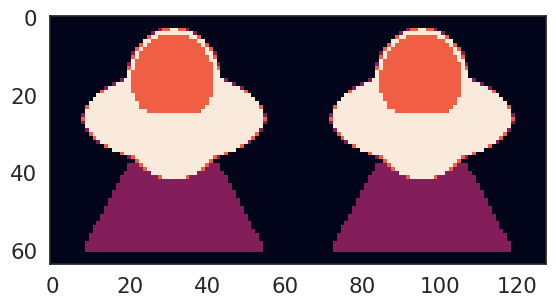

In [11]:
# Removing aliens
alien_label = y_train[1834, :]
plt.imshow(alien_label)

filter = [True] * X_train.shape[0]
removed = 0
print(len(filter))
for i, lab in enumerate(y_train):
    if np.array_equal(alien_label, lab):
        filter[i] = False
        removed += 1

X_train = X_train[filter]
y_train = y_train[filter]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f'removed {removed} images')

In [12]:
# Add color channel
X_train = X_train[..., np.newaxis]/255
X_test = X_test[..., np.newaxis]/255

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [13]:
# Augmentations
h_flip = A.HorizontalFlip(p=1.0)
v_flip = A.VerticalFlip(p=1.0)
rotation = A.Affine(rotate=180,p=1)

augmentations = [h_flip, v_flip, rotation]
aug_dataset = apply_augmentations(X_train, y_train, augmentations)
X_train, y_train = aug_dataset['images'], aug_dataset['labels']

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")

Training X shape: (7515, 64, 128, 1)
Training y shape: (7515, 64, 128)


Class Counts: [14330430, 14966478, 11312469, 20872614, 80889]
Class Percentages: [23.277712153817365, 24.31088019273952, 18.375470738211078, 33.90454442677145, 0.13139248846057885]
Computed Class Weights: {2.0: 0.022220544151821984, 3.0: 0.02814855680979399, 1.0: 0.015255888747690028, 4.0: 3.9343750102906943, 0.0: 0.0}


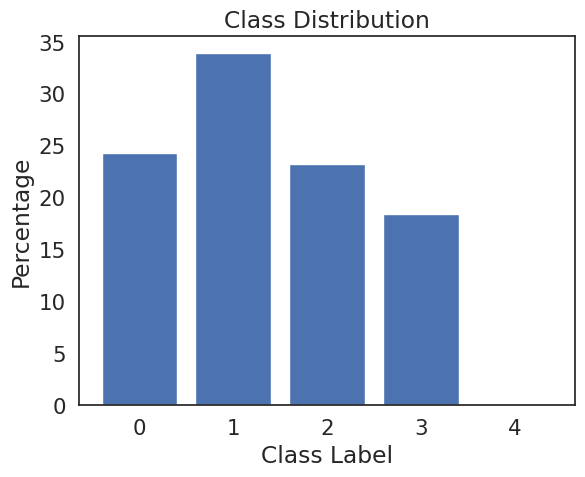

In [14]:
class_counts, class_percentages = compute_class_distribution(y_train, num_classes)
class_weights = compute_class_weights_from_dict(class_percentages)

# Print results
print("Class Counts:", list(class_counts.values()))
print("Class Percentages:", list(class_percentages.values()))
print("Computed Class Weights:", class_weights)

# Visualize class distribution
plt.bar(class_percentages.keys(), class_percentages.values())
plt.xlabel('Class Label')
plt.ylabel('Percentage')
plt.title('Class Distribution')
plt.show()

In [15]:
# Splitting in train-validation sets
train_img, val_img, train_lbl, val_lbl = train_test_split(
    X_train, y_train, test_size=0.1, random_state=seed
)
print("Data splitted!")

train_lbl_cat = tf.one_hot(train_lbl, depth=num_classes)
val_lbl_cat = tf.one_hot(val_lbl, depth=num_classes)

print(f"\nNumber of images:")
print(f"Train: {train_img.shape}")
print(f"Validation: {val_img.shape}")
print(f"\nLabels shape:")
print(f"Train: {train_lbl_cat.shape}")
print(f"Validation: {val_lbl_cat.shape}")

Data splitted!

Number of images:
Train: (6763, 64, 128, 1)
Validation: (752, 64, 128, 1)

Labels shape:
Train: (6763, 64, 128, 5)
Validation: (752, 64, 128, 5)


## 🛠️ Train and Save the Model

In [16]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [19]:
ks.get_custom_objects().clear()

@ks.register_keras_serializable()
class AdaptiveFusion(tf.keras.layers.Layer):
    def __init__(self, num_inputs, **kwargs):
        super(AdaptiveFusion, self).__init__(**kwargs)
        self.num_inputs = num_inputs
        self.gates = []

    def build(self, input_shape):
        # Creazione dei gate trainabili
        self.gates = [
            self.add_weight(
                shape=(1,), 
                initializer="ones", 
                trainable=True, 
                name=f"gate_{i}"
            )
            for i in range(self.num_inputs)
        ]
    
    def call(self, inputs):
        # Verifica che il numero di ingressi corrisponda al numero di gate
        if len(inputs) != self.num_inputs:
            raise ValueError(f"Expected {self.num_inputs} inputs, but got {len(inputs)}.")

        # Calcolo della somma pesata
        weighted_inputs = [gate * inp for gate, inp in zip(self.gates, inputs)]
        output = tf.add_n(weighted_inputs)  # Somma i tensori ponderati
        return output

    def get_config(self):
        config = super().get_config()
        config.update({"num_inputs": self.num_inputs})
        return config

In [20]:
def adaptive_multi_supervision(inputs, filters=1, kernel_size=3, activation='relu'):
    conv_inputs = []
    for i, inp in enumerate(inputs):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=f'ams_conv_{i}')(inp)
        x = tfkl.BatchNormalization(name=f'ams_bn_{i}')(x)
        x = tfkl.Activation(activation, name=f'ams_activation_{i}')(x)

        upscale_factor = int(64 / inp.shape[1])
        if upscale_factor != 1:
            x = tfkl.UpSampling2D(size=upscale_factor, interpolation='bilinear')(x)
        conv_inputs.append(x)

    x =  AdaptiveFusion(num_inputs=len(inputs))(inputs=conv_inputs)
    return x

In [22]:
def get_wnet_model(input_shape=(64, 128, 1), num_classes=num_classes, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path 1
    down_block_11 = unet_block(input_layer, 64, name='down_block11_')
    d11 = tfkl.MaxPooling2D()(down_block_11)

    down_block_12 = unet_block(d11, 128, name='down_block12_')
    d12 = tfkl.MaxPooling2D()(down_block_12)

    down_block_13 = unet_block(d12, 256, name='down_block13_')
    d13 = tfkl.MaxPooling2D()(down_block_13)

    # Bottleneck
    bottleneck_1 = unet_block(d13,512,name='bottleneck1')

    # Upsampling path
    u13 = tfkl.UpSampling2D()(bottleneck_1)
    u13 = tfkl.Concatenate()([u13,down_block_13])
    up_block_13 = unet_block(u13, 256, name='up_block13_')

    u12 = tfkl.UpSampling2D()(up_block_13)
    u12 = tfkl.Concatenate()([u12,down_block_12])
    up_block_12 = unet_block(u12, 128, name='up_block12_')

    u11 = tfkl.UpSampling2D()(up_block_12)
    u11 = tfkl.Concatenate()([u11,down_block_11])
    up_block_11 = unet_block(u11, 64, name='up_block11_')

    u10 = tfkl.Concatenate()([up_block_11,input_layer])
    up_block_10 = unet_block(u10, 16, name='up_block10_')

    # Downsampling path
    d21 = tfkl.Concatenate()([up_block_10,down_block_11])
    down_block_21 = unet_block(d21, 64, name='down_block21_')
    d21 = tfkl.MaxPooling2D()(down_block_21)

    d22 = tfkl.Concatenate()([up_block_12,down_block_12,d21])
    down_block_22 = unet_block(d22, 128, name='down_block22_')
    d22 = tfkl.MaxPooling2D()(down_block_22)

    d23 = tfkl.Concatenate()([up_block_13,down_block_13,d22])
    down_block_23 = unet_block(d23, 256, name='down_block23_')
    d23 = tfkl.MaxPooling2D()(down_block_23)

    # Bottleneck
    bottleneck_2 = tfkl.Concatenate()([bottleneck_1,d23])
    bottleneck_2 = unet_block(bottleneck_2,512,name='bottleneck2')

    # Upsampling path
    u23 = tfkl.UpSampling2D()(bottleneck_2)
    u23 = tfkl.Concatenate()([u23,down_block_23,down_block_13,up_block_13])
    up_block_23 = unet_block(u23, 256, name='up_block23_')

    u22 = tfkl.UpSampling2D()(up_block_23)
    u22 = tfkl.Concatenate()([u22,down_block_22,down_block_12,up_block_12])
    up_block_22 = unet_block(u22, 128, name='up_block22_')

    u21 = tfkl.UpSampling2D()(up_block_22)
    u21 = tfkl.Concatenate()([u21,down_block_21,down_block_11,up_block_11])
    up_block_21 = unet_block(u21, 64, name='up_block21_')

    u20 = tfkl.Concatenate()([up_block_21,up_block_10])
    up_block_20 = unet_block(u20, 16, name='up_block20_')

    # Adaptive Multi-Supervision
    ams_output = adaptive_multi_supervision(inputs=[up_block_10,up_block_23,up_block_22,up_block_21,up_block_20])
    
    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(ams_output)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='WNet')
    return model

Model: "WNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block11_con… │ (None, 64, 128, │       640 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block11_gn1  │ (None, 64, 128, │       256 │ down_block11_… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block11_act… │ (None, 64, 128, │         0 │ down_block11_… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block11_con… │ (None, 64, 128, │    36,928 │ down_block11_… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block11_gn2  │ (None, 64, 128, │       256 │ down_block11_… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block11_act… │ (None, 64, 128, │         0 │ down_block11_… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ down_block11_… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block12_con… │ (None, 32, 64,  │    73,856 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block12_gn1  │ (None, 32, 64,  │       512 │ down_block12_… │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block12_act… │ (None, 32, 64,  │         0 │ down_block12_… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block12_con… │ (None, 32, 64,  │   147,584 │ down_block12_… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block12_gn2  │ (None, 32, 64,  │       512 │ down_block12_… │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block12_act… │ (None, 32, 64,  │         0 │ down_block12_… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_1   │ (None, 16, 32,  │         0 │ down_block12_… │   -   │
│ (MaxPooling2D)    │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block13_con… │ (None, 16, 32,  │   295,168 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block13_gn1  │ (None, 16, 32,  │     1,024 │ down_block13_… │   Y 

 Total params: 21,043,736 (80.28 MB)

 Trainable params: 21,032,334 (80.23 MB)

 Non-trainable params: 11,402 (44.54 KB)

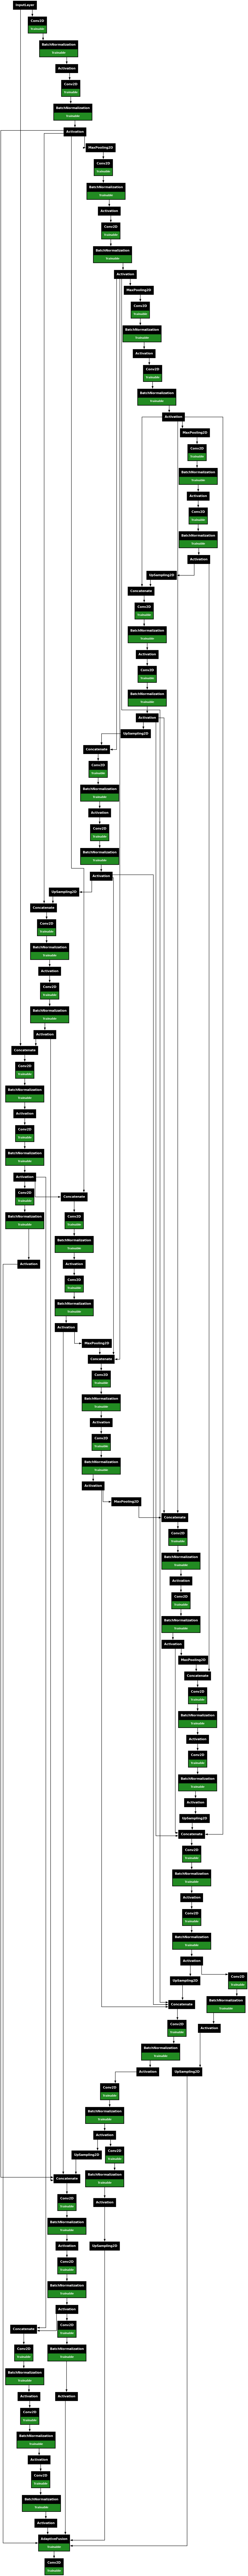

In [23]:
model = get_wnet_model()
model.summary(expand_nested=True, show_trainable=True)
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [24]:
@ks.register_keras_serializable()
class CustomLoss(tfk.losses.Loss):
    def __init__(self, k_dice, k_focal, **kwargs):
        super(CustomLoss, self).__init__()
        self.k_dice = k_dice
        self.k_focal = k_focal

        self.dice_loss = sm.losses.DiceLoss(class_indexes=[1,2,3,4])
        self.focal_loss = sm.losses.CategoricalFocalLoss(class_indexes=[1,2,3,4])

    def get_config(self):
        config = super().get_config()
        # Update the config with the custom layer's parameters
        config.update(
            {
                "k_dice": self.k_dice,
                "k_focal": self.k_focal,
            }
        )
        return config
    
    def call(self, y_true, y_pred):
        focal = self.focal_loss(y_true, y_pred)
        dice = self.dice_loss(y_true, y_pred)

        return self.k_dice * dice + self.k_focal * focal

In [25]:
# Reused parameters for all models
learning_rate = 1e-3
patience = 30
batch_size = 64
epochs = 1000

optimizer = tf.keras.optimizers.AdamW(learning_rate, clipnorm=1.0)
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_true=False, sparse_y_pred=False, name="meaniou")
metrics = ["accuracy", mean_iou]

# Loss function for model
loss = CustomLoss(1, 1)

sample_weights = compute_sample_weights(train_lbl_cat, class_weights)

# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_meaniou',
    mode='max',
    patience=patience,
    restore_best_weights=True
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_meaniou",
    mode='max',
    factor=0.1,
    patience=20,
    min_lr=1e-6
)

In [26]:
# Compile model
model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=metrics
)

# Train the model
history = model.fit(
    train_img,
    train_lbl_cat,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    sample_weight=sample_weights,
    validation_data=(val_img, val_lbl_cat),
    callbacks=[early_stopping, reduce_lr]
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_meaniou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)

print(f"Model saved to {model_filename}")

del model

Epoch 1/1000


I0000 00:00:1734173302.790967      74 service.cc:145] XLA service 0x7a7e5c003920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734173302.791036      74 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1734173365.503553      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


106/106 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.3215 - loss: 0.0159 - meaniou: 0.1524 - val_accuracy: 0.1820 - val_loss: 0.8777 - val_meaniou: 0.0623 - learning_rate: 0.0010
Epoch 2/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 49s 459ms/step - accuracy: 0.3789 - loss: 0.0150 - meaniou: 0.2608 - val_accuracy: 0.1797 - val_loss: 0.8727 - val_meaniou: 0.0592 - learning_rate: 0.0010
Epoch 3/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 49s 460ms/step - accuracy: 0.4836 - loss: 0.0145 - meaniou: 0.3620 - val_accuracy: 0.2094 - val_loss: 0.8677 - val_meaniou: 0.0980 - learning_rate: 0.0010
Epoch 4/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 49s 459ms/step - accuracy: 0.5897 - loss: 0.0140 - meaniou: 0.4780 - val_accuracy: 0.1936 - val_loss: 0.8644 - val_meaniou: 0.0710 - learning_rate: 0.0010
Epoch 5/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 49s 460ms/step - accuracy: 0.6110 - loss: 0.0136 - meaniou: 0.5061 - val_accuracy: 0.4186 - val_loss: 0.7342 - val_meaniou: 0.2906 - learning_rate: 0.0010
Epoch 6/1000
106/106 ━━━━━━━━━

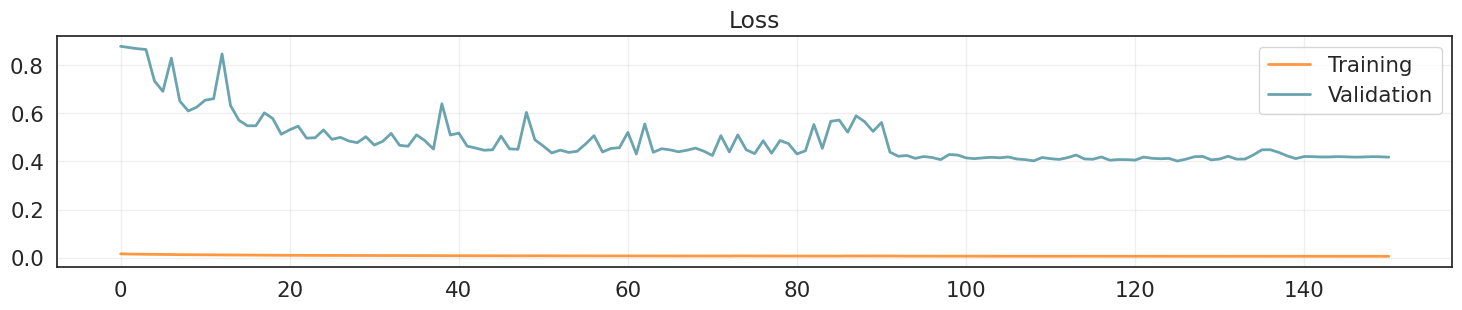

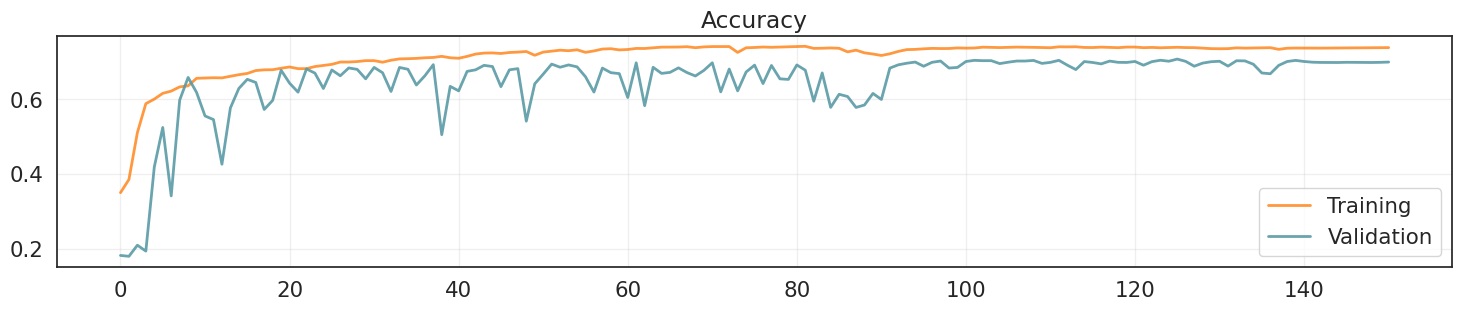

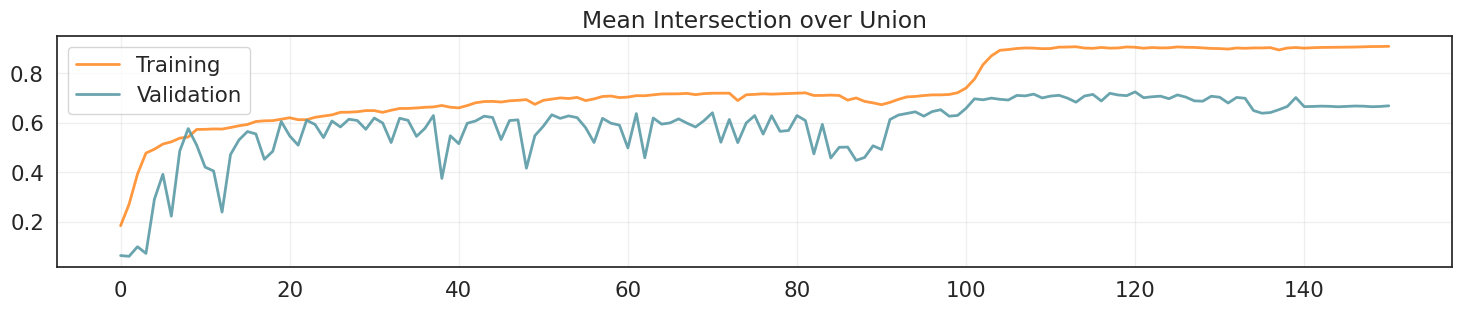

In [27]:
plot_training_history(history)

## Visualize predictions

In [28]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [29]:
model = tfk.models.load_model(model_filename)
print(f"Model loaded from {model_filename}")

Model loaded from model_241214_125246.keras


In [30]:
val_lbl_pred = model.predict(val_img)

24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 370ms/step


In [31]:
y_pred_argmax = np.argmax(val_lbl_pred, axis=-1)  # Convert one-hot predictions to class indices
val_lbl_argmax = np.argmax(val_lbl_cat, axis=-1)  # Convert one-hot labels to class indices

miou_per_class = calculate_classwise_miou(val_lbl_argmax, y_pred_argmax, num_classes)

# Print the IoU scores for each class
print("Class-wise IoU scores:")
for cls, score in miou_per_class.items():
    print(f"{cls}: {score:.4f}")

Class-wise IoU scores:
Class 0: 0.0000
Class 1: 0.6272
Class 2: 0.6599
Class 3: 0.7504
Class 4: 0.2639


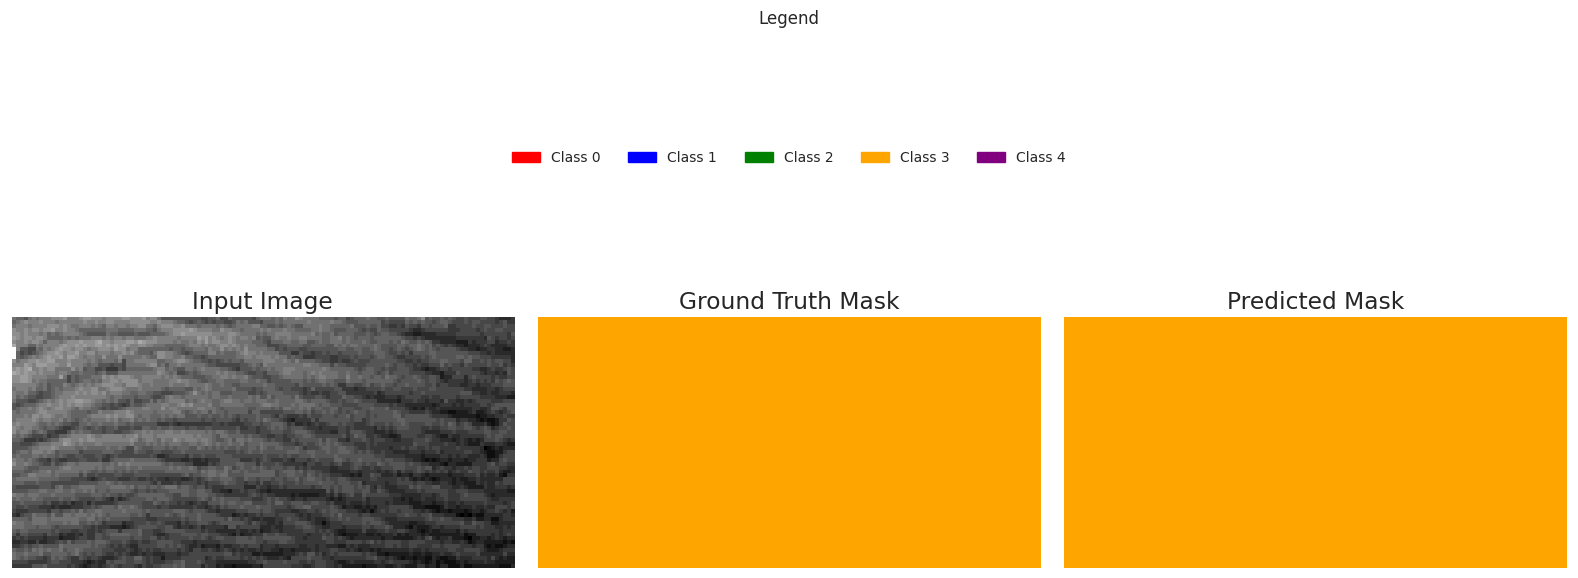

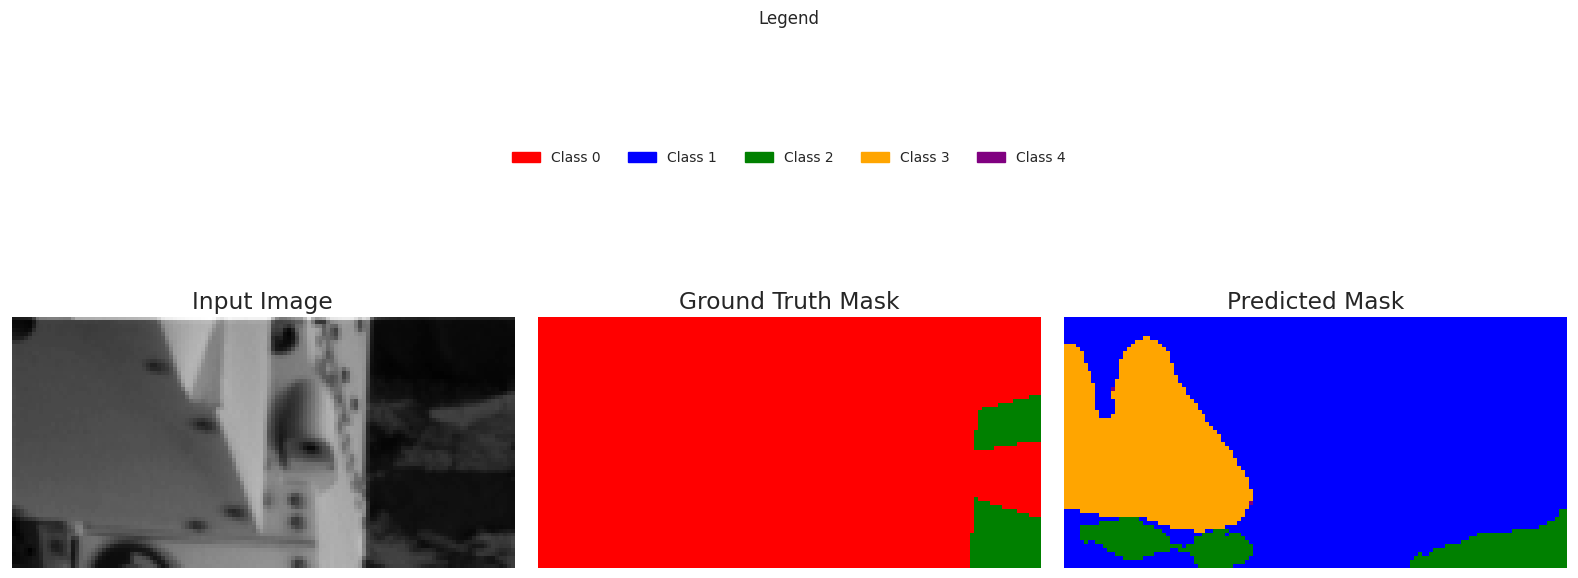

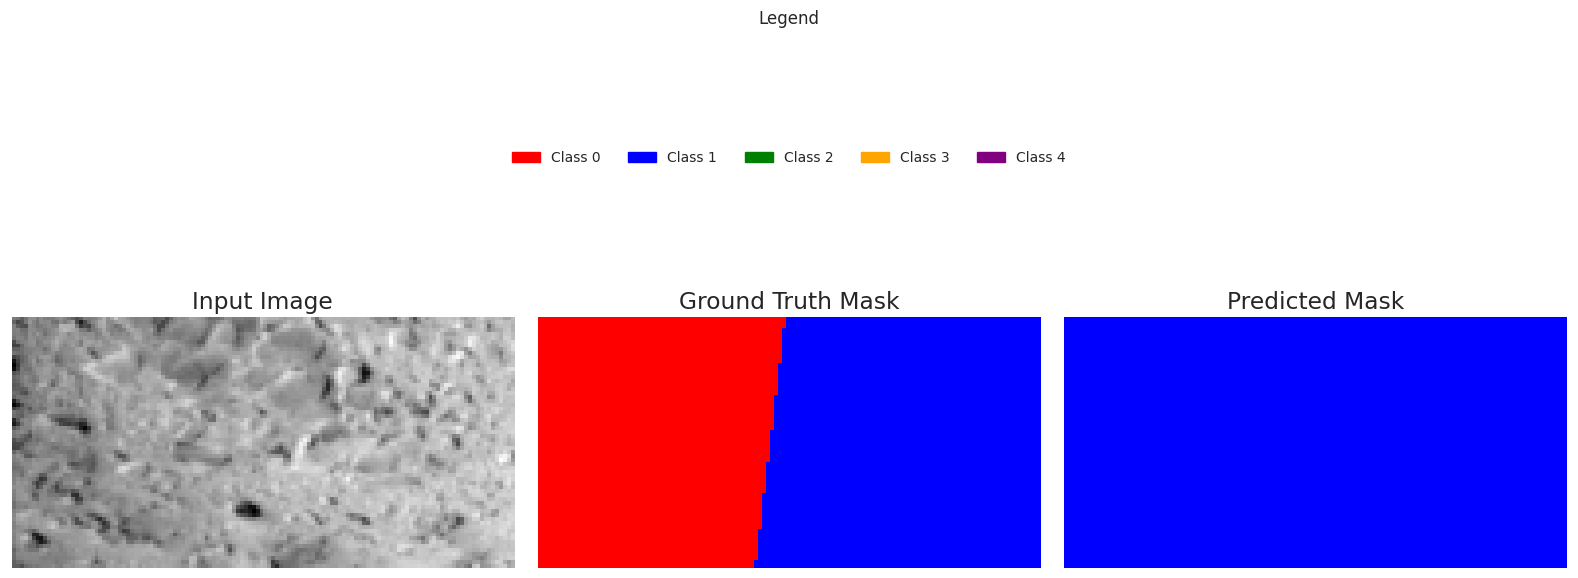

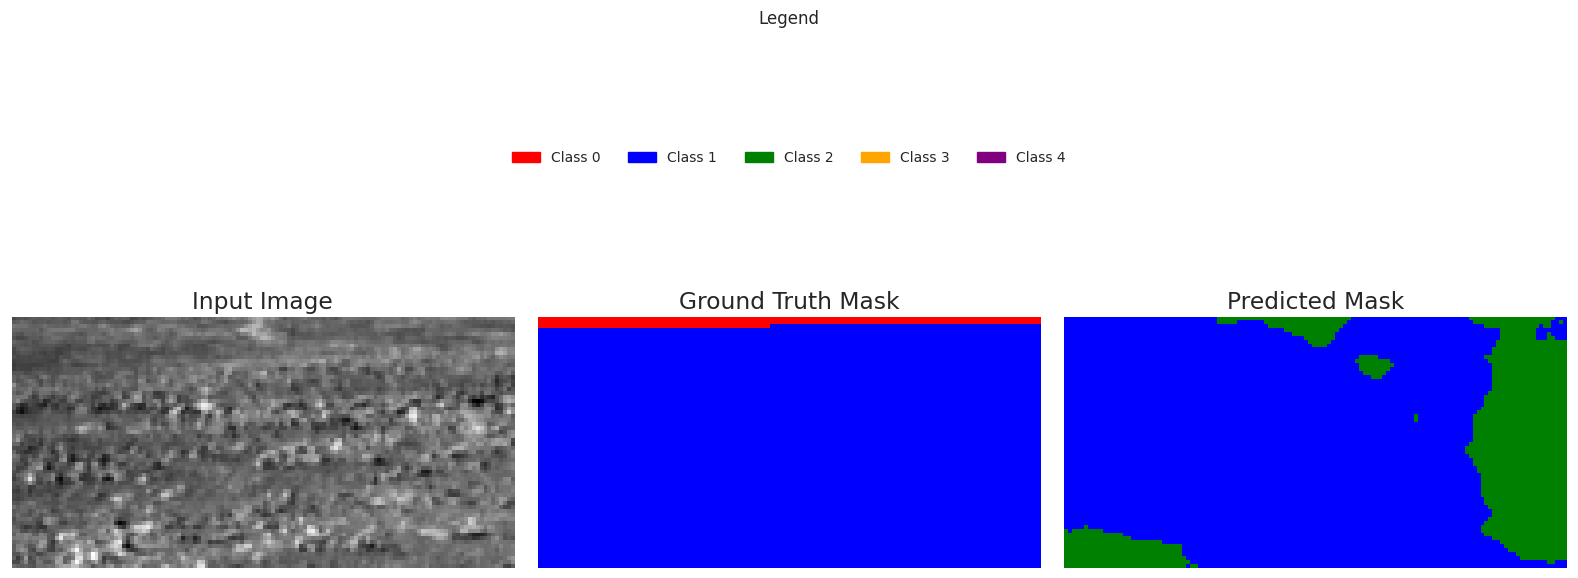

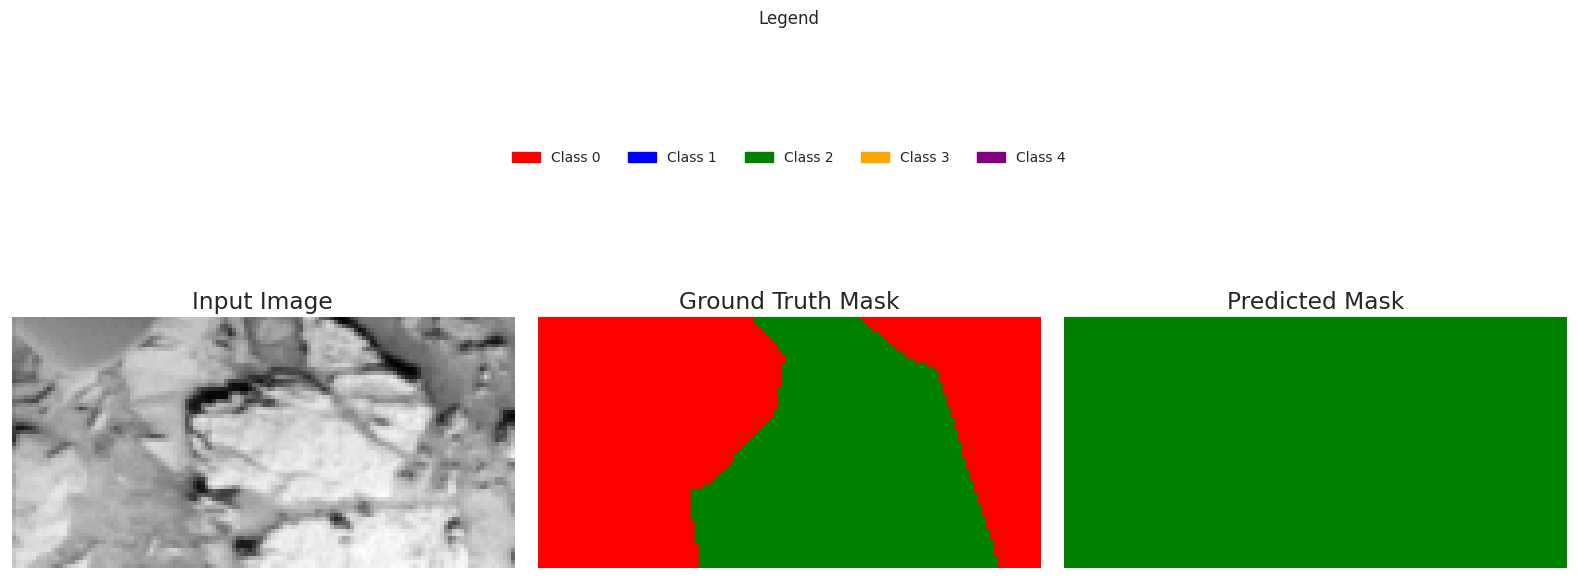

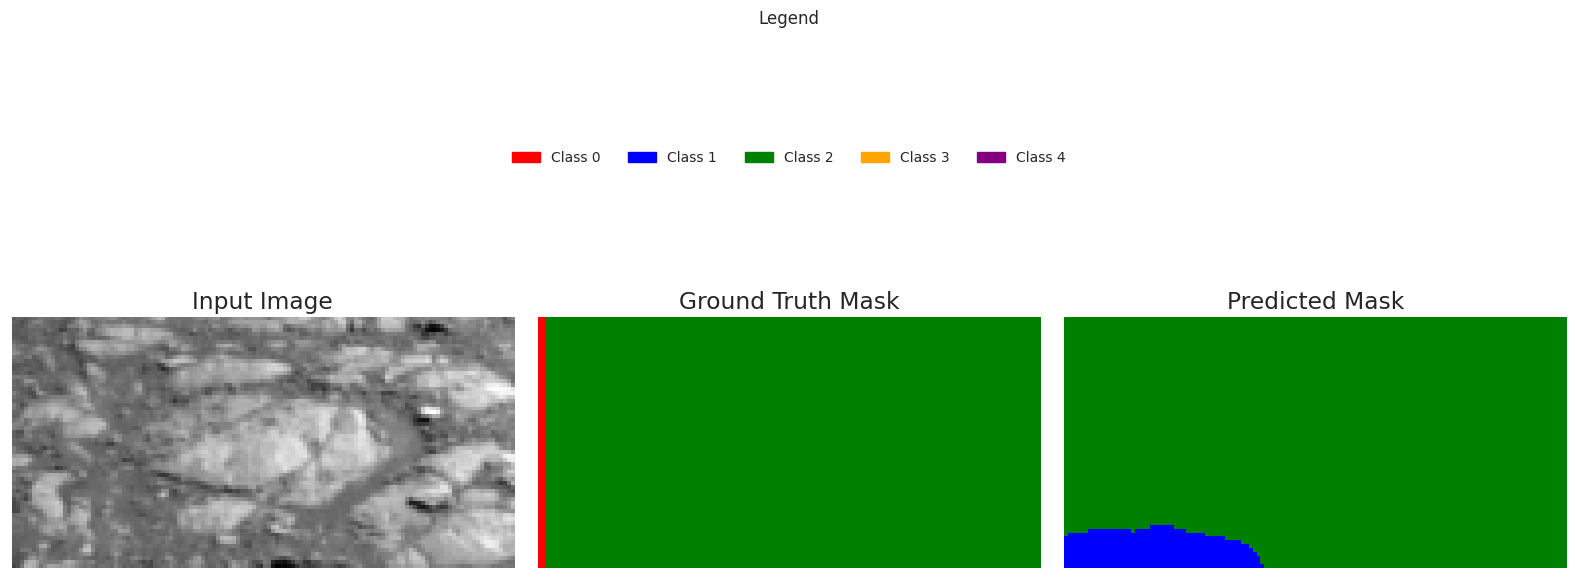

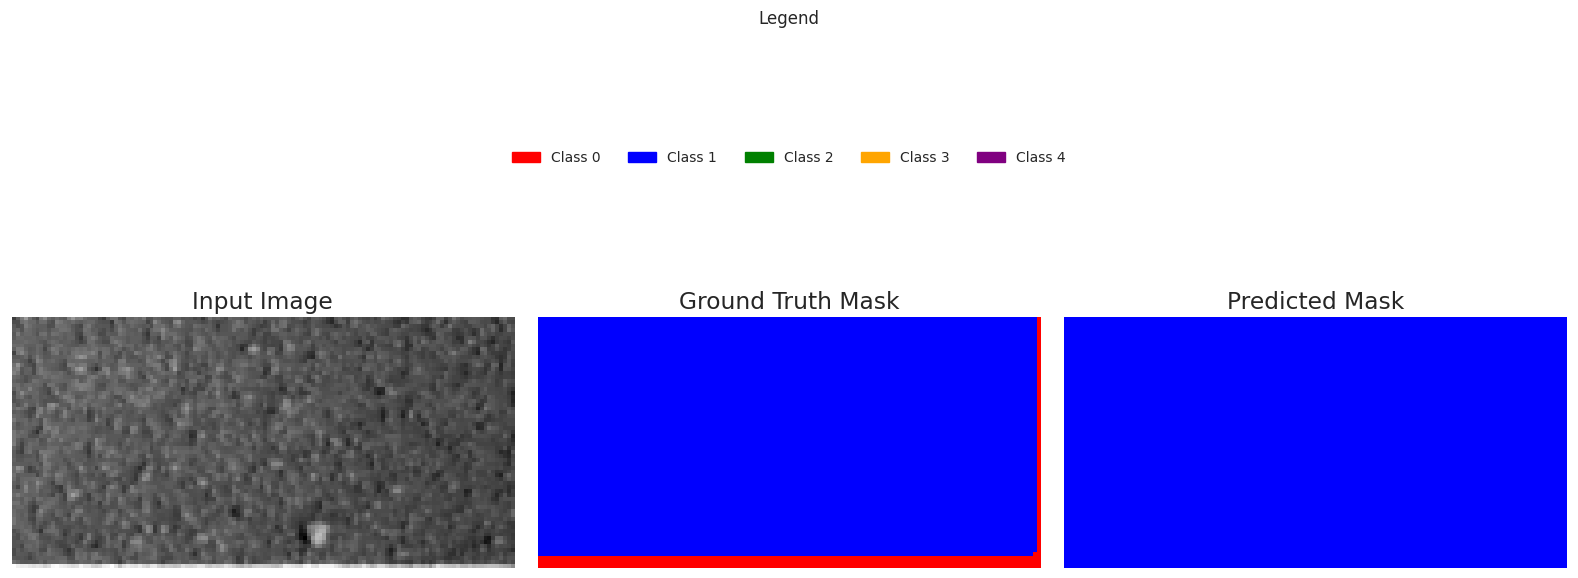

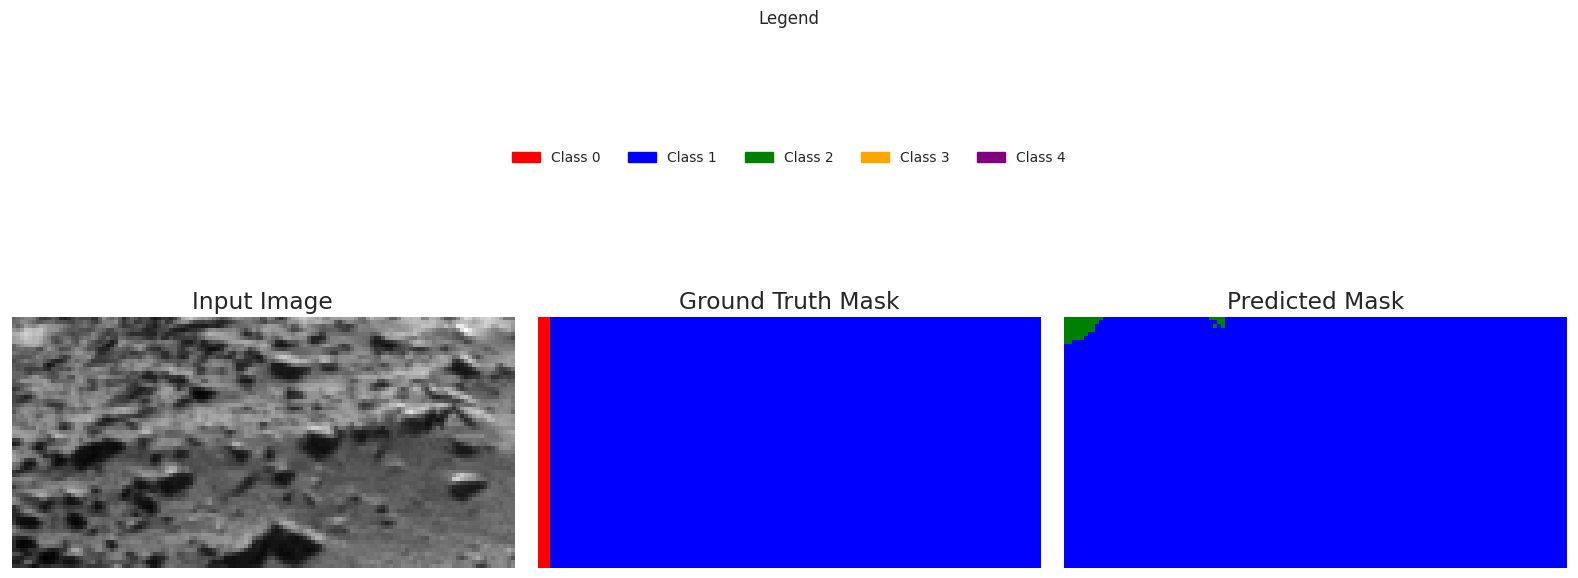

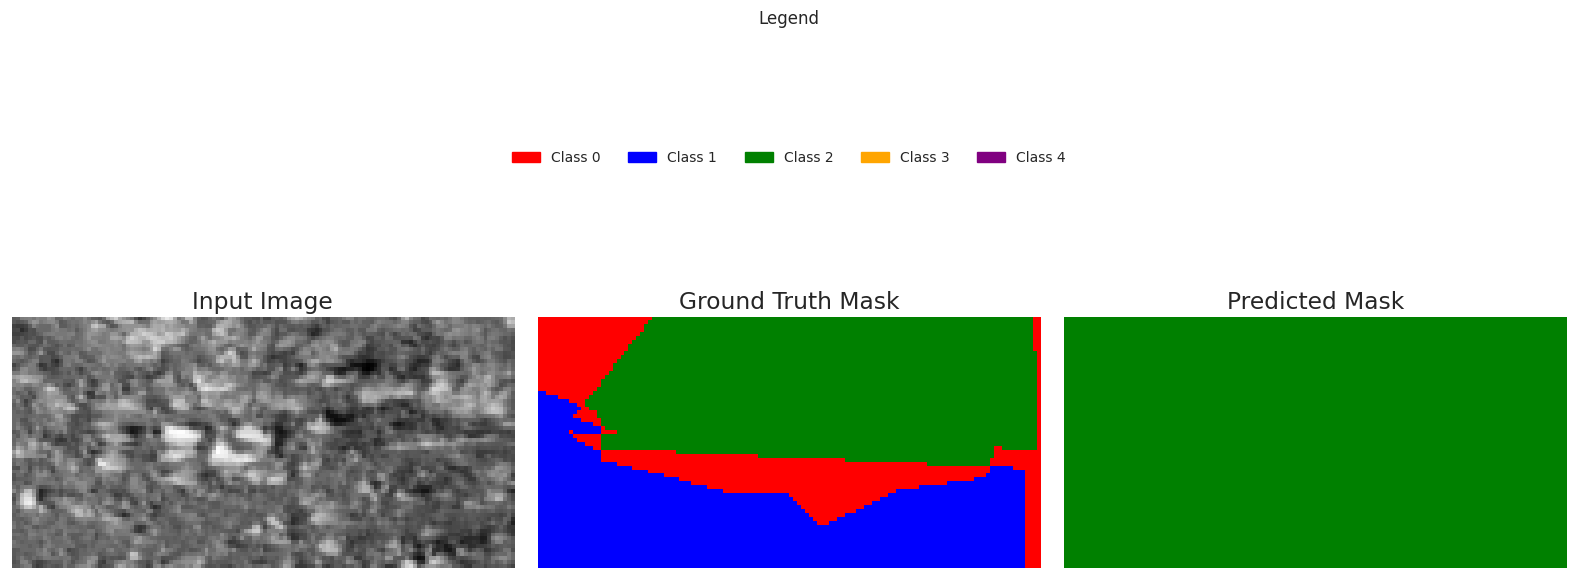

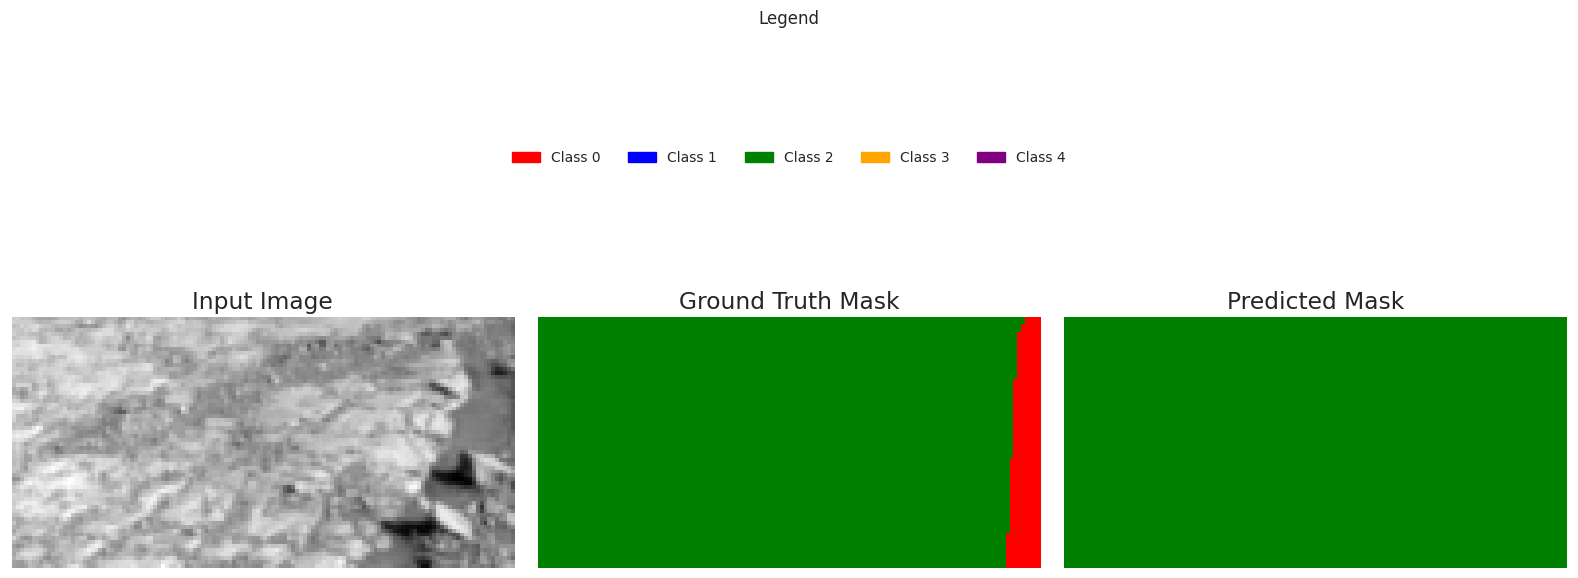

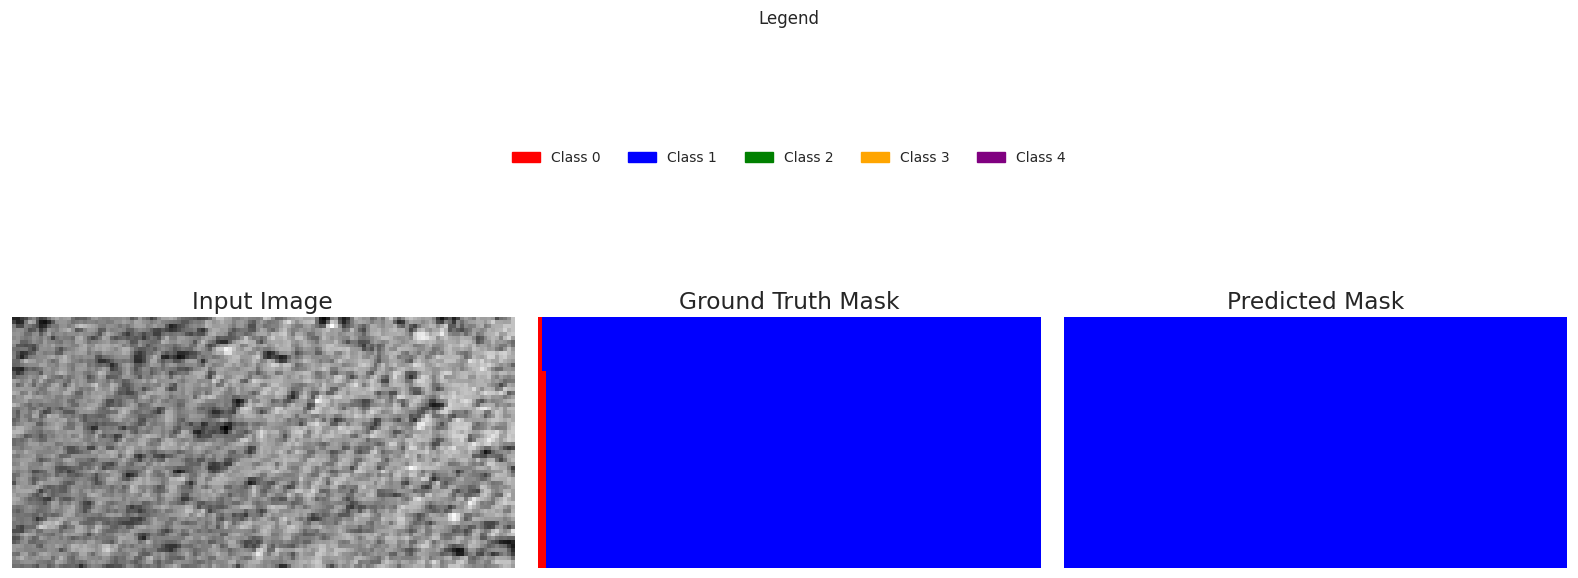

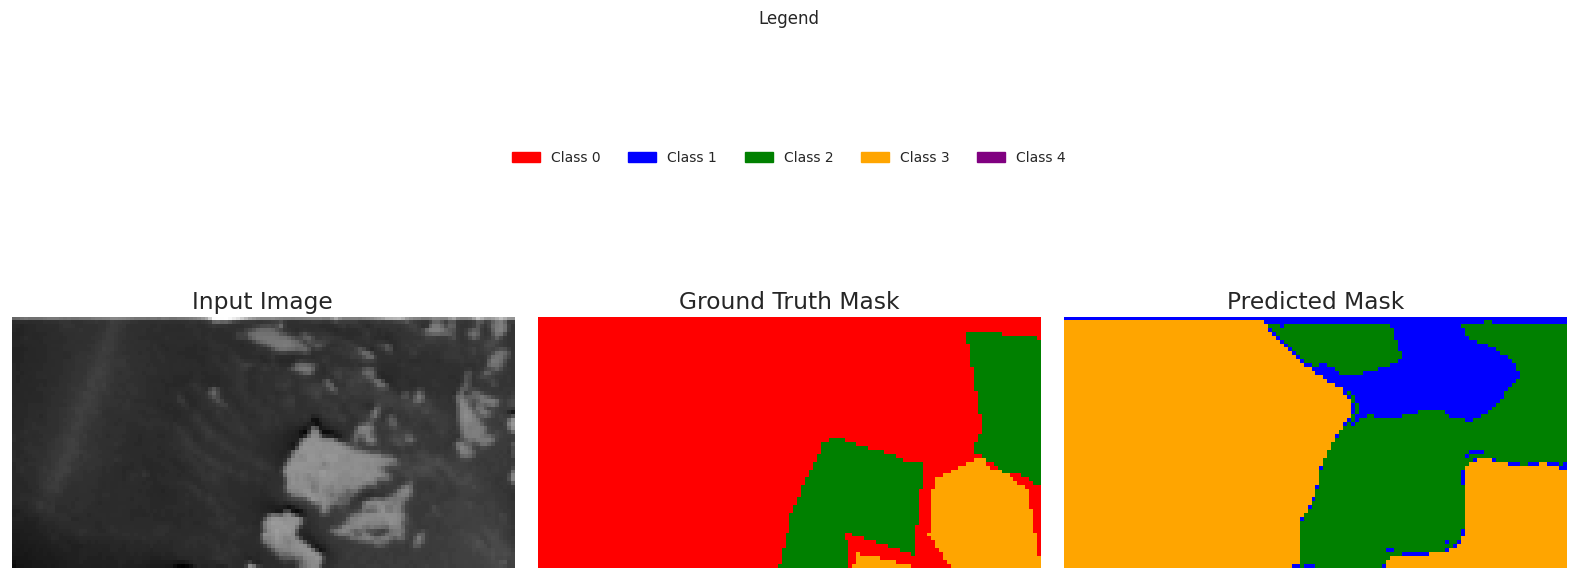

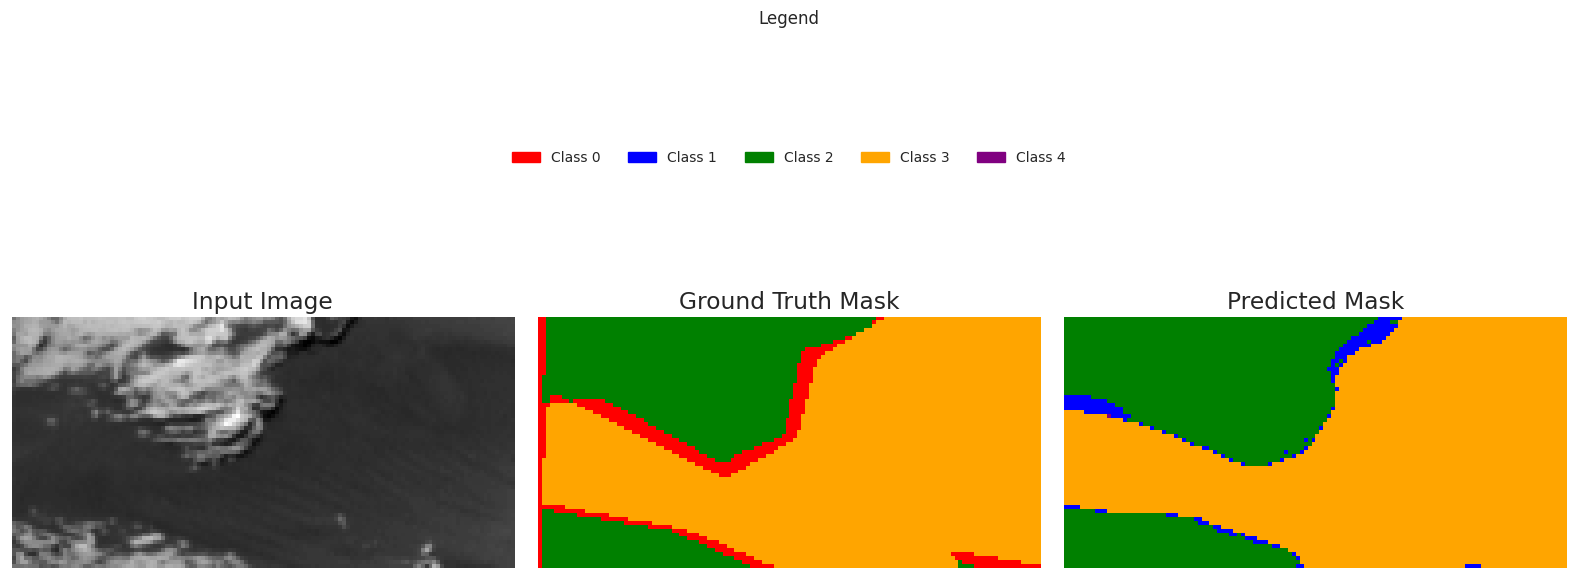

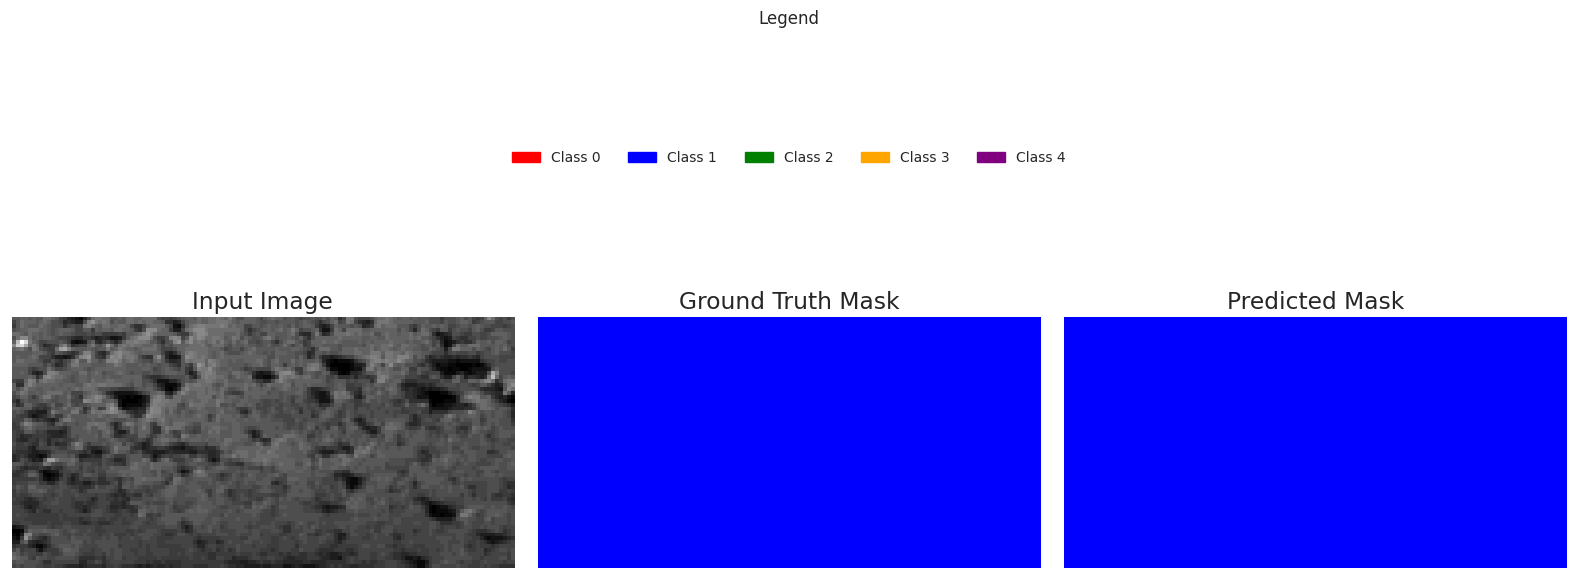

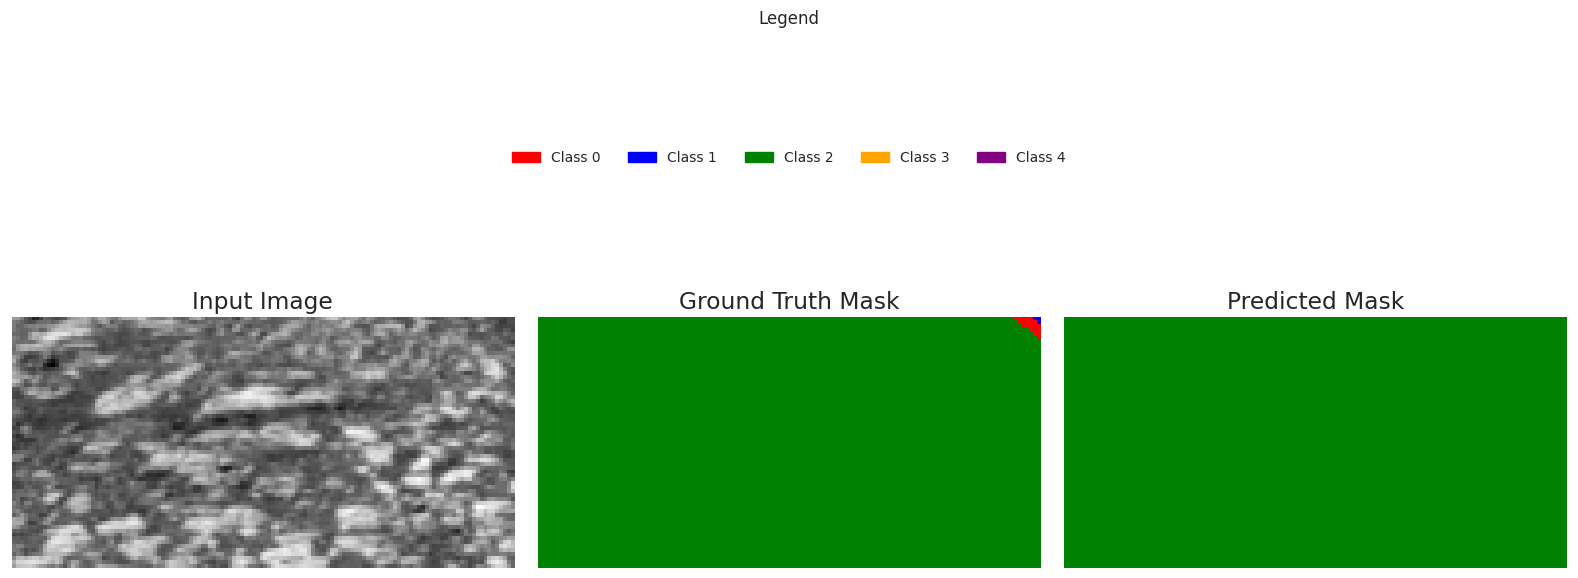

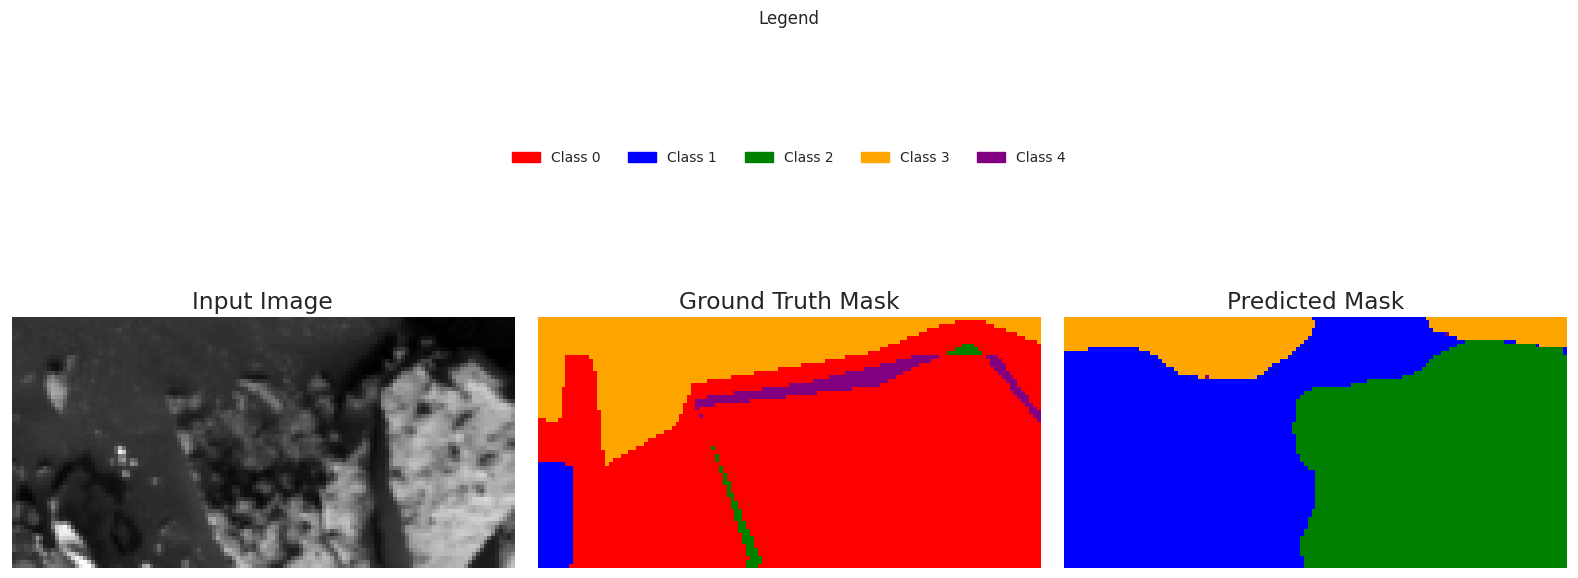

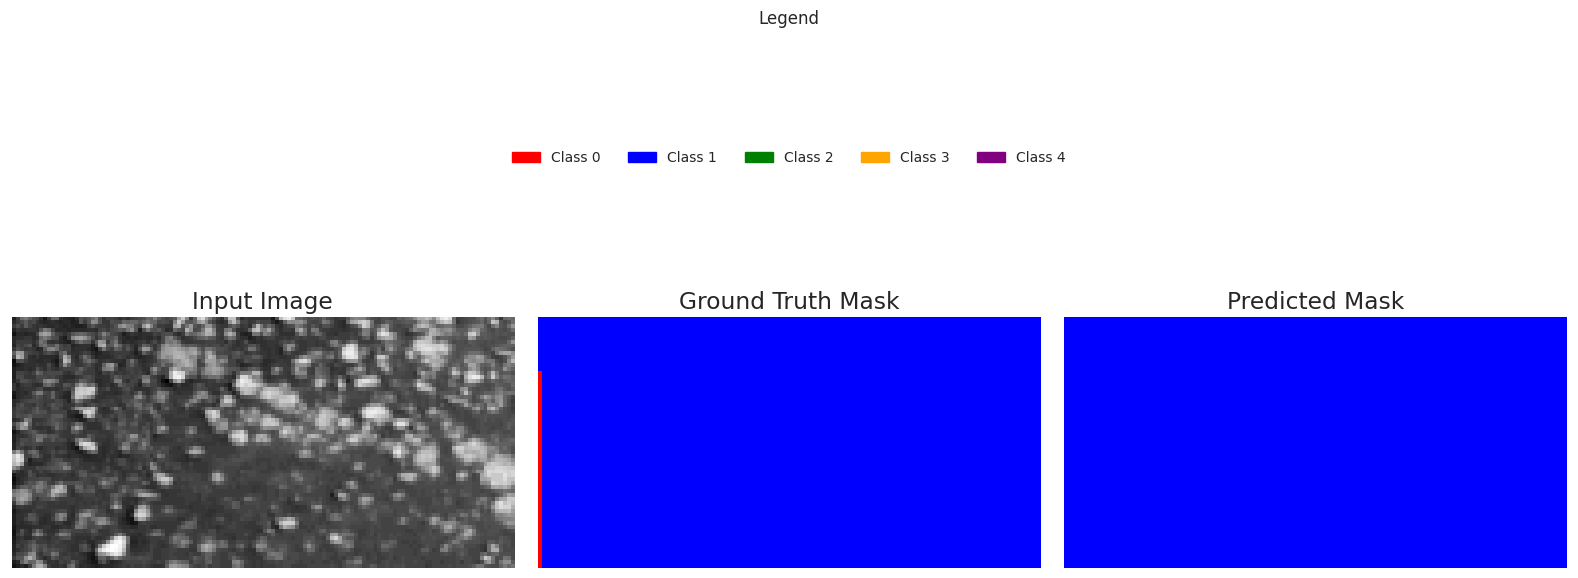

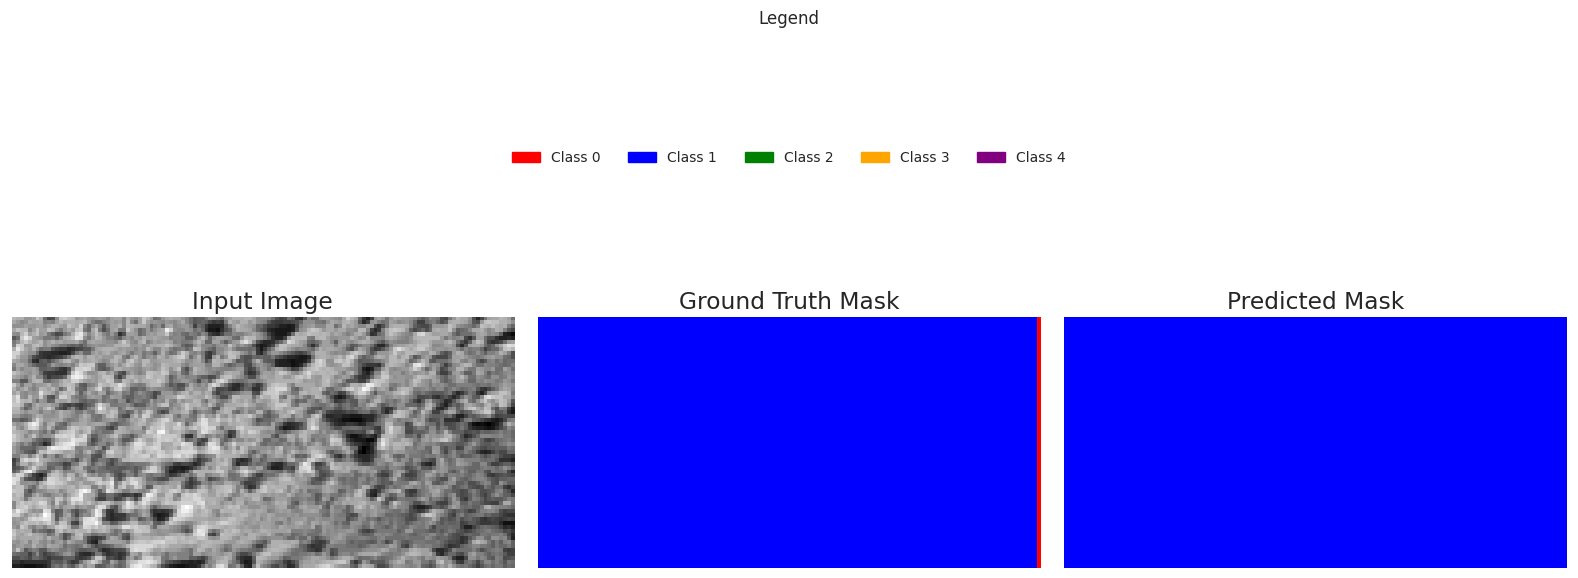

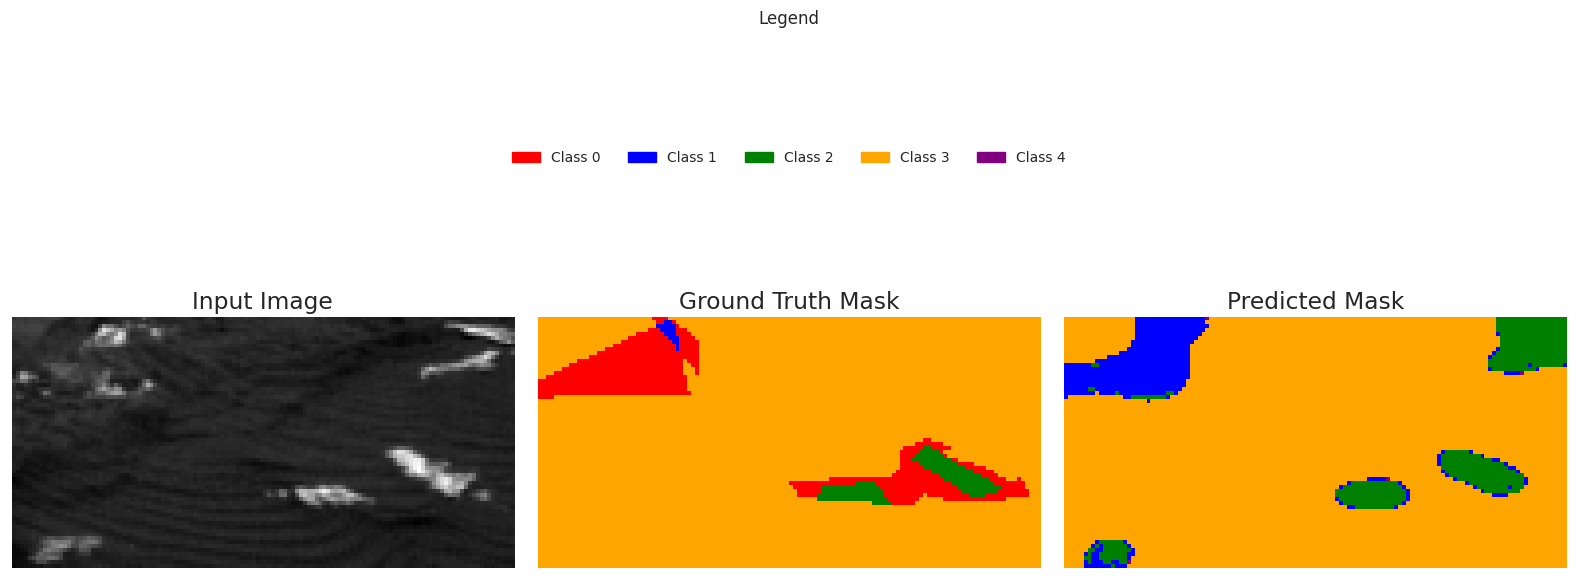

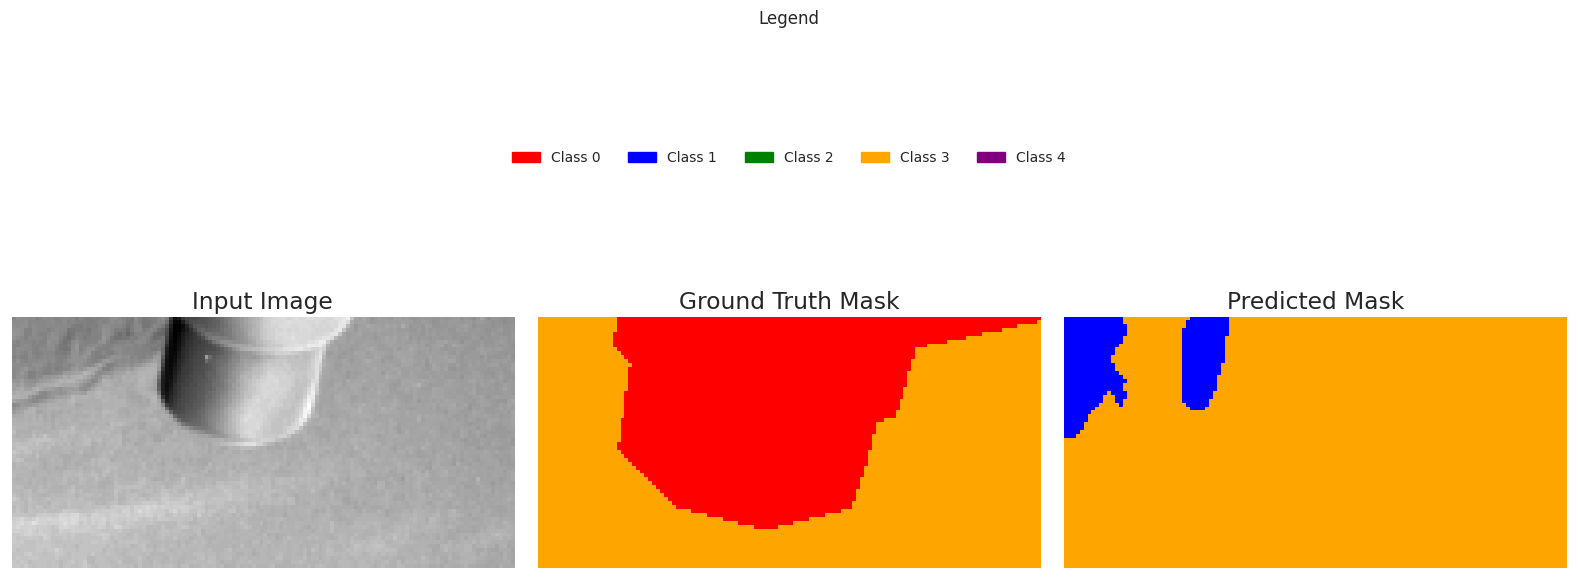

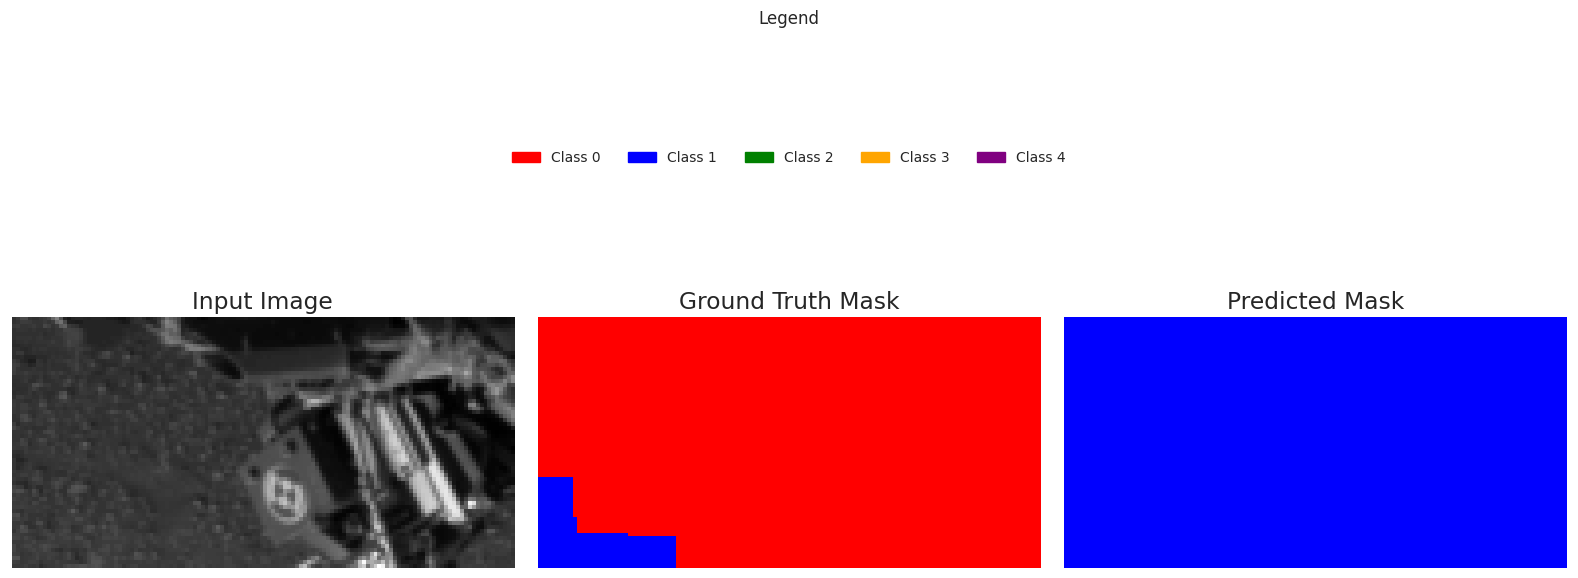

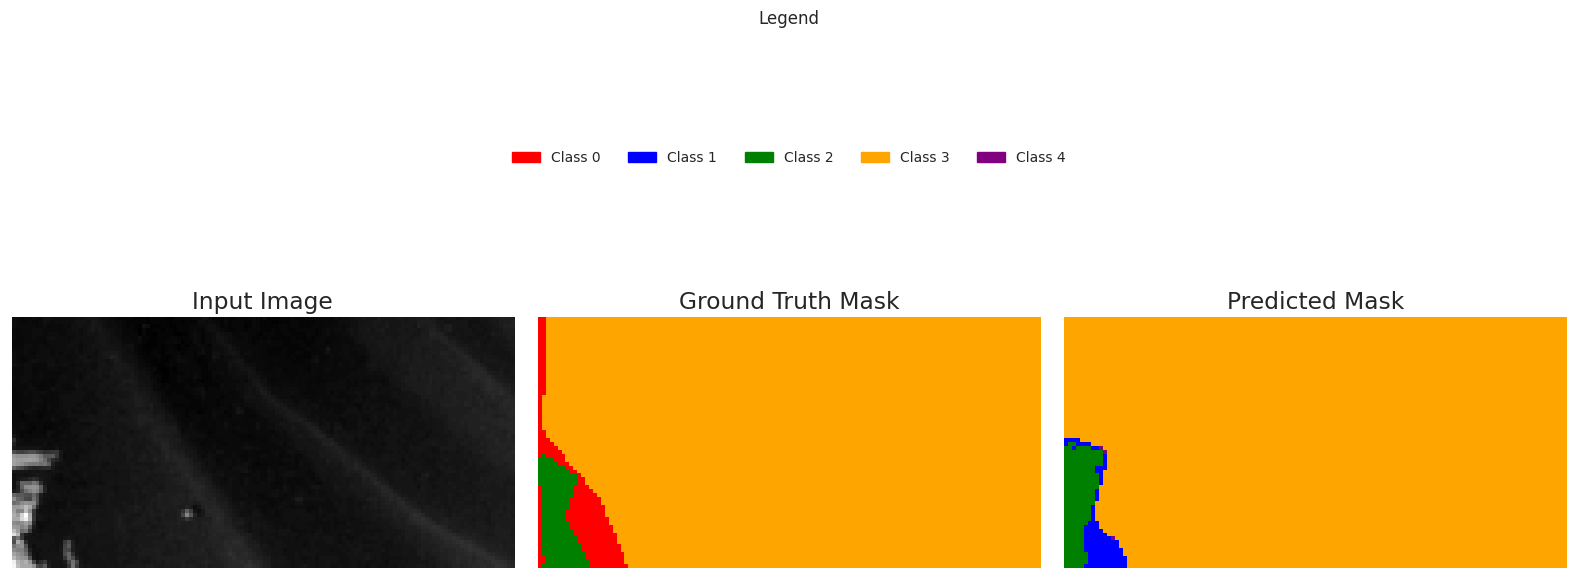

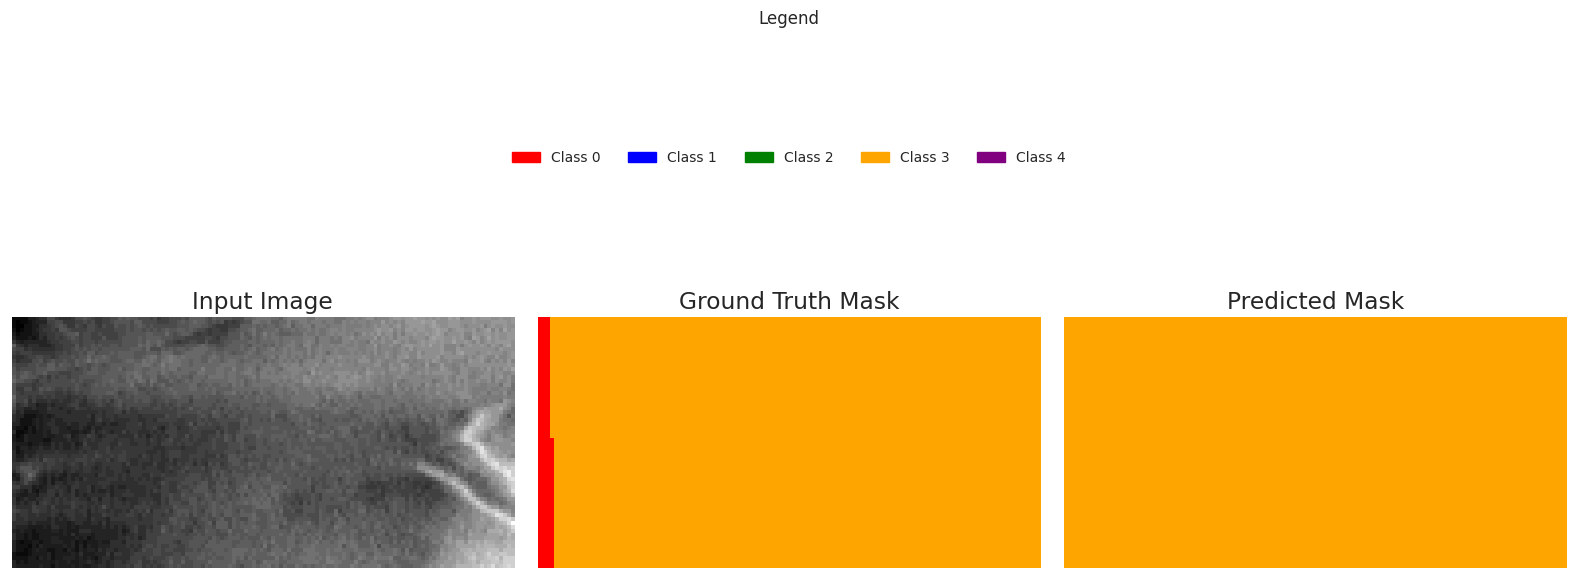

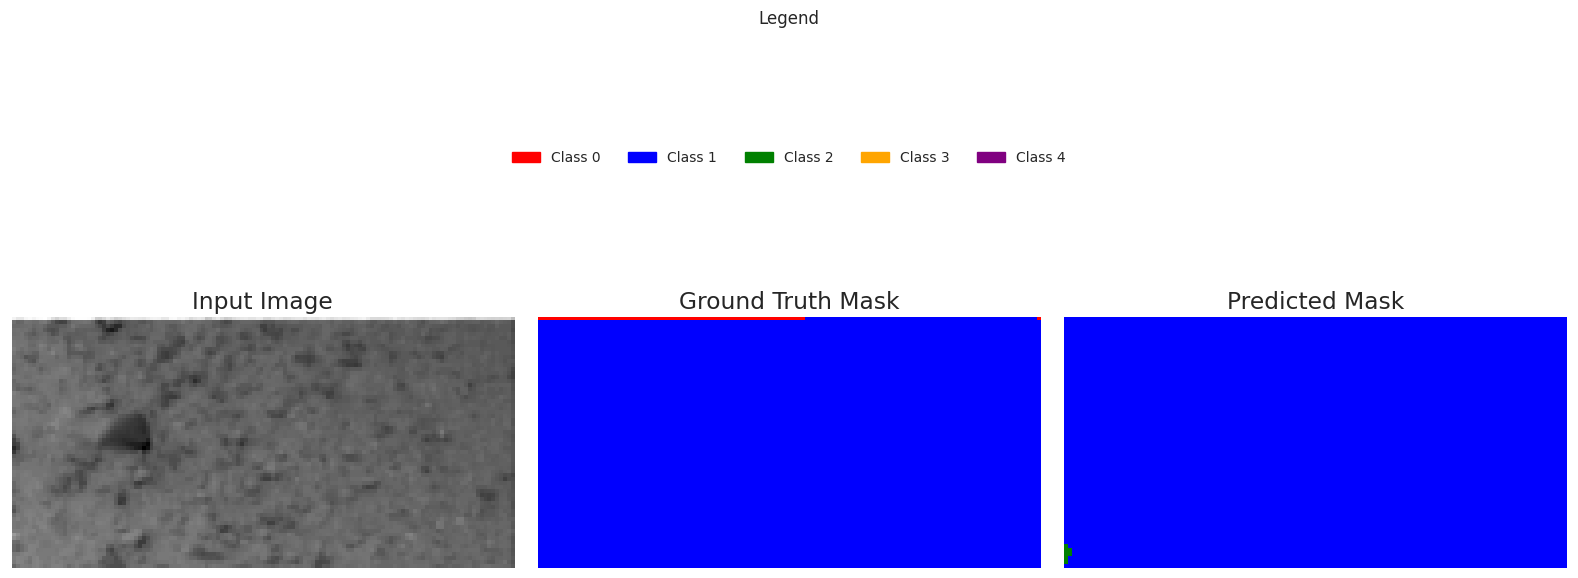

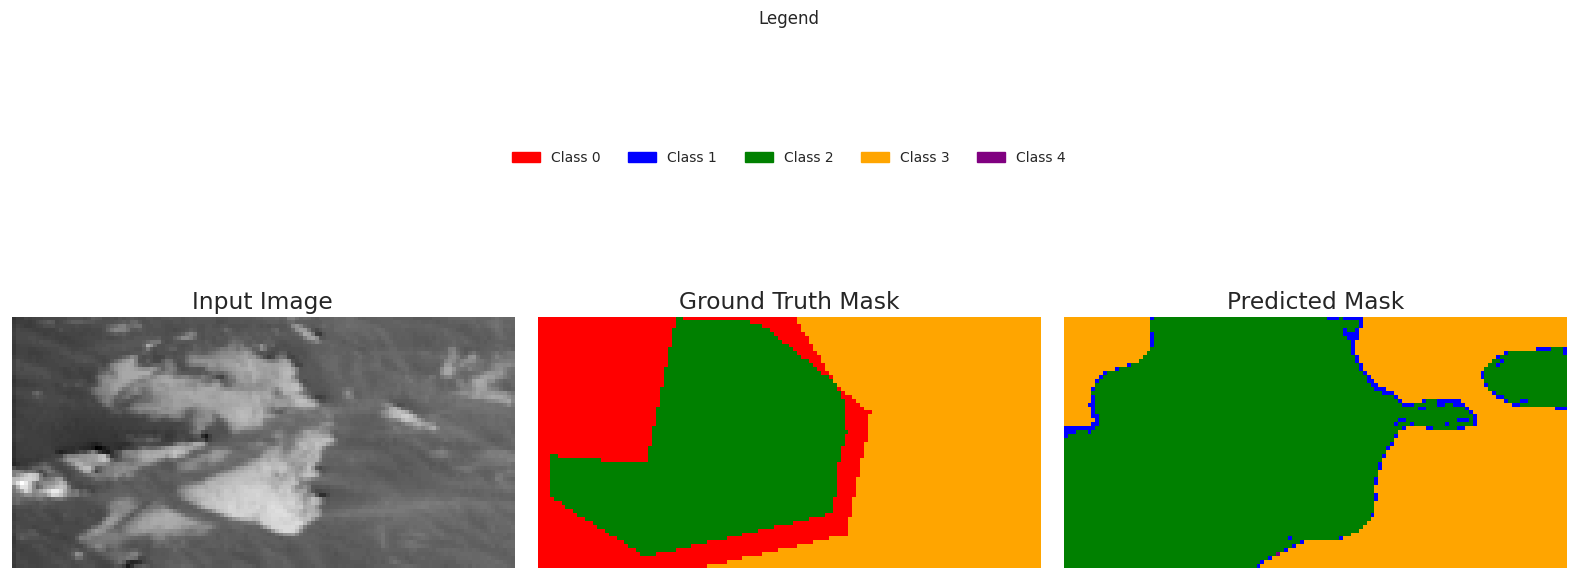

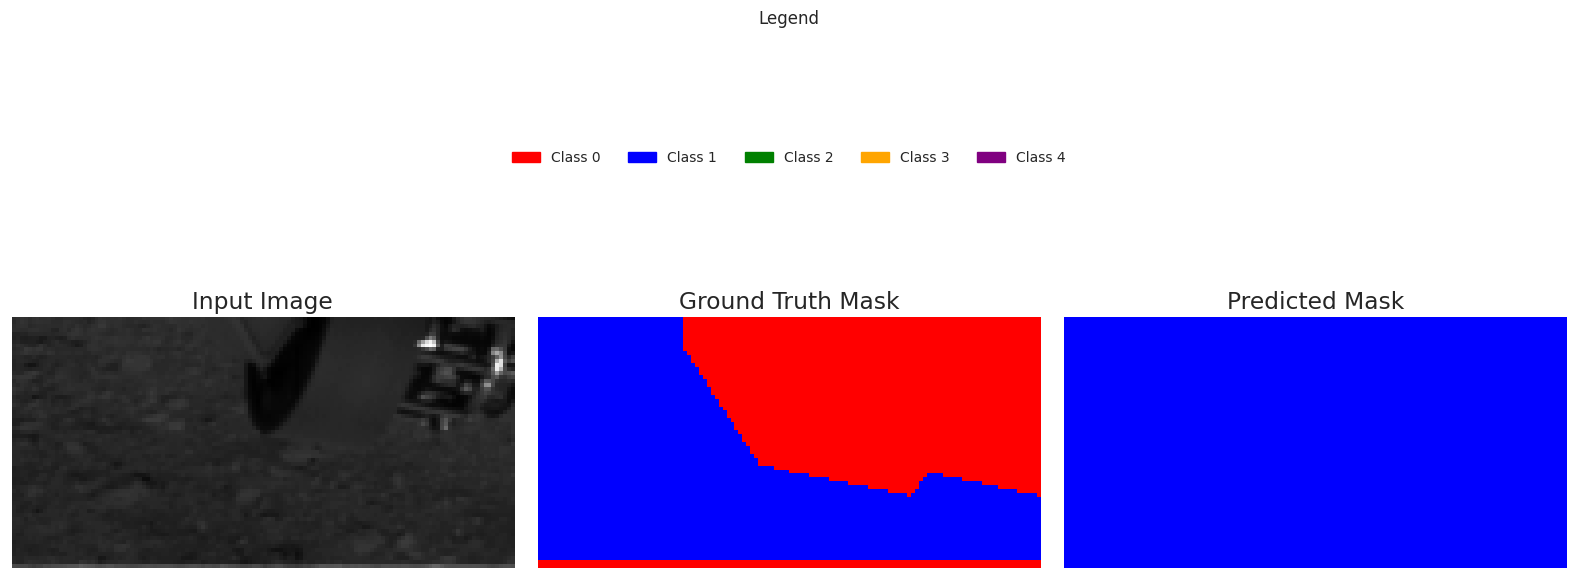

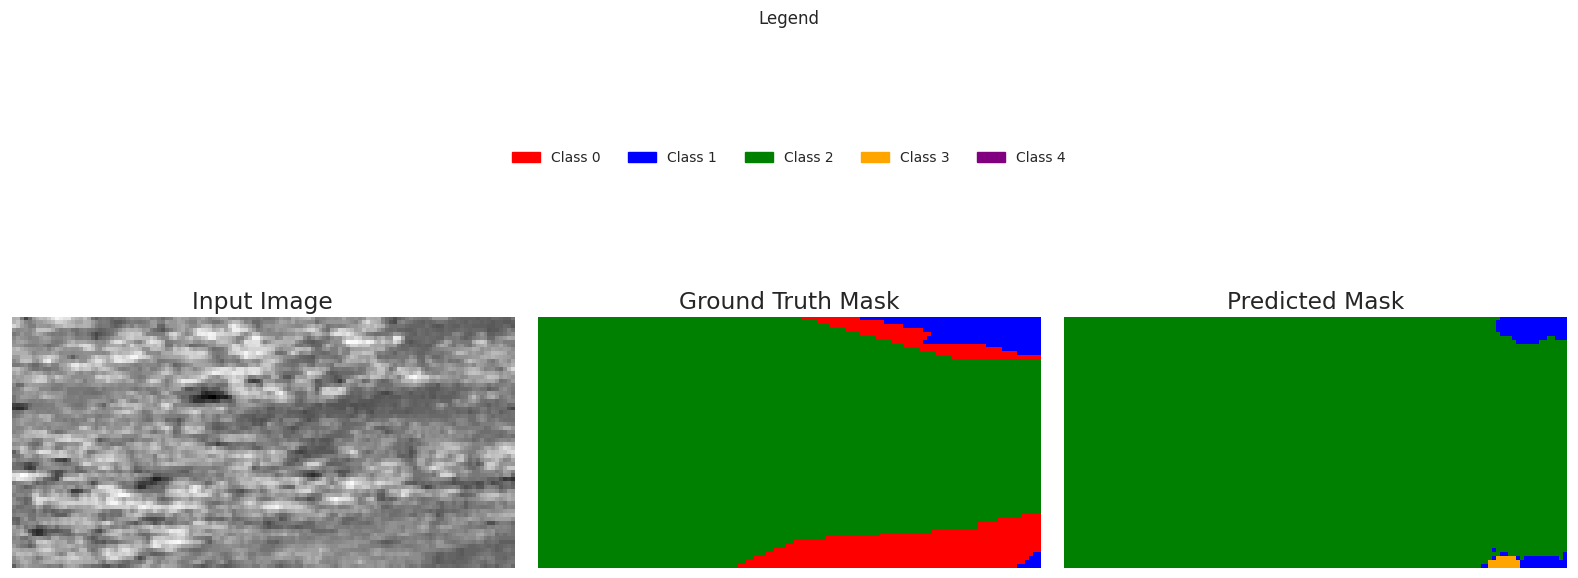

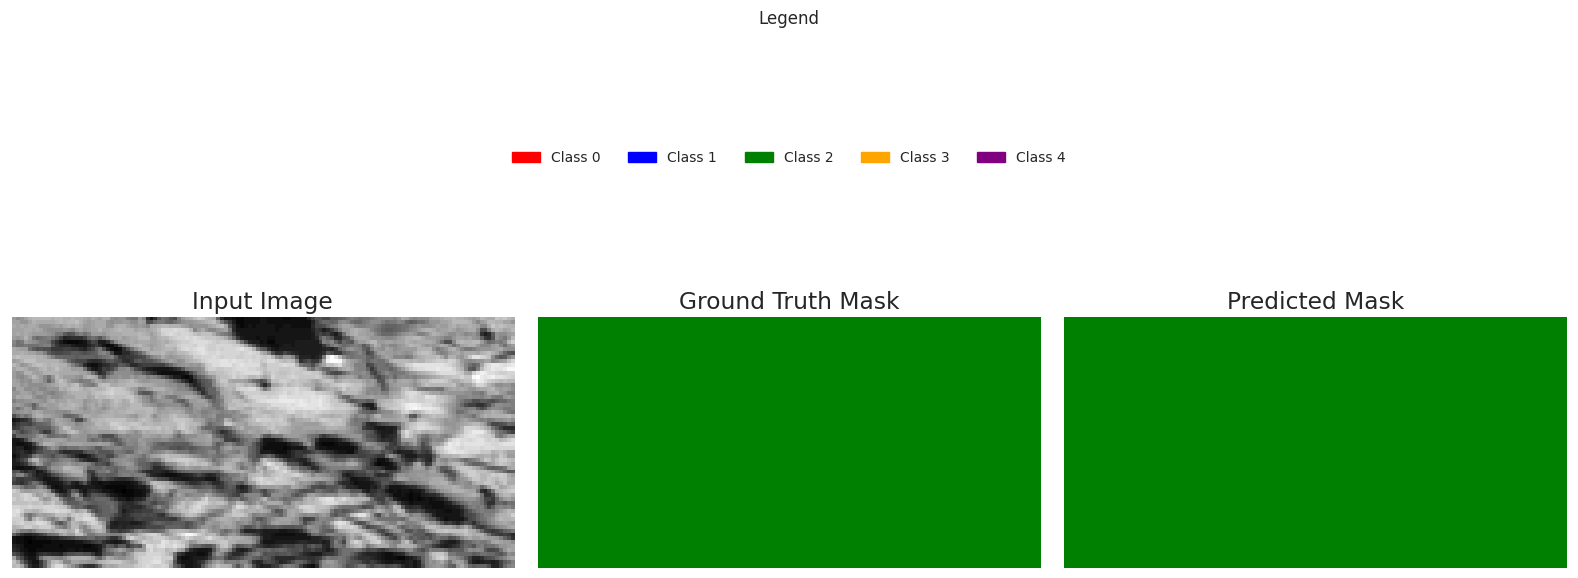

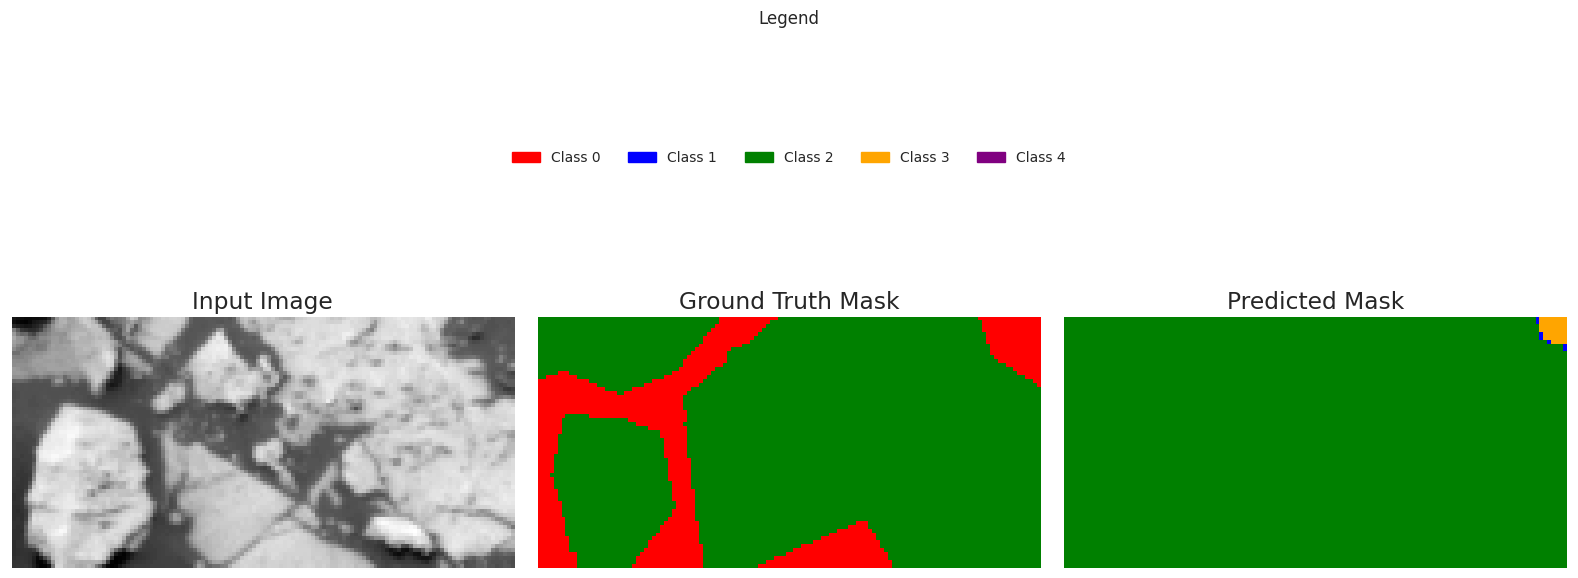

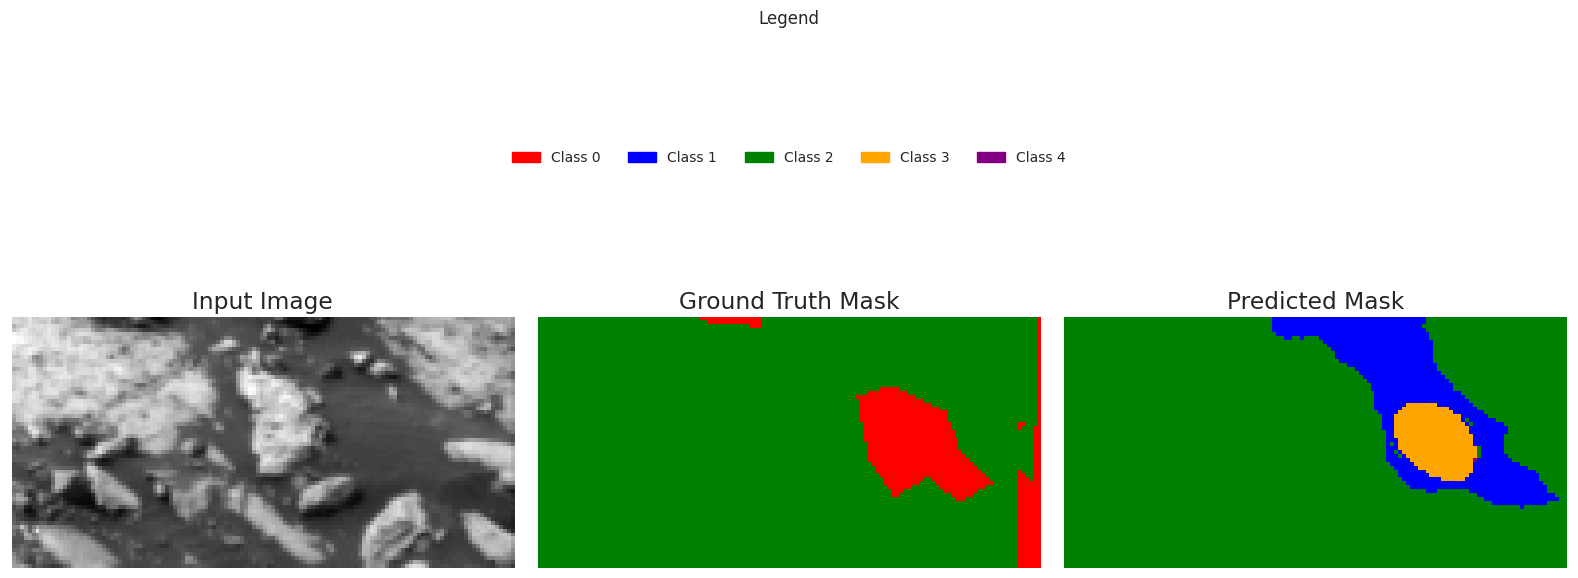

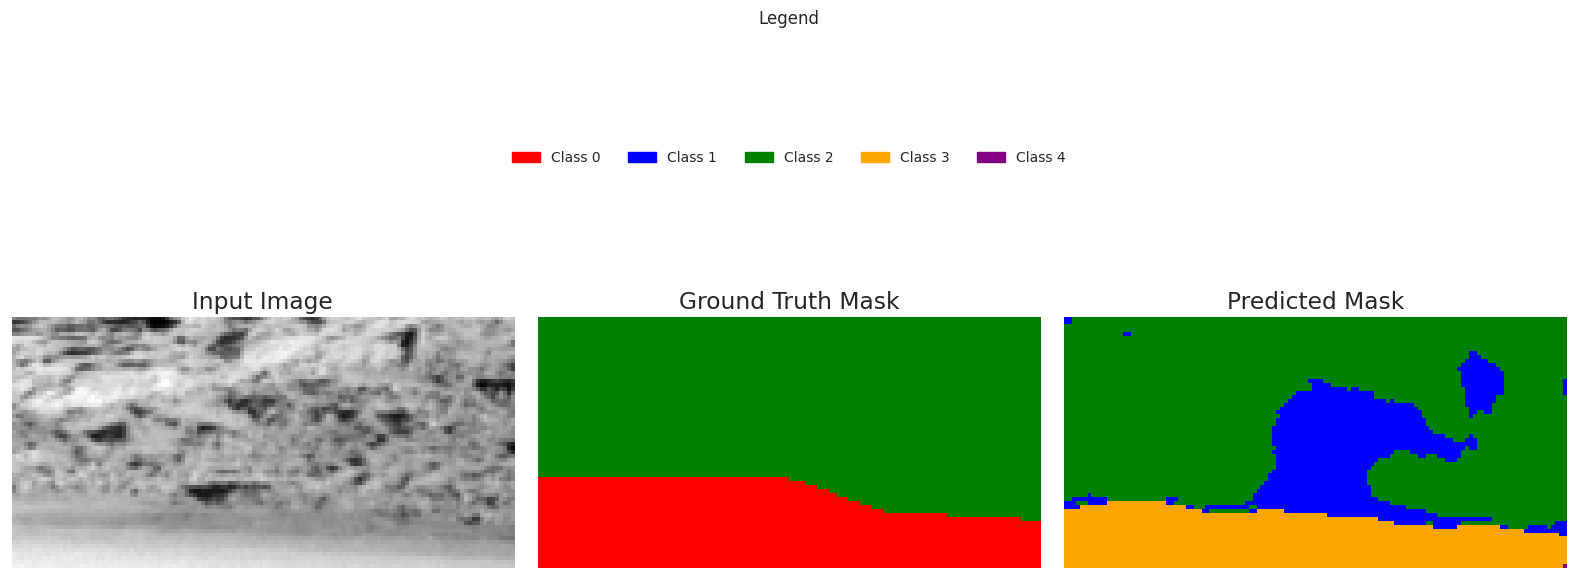

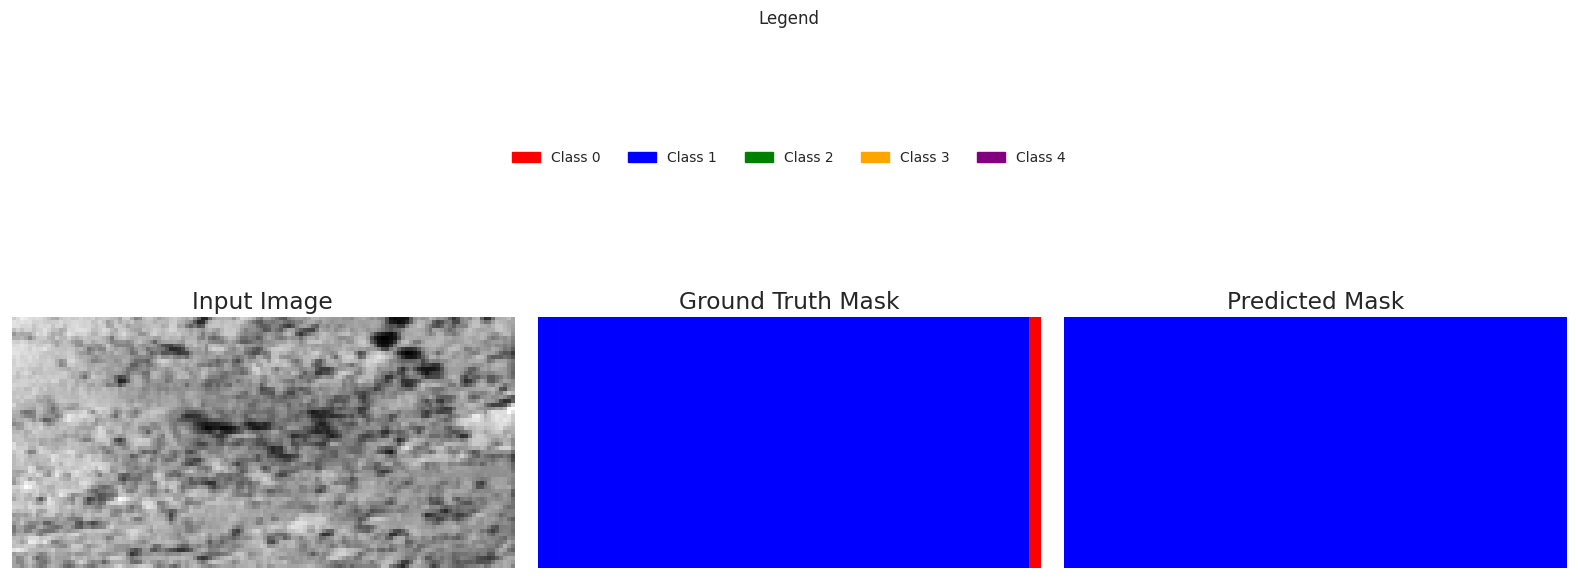

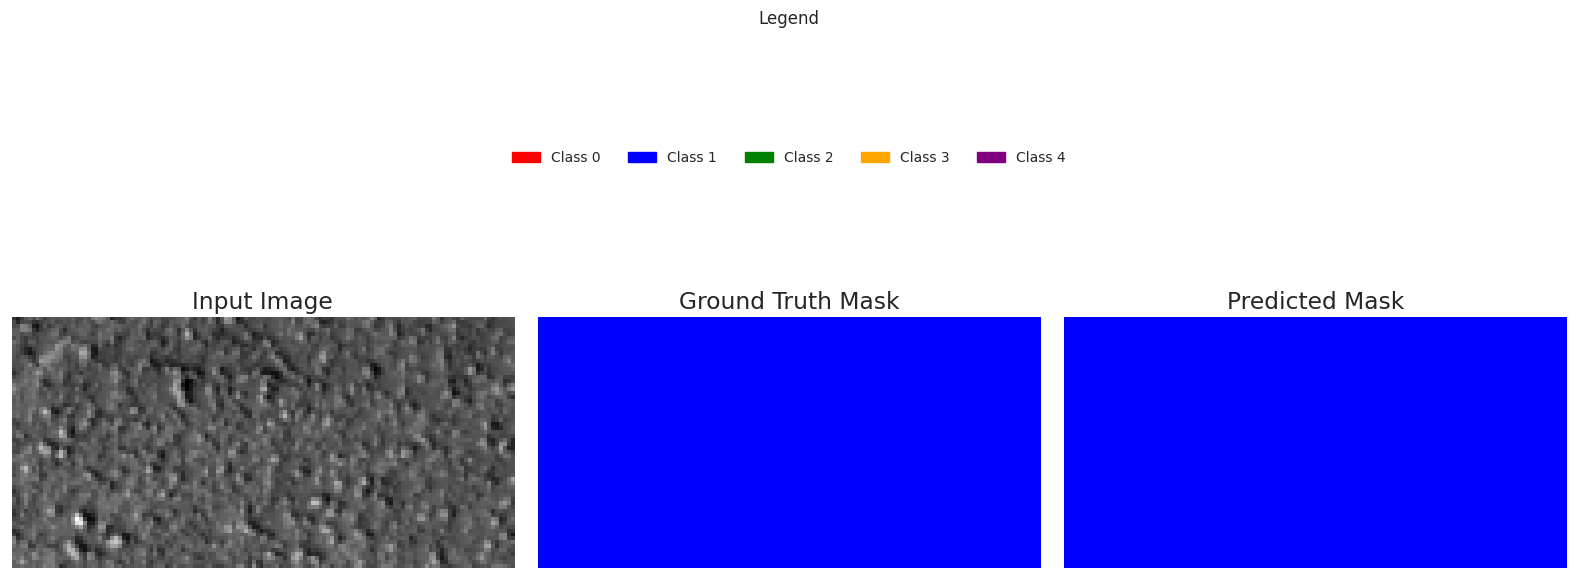

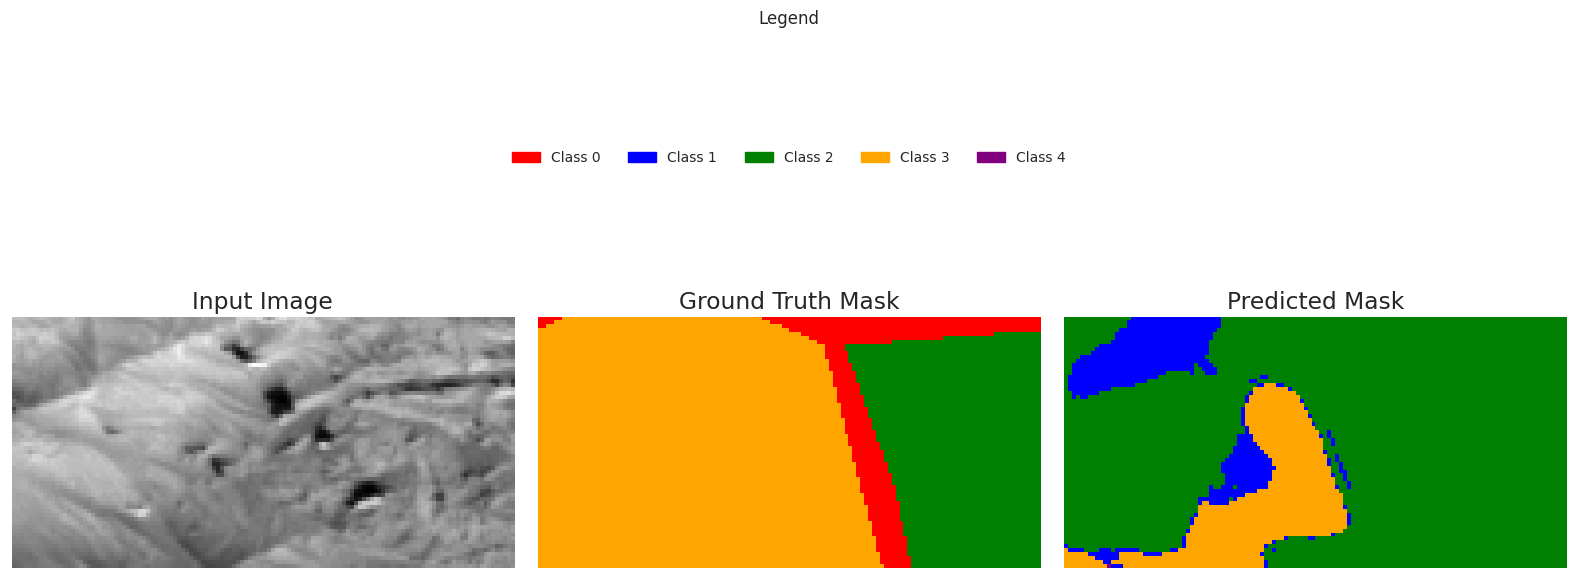

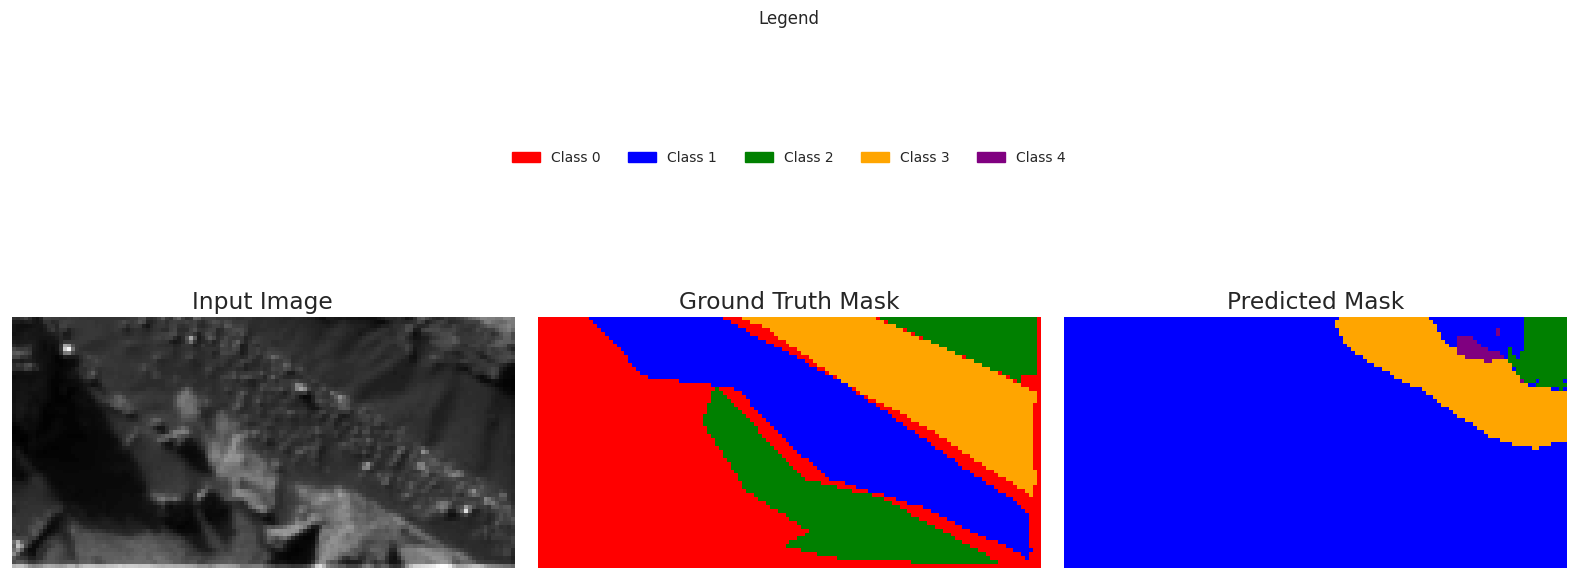

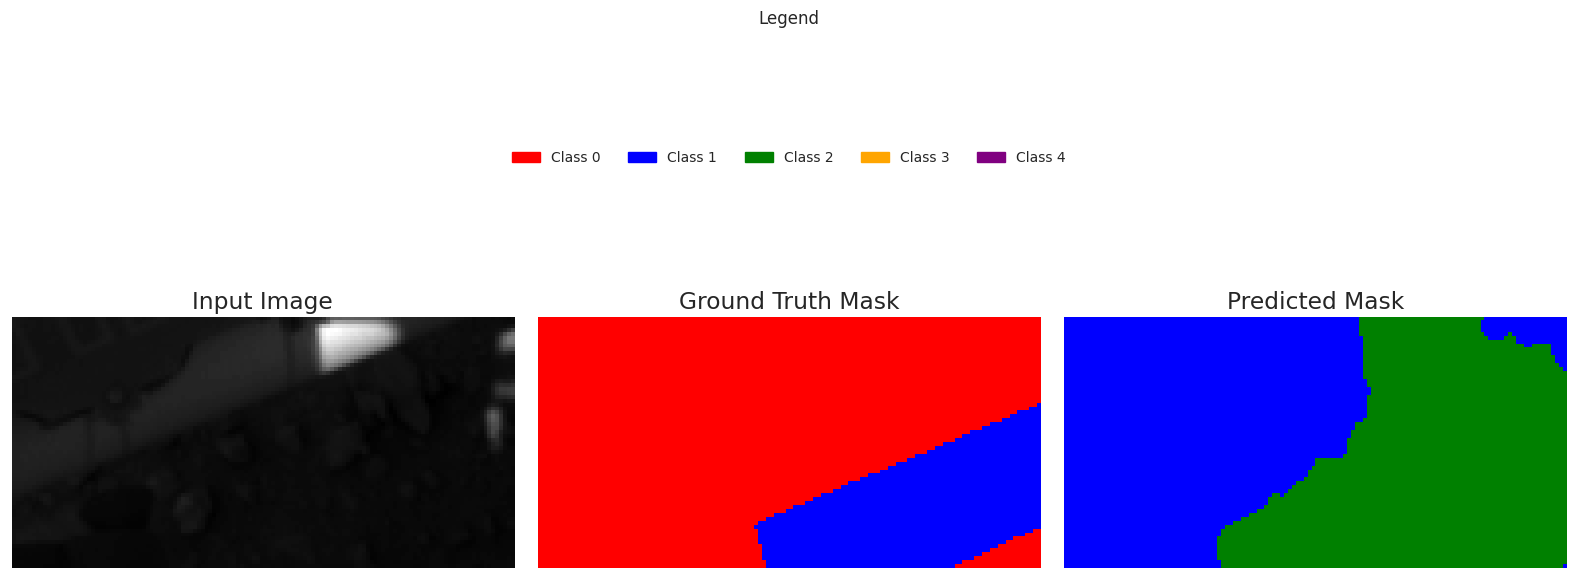

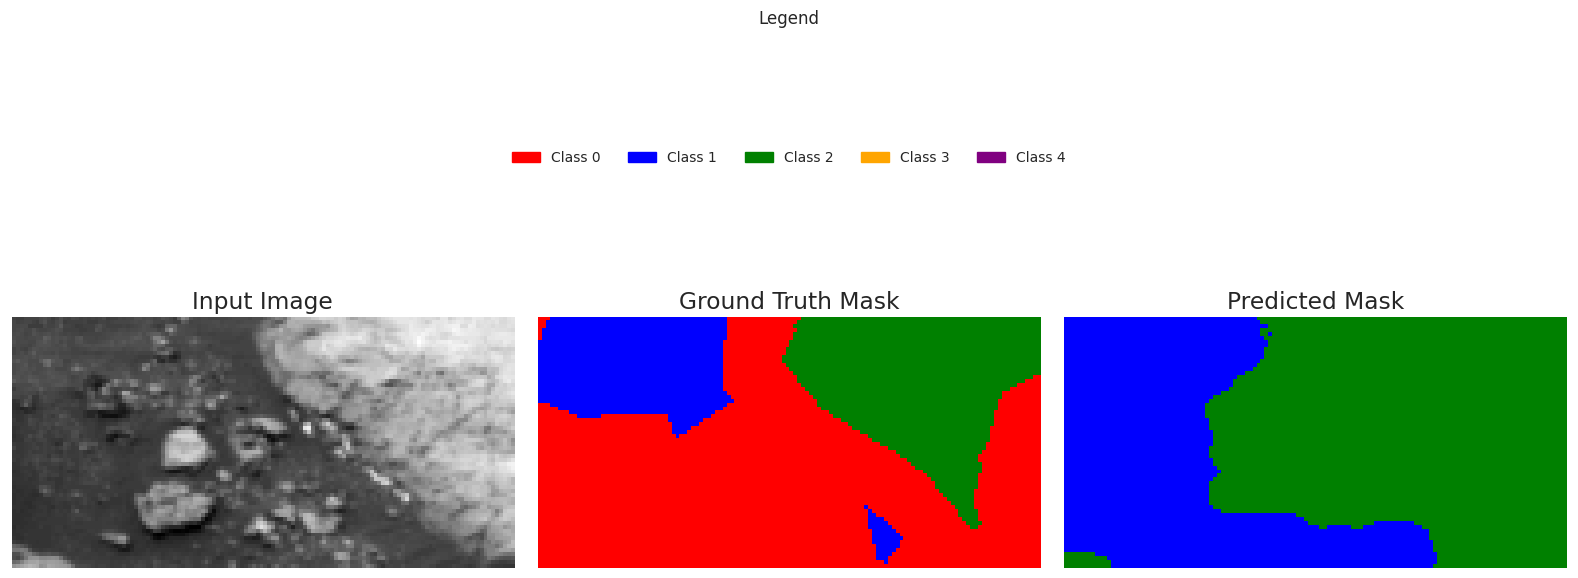

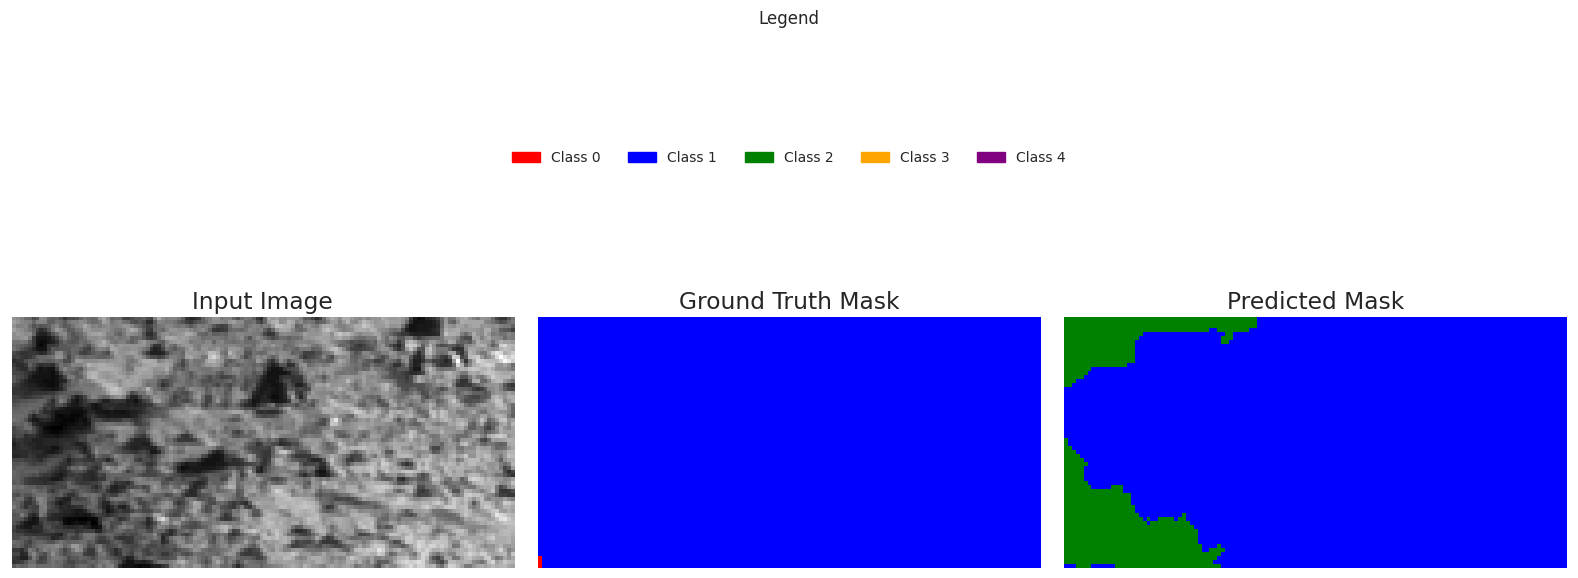

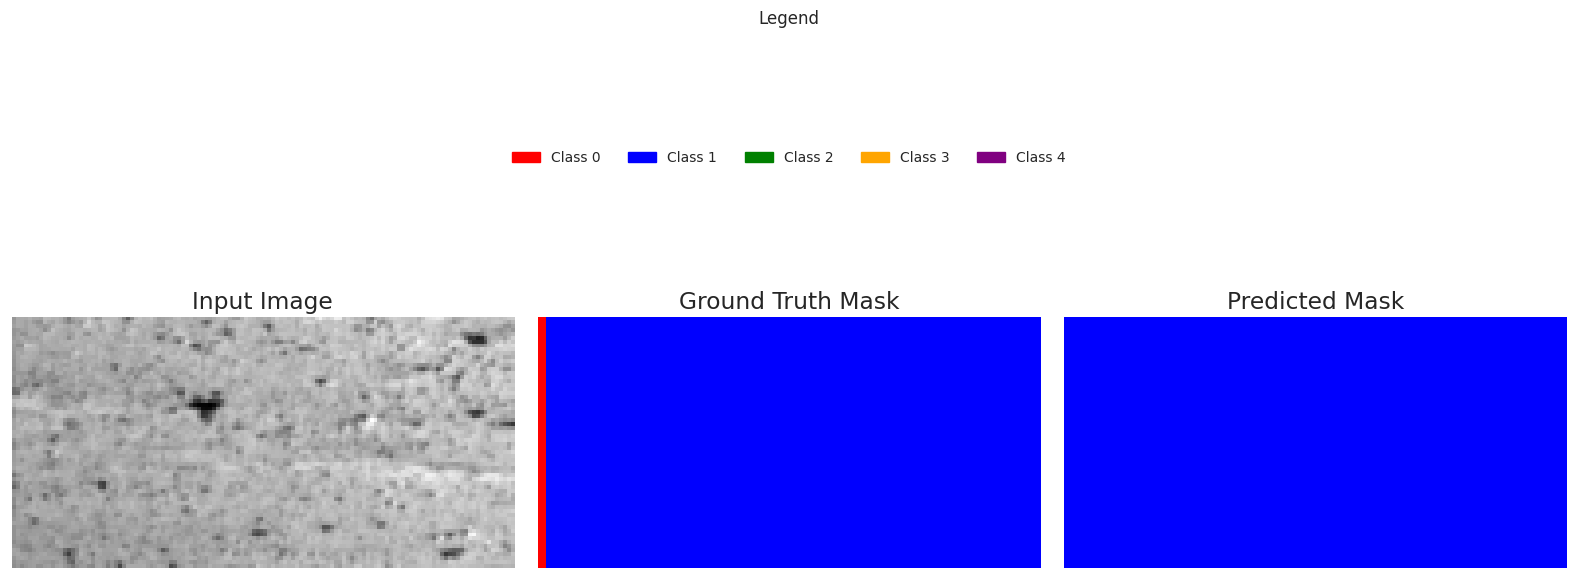

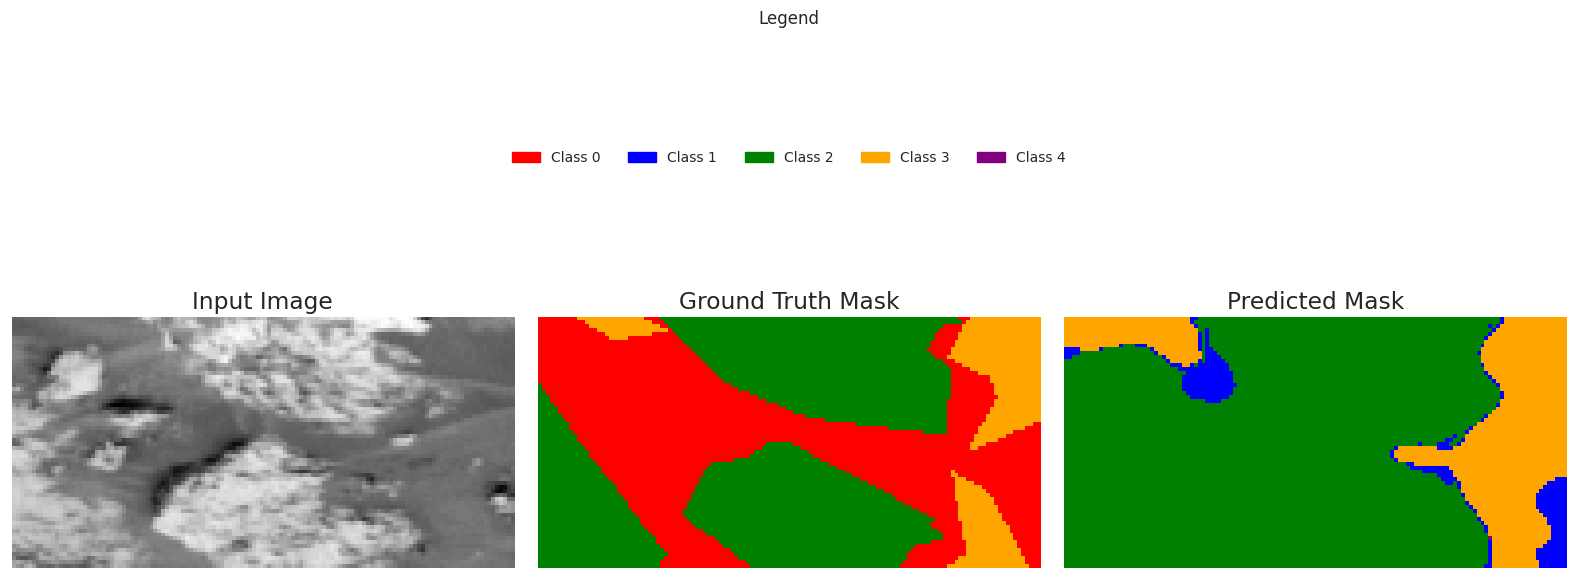

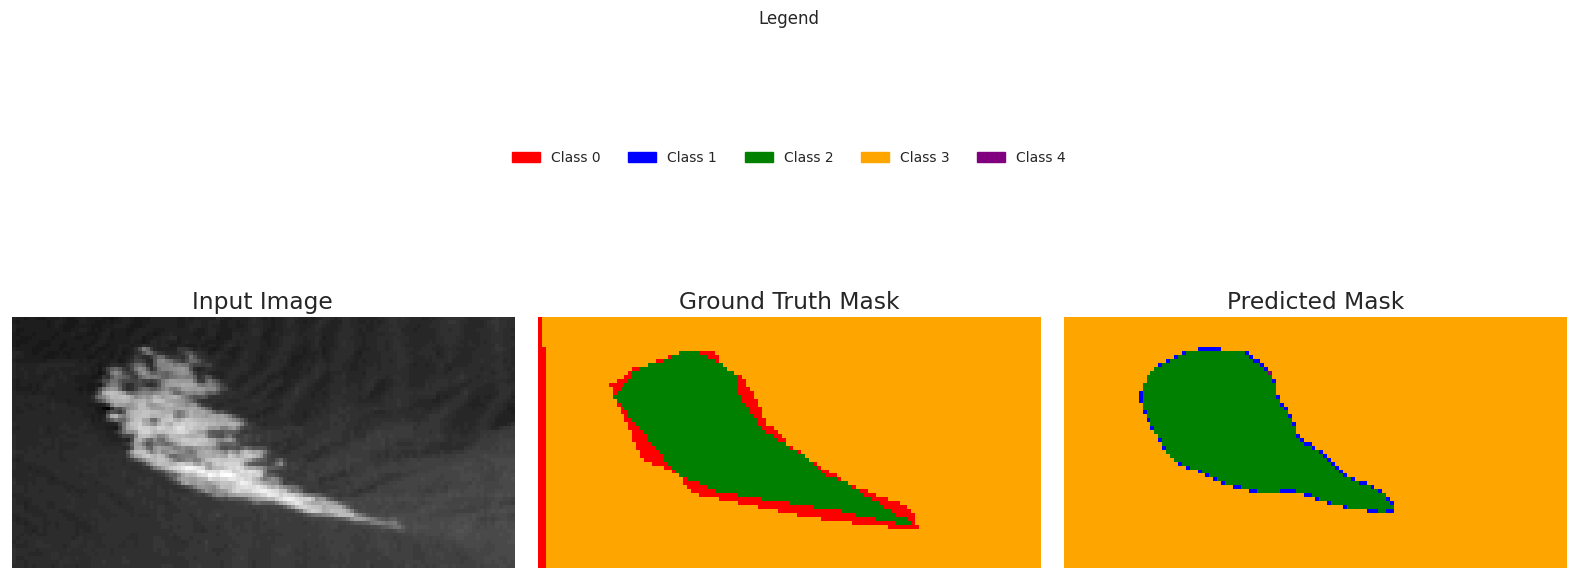

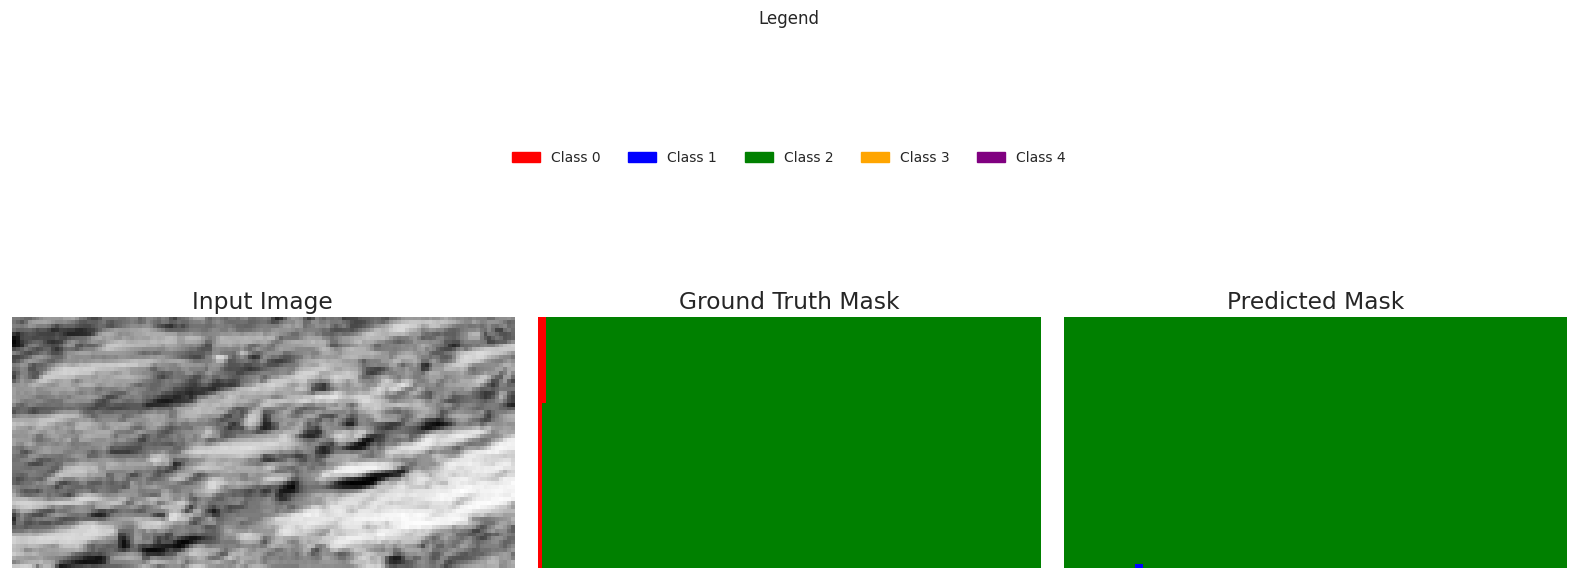

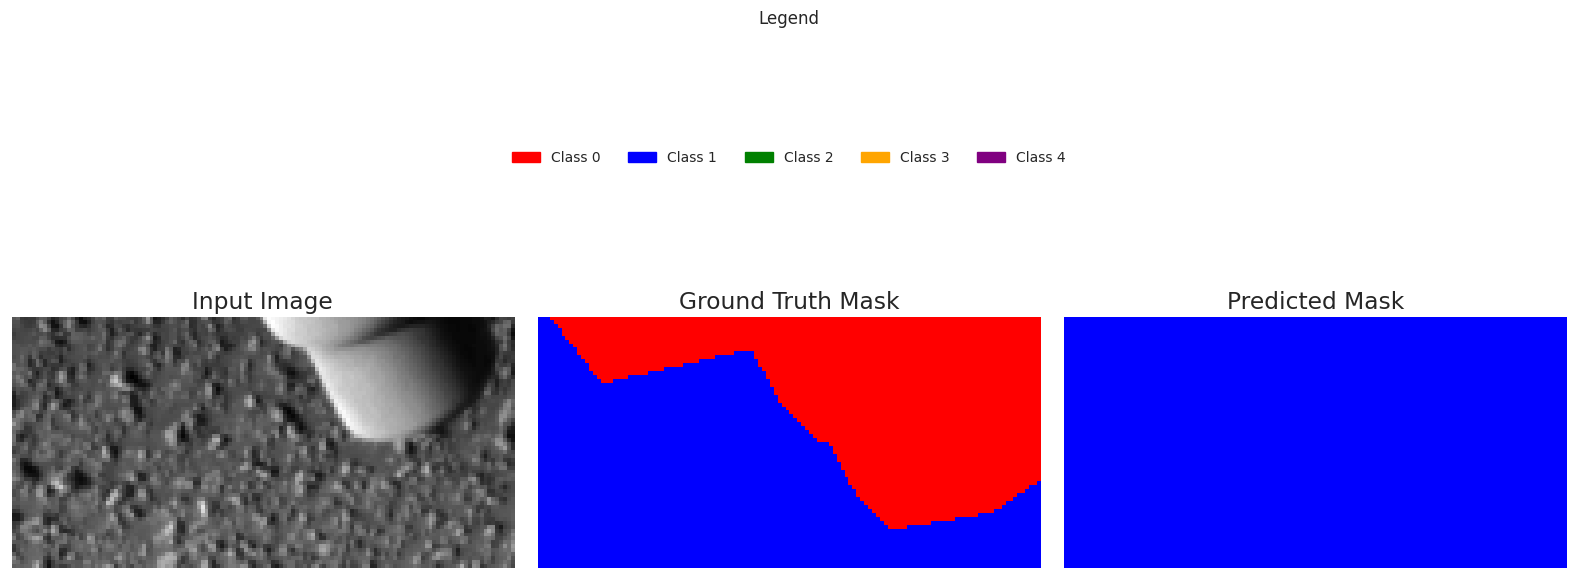

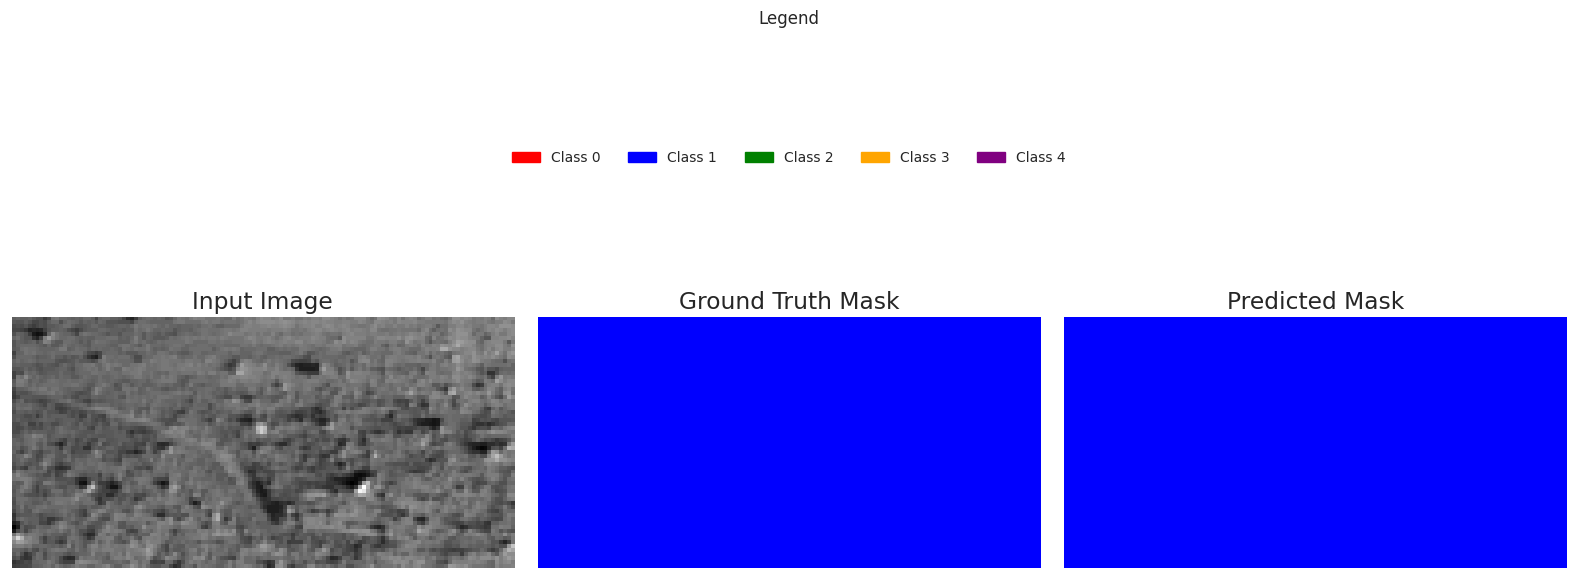

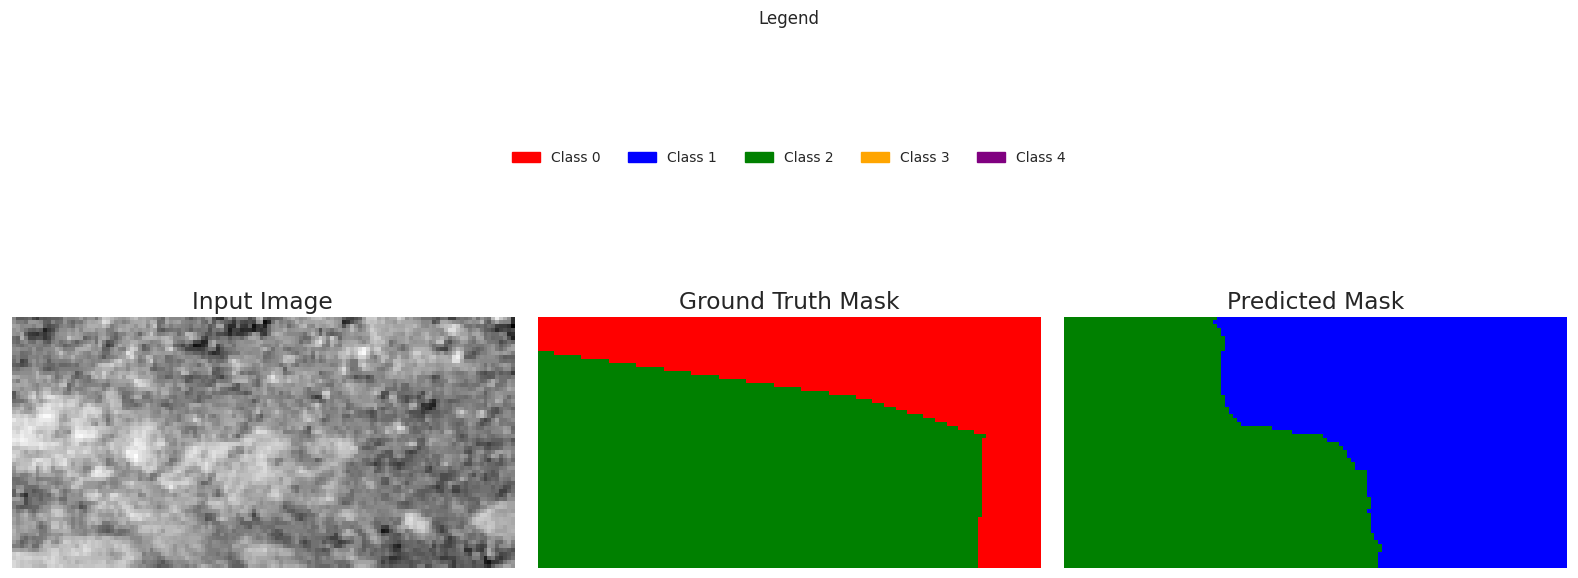

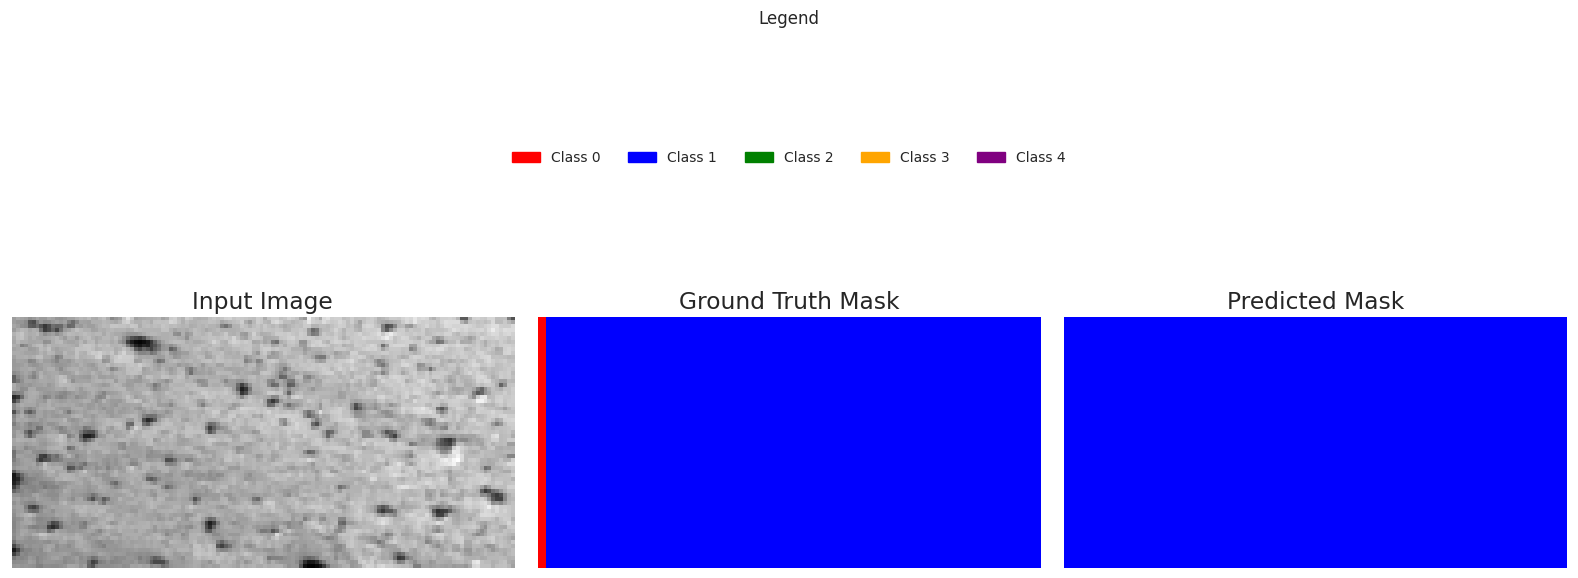

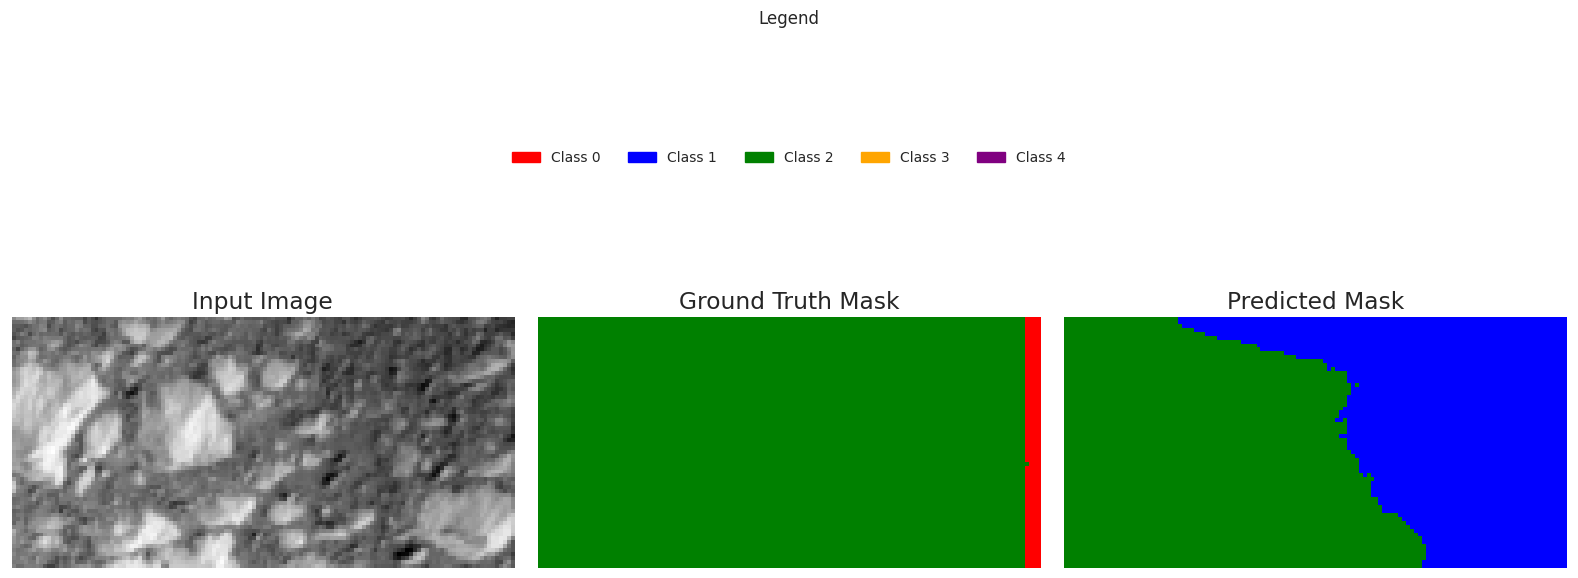

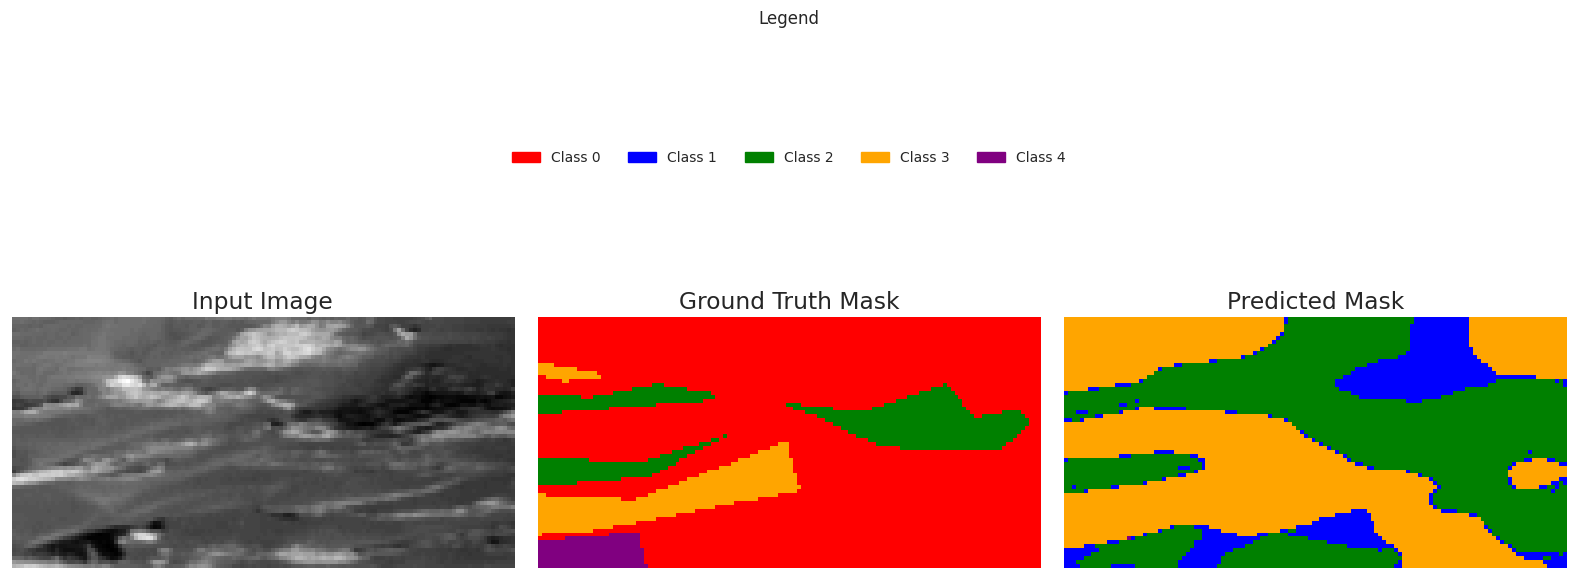

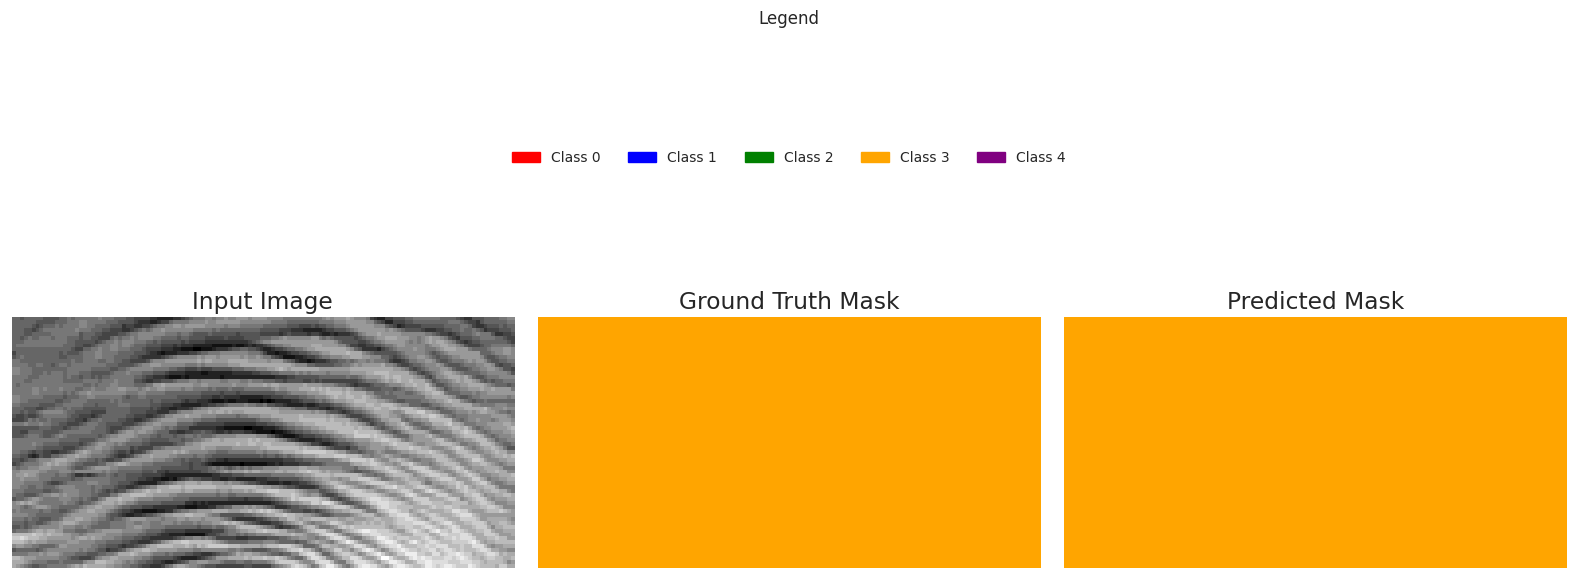

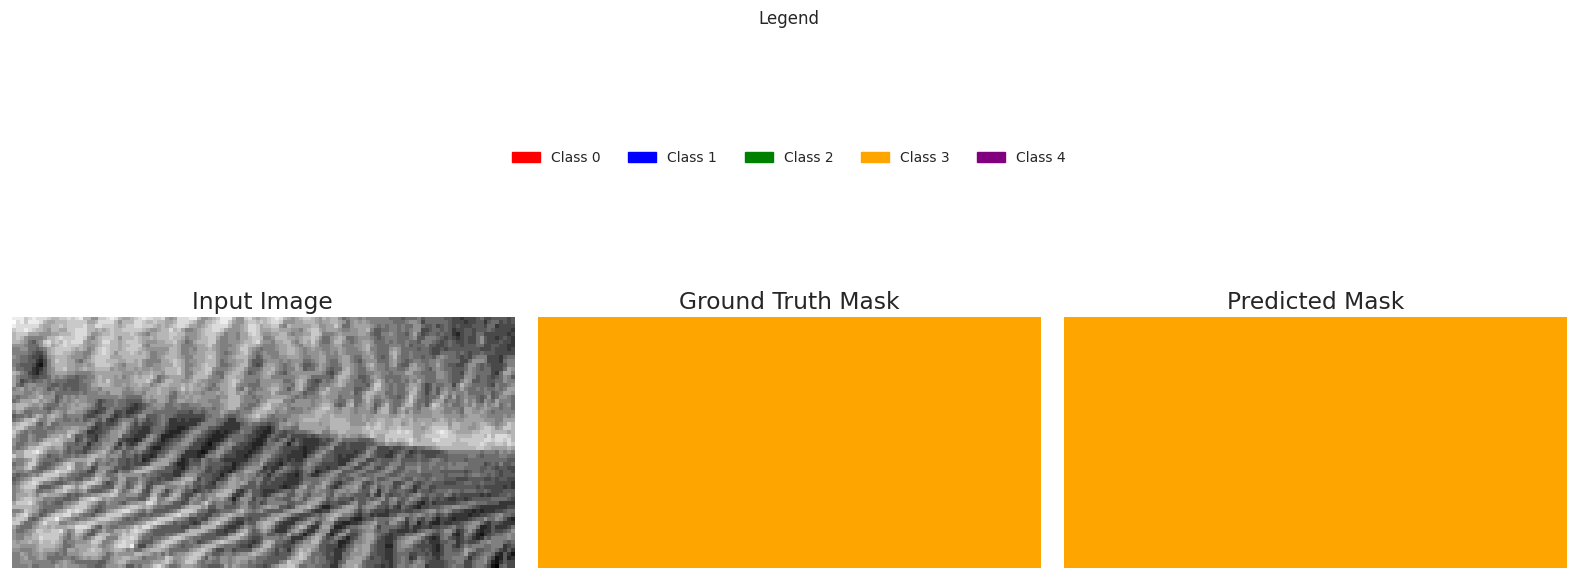

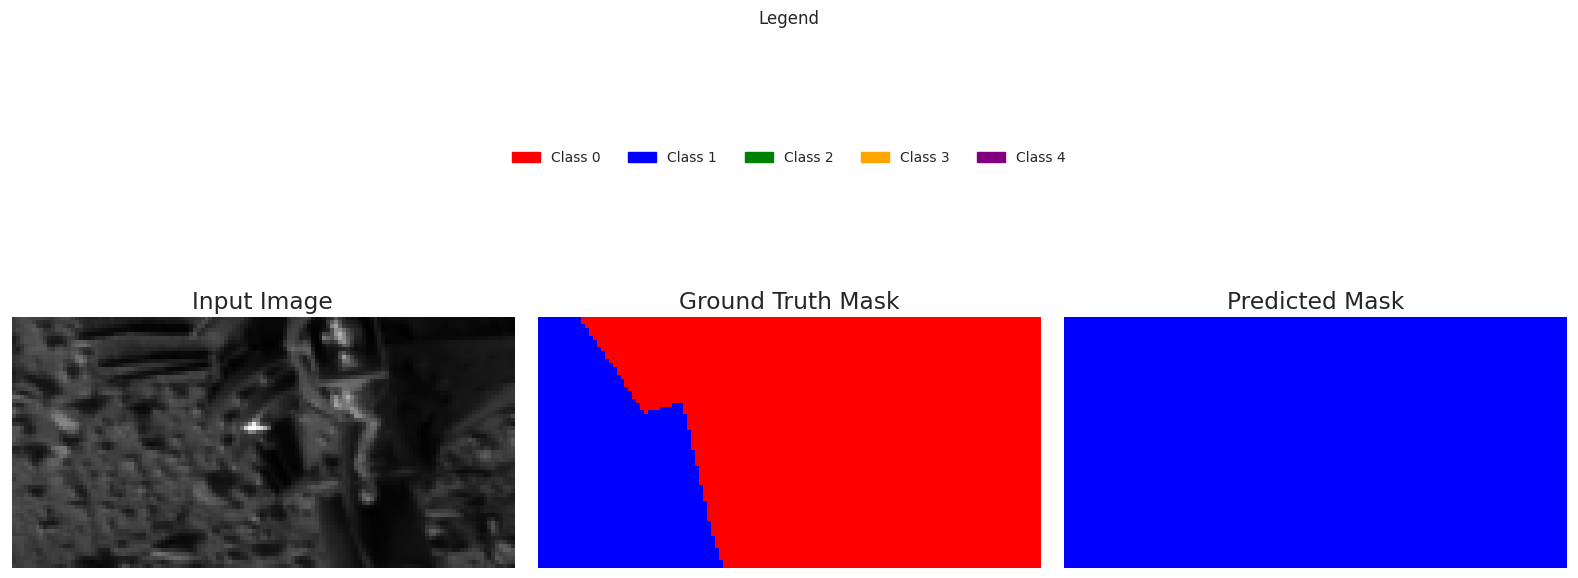

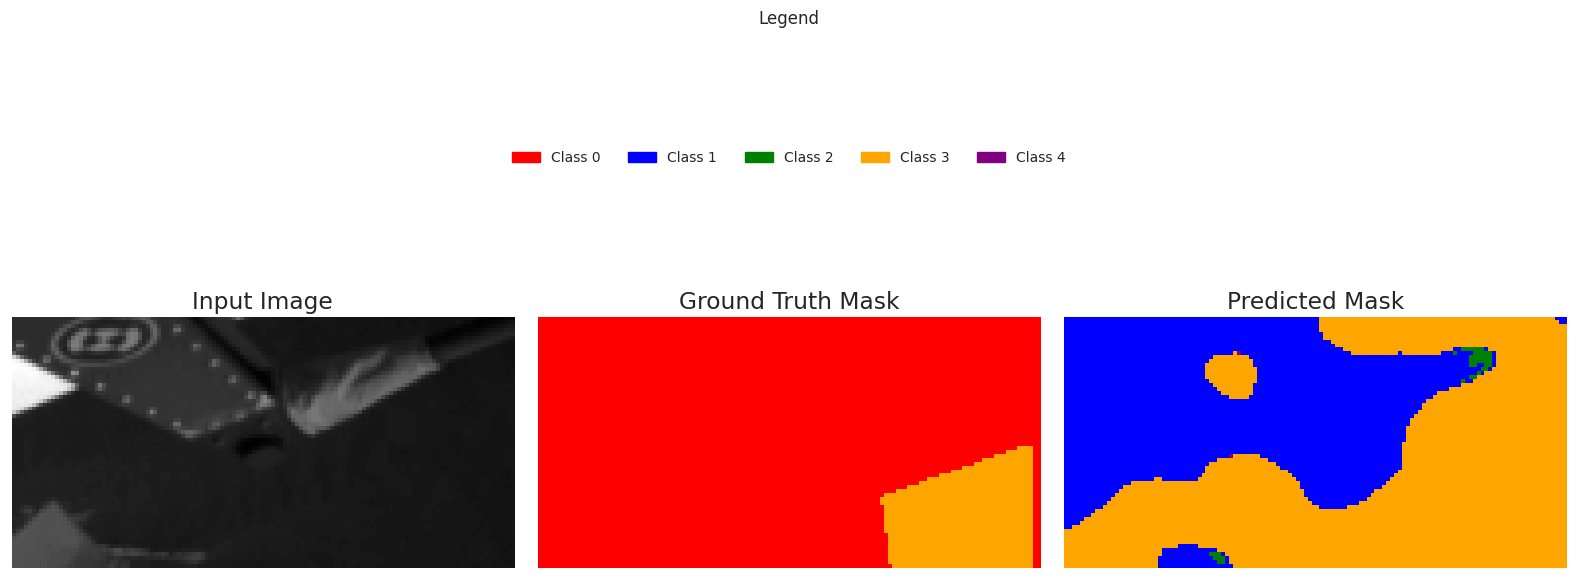

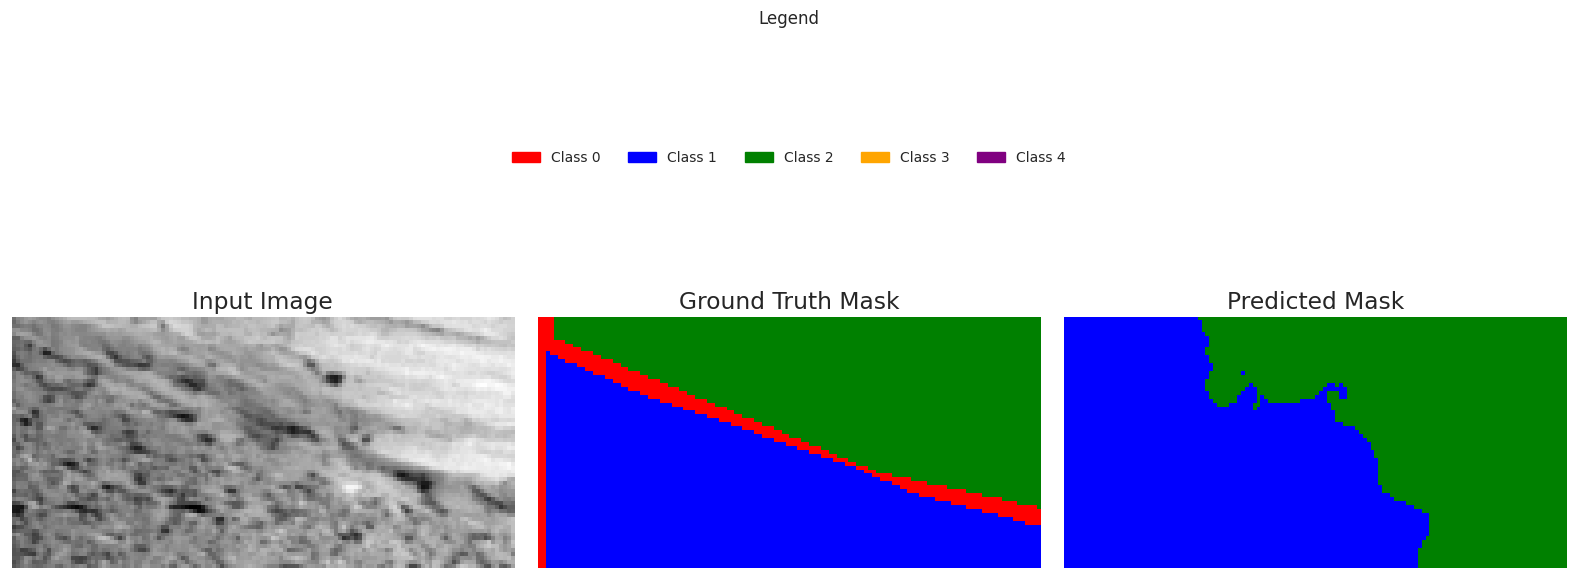

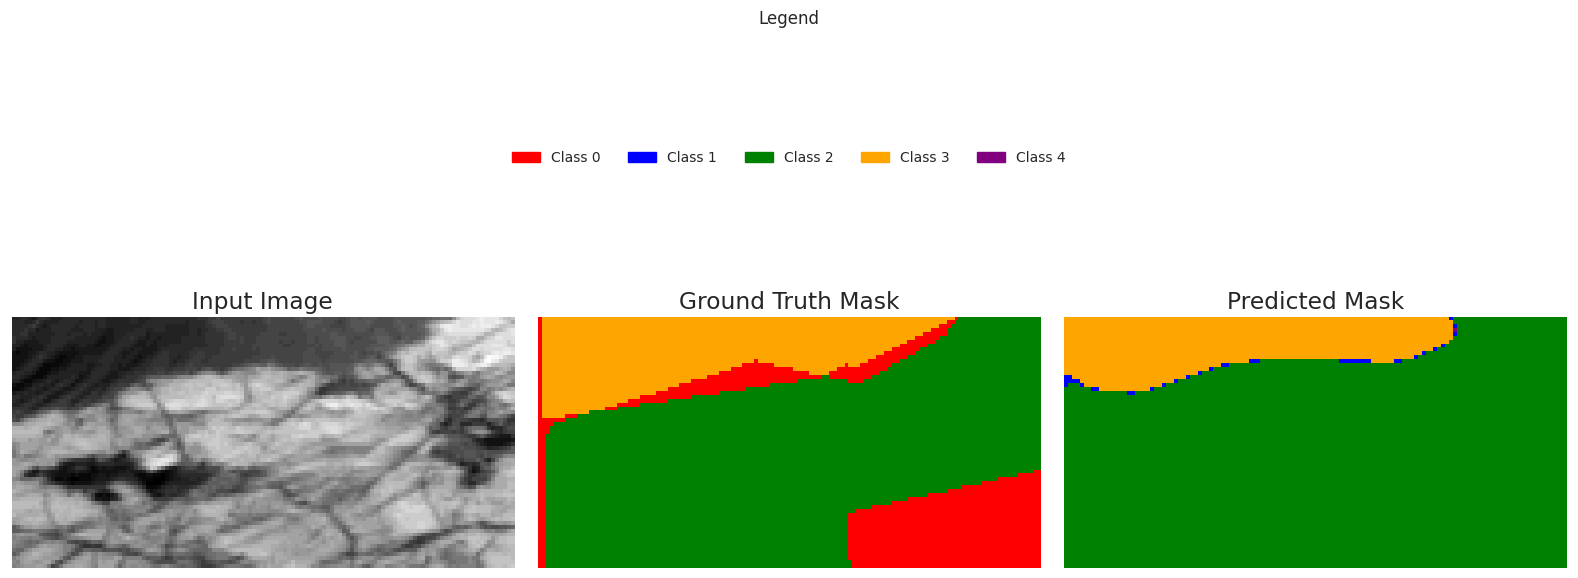

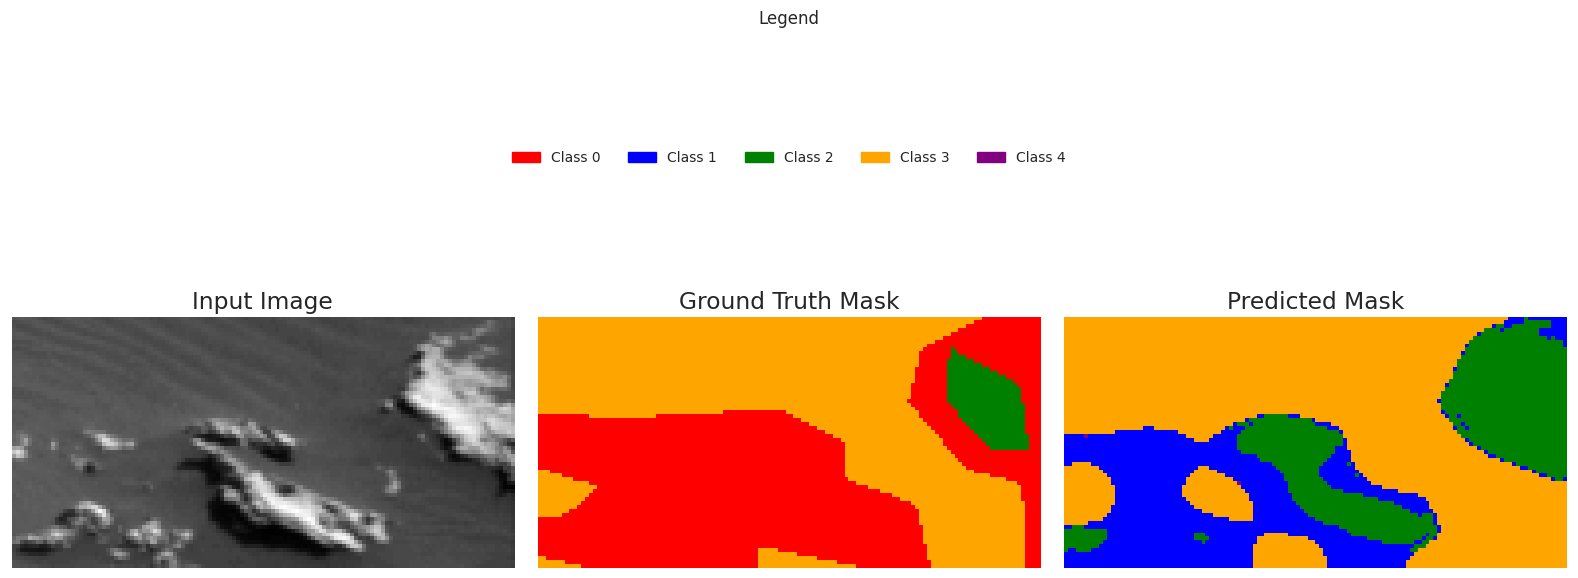

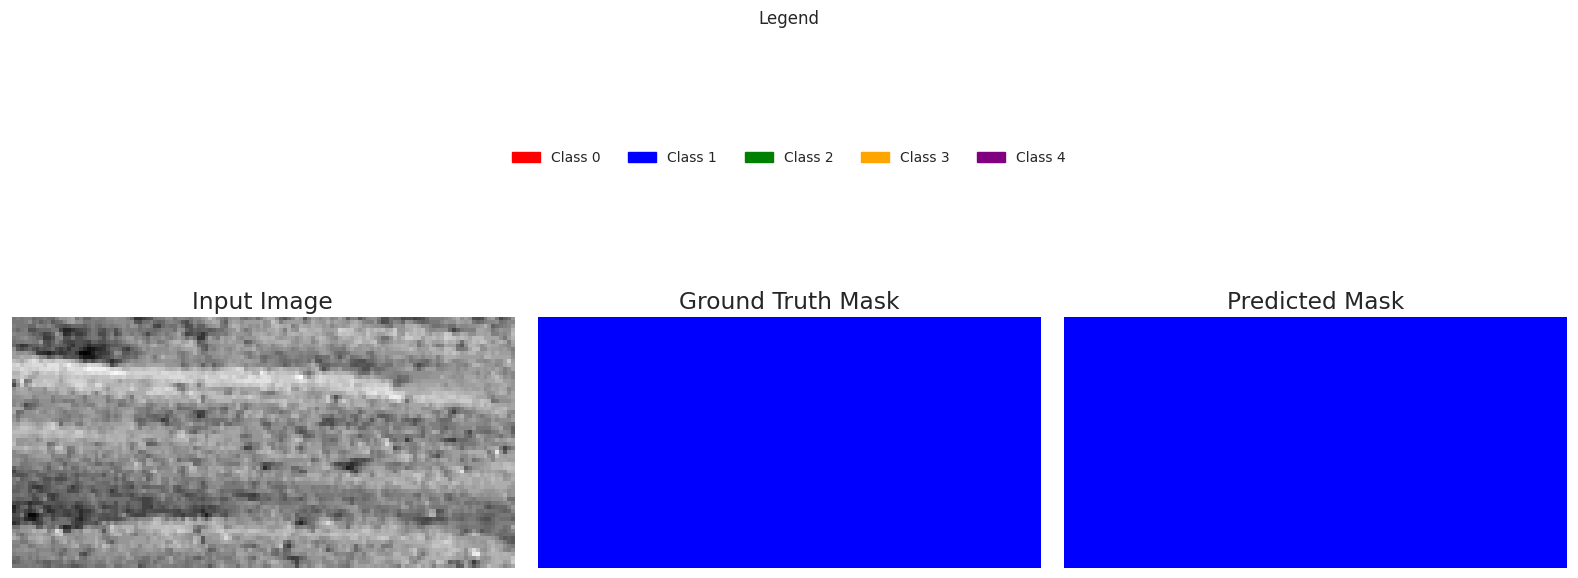

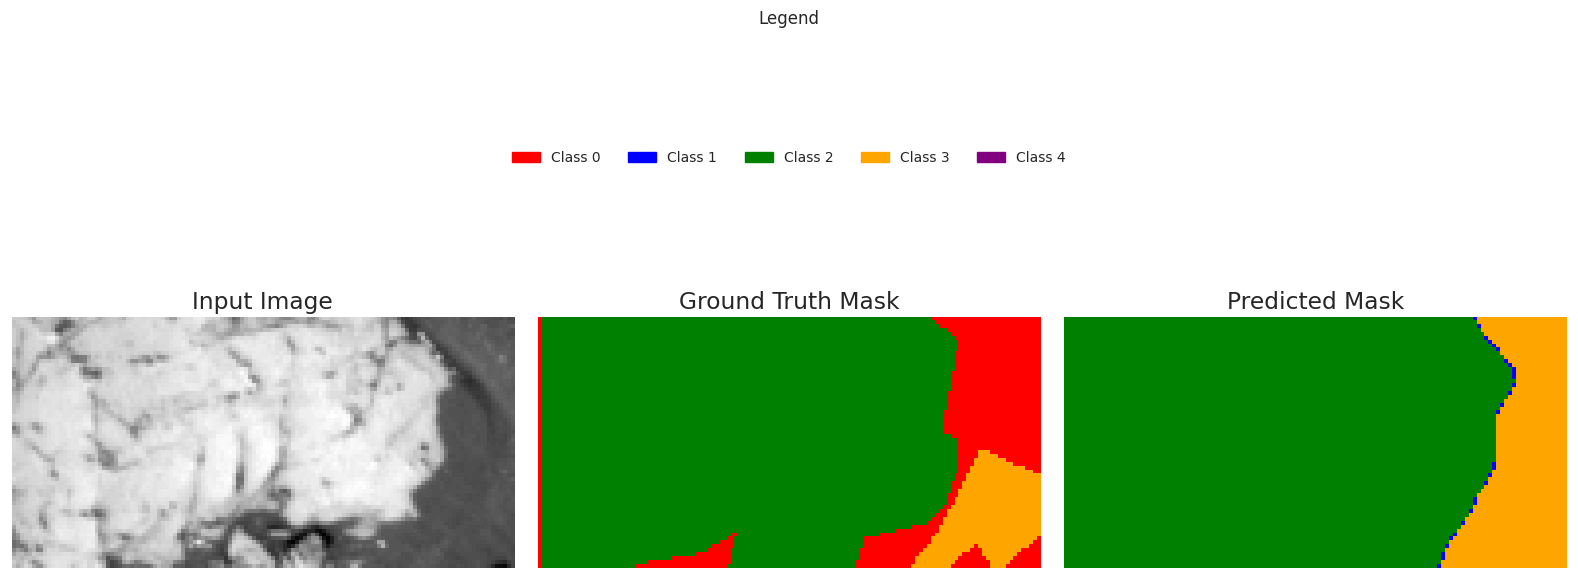

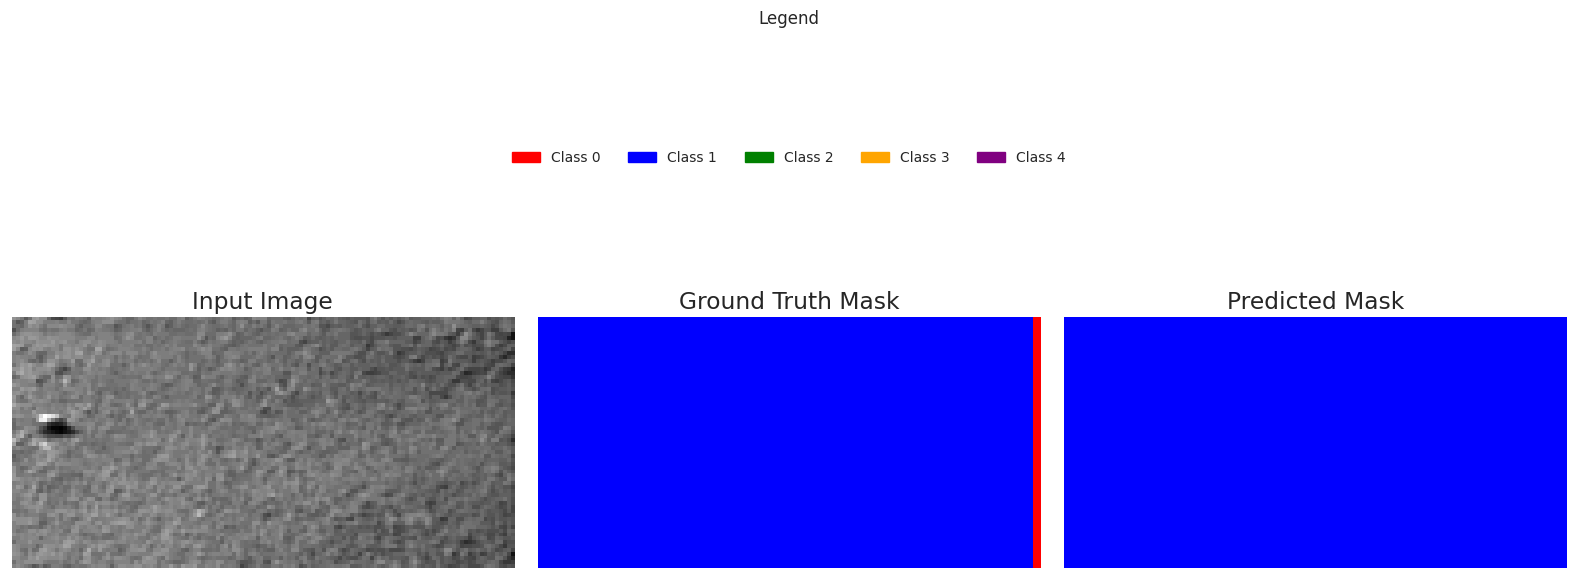

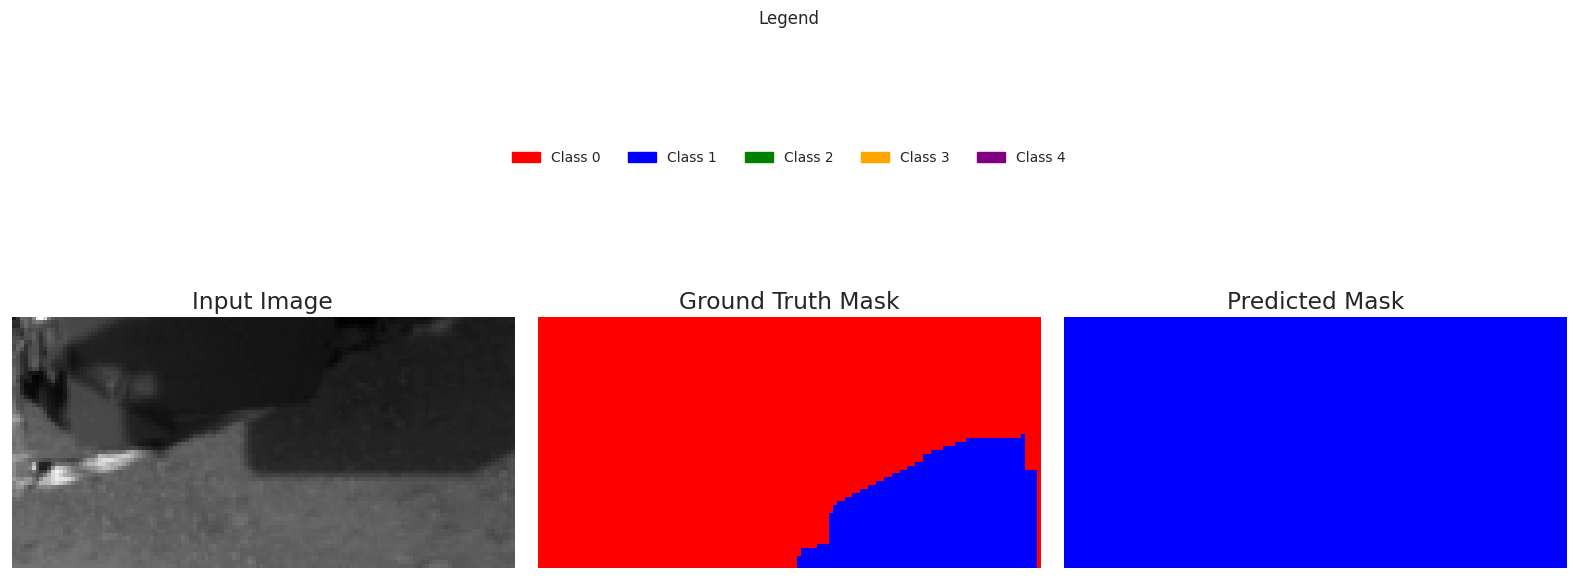

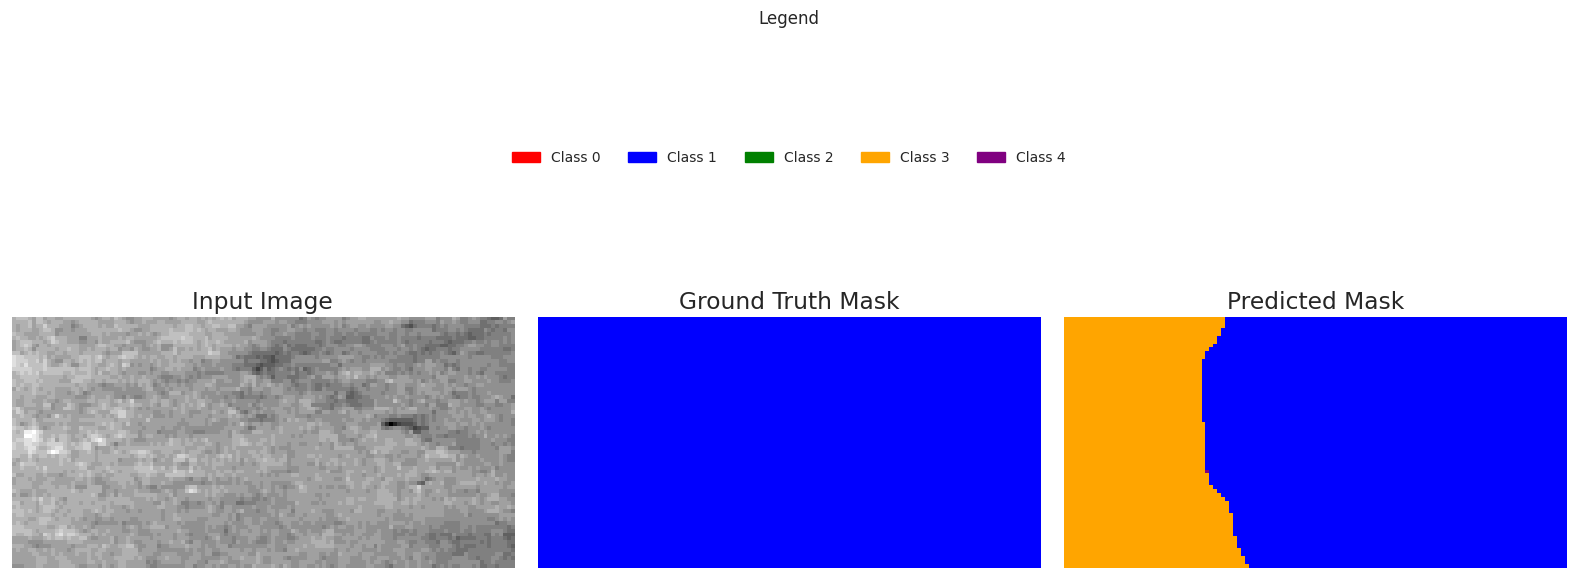

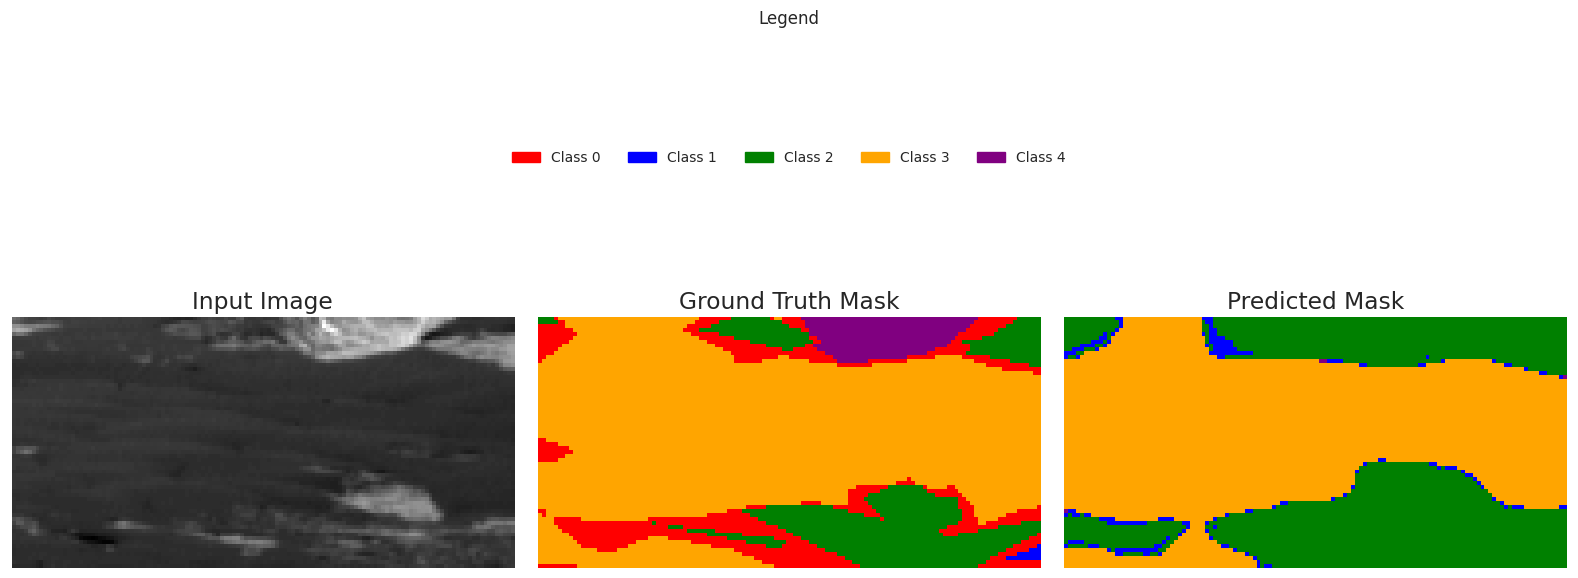

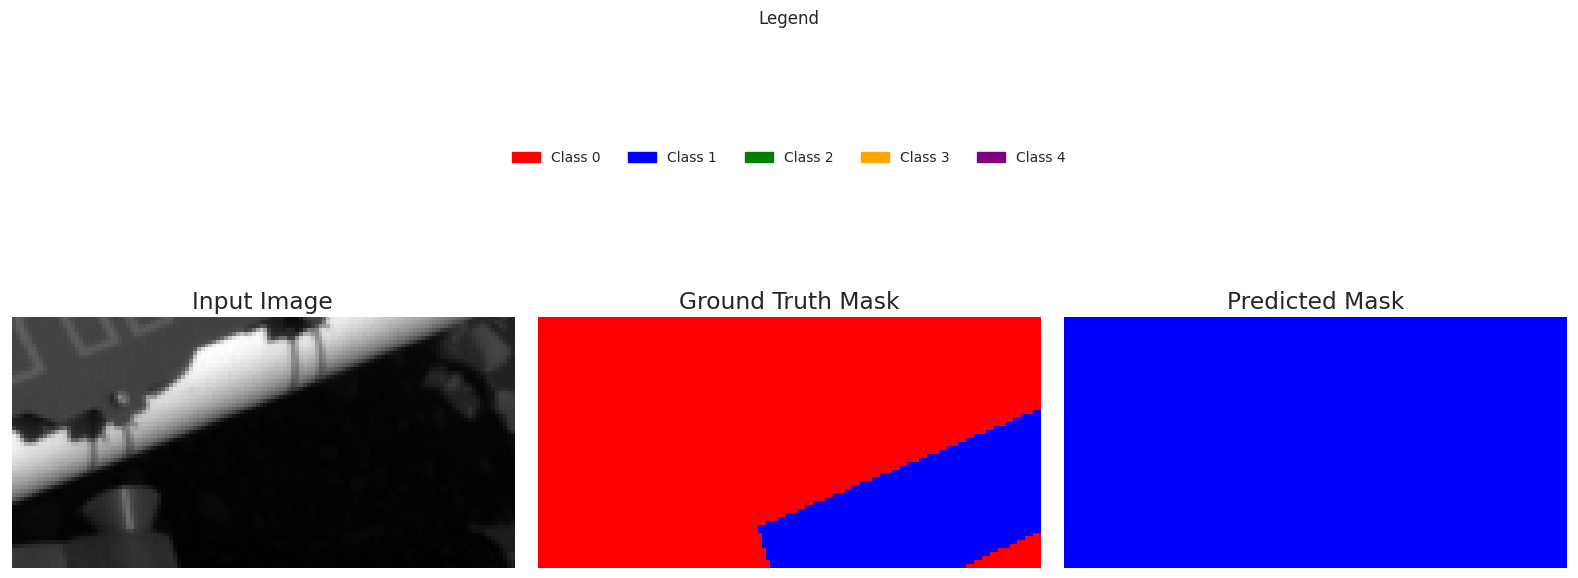

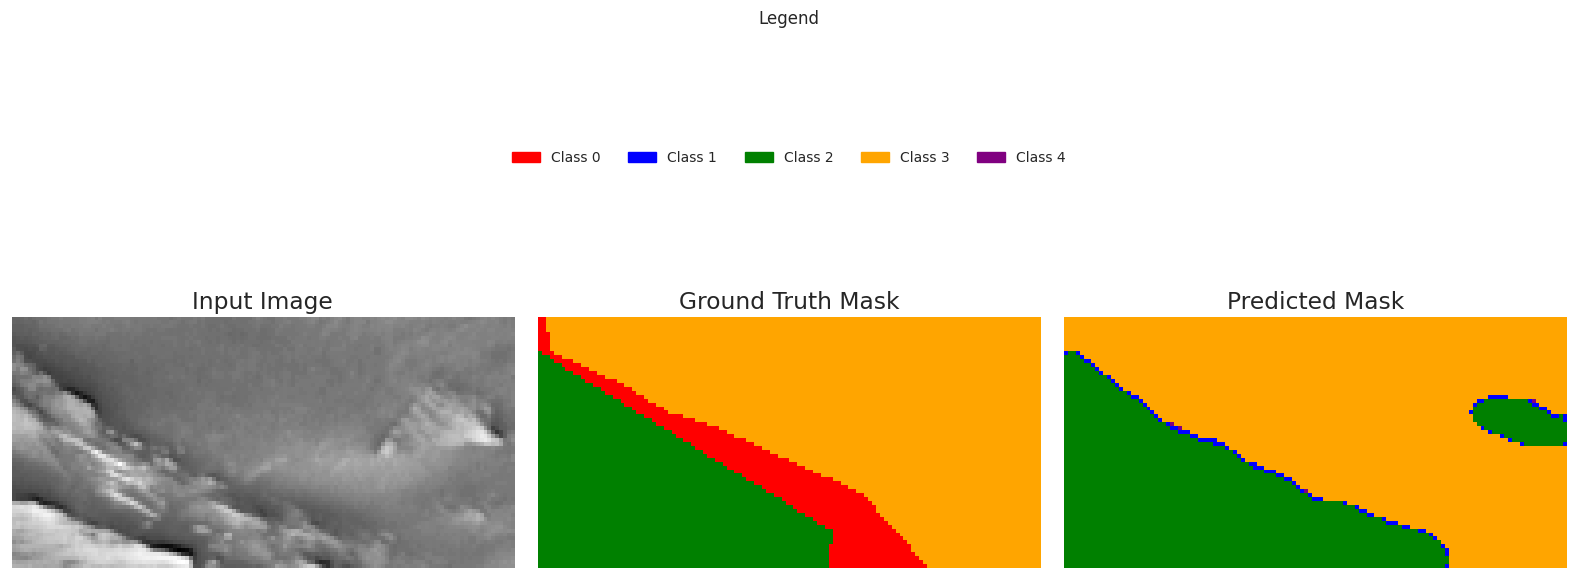

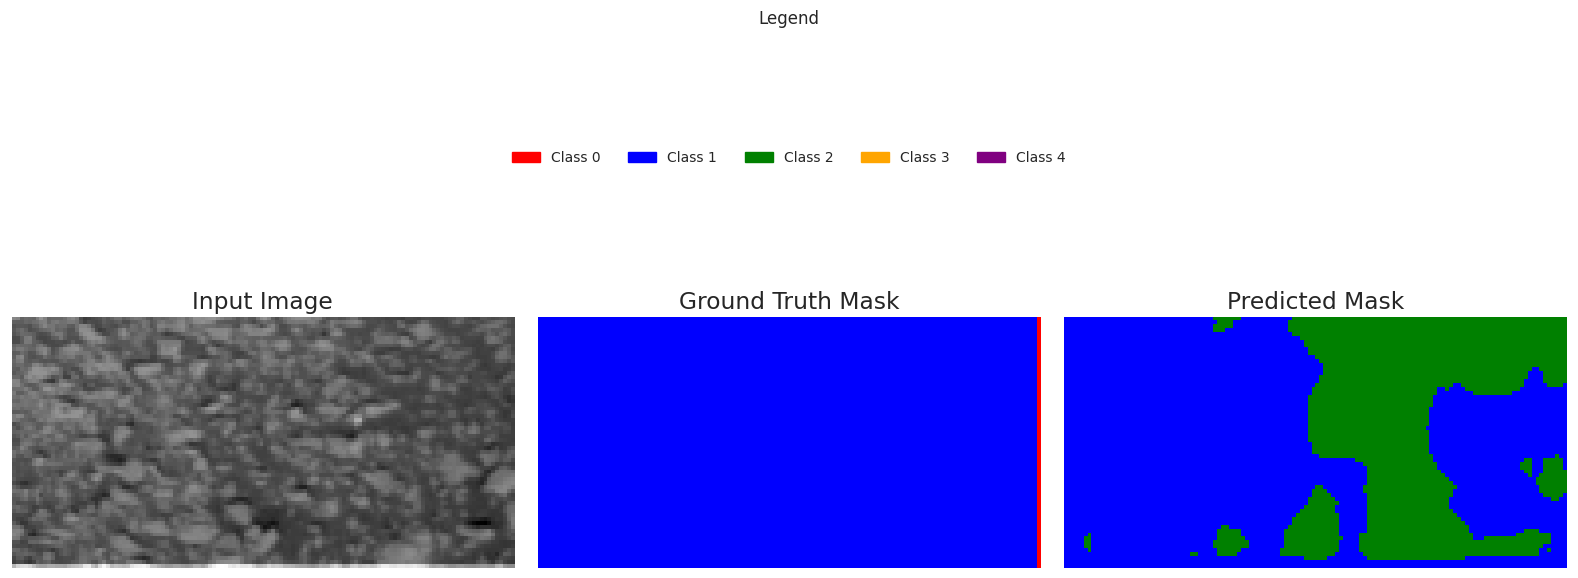

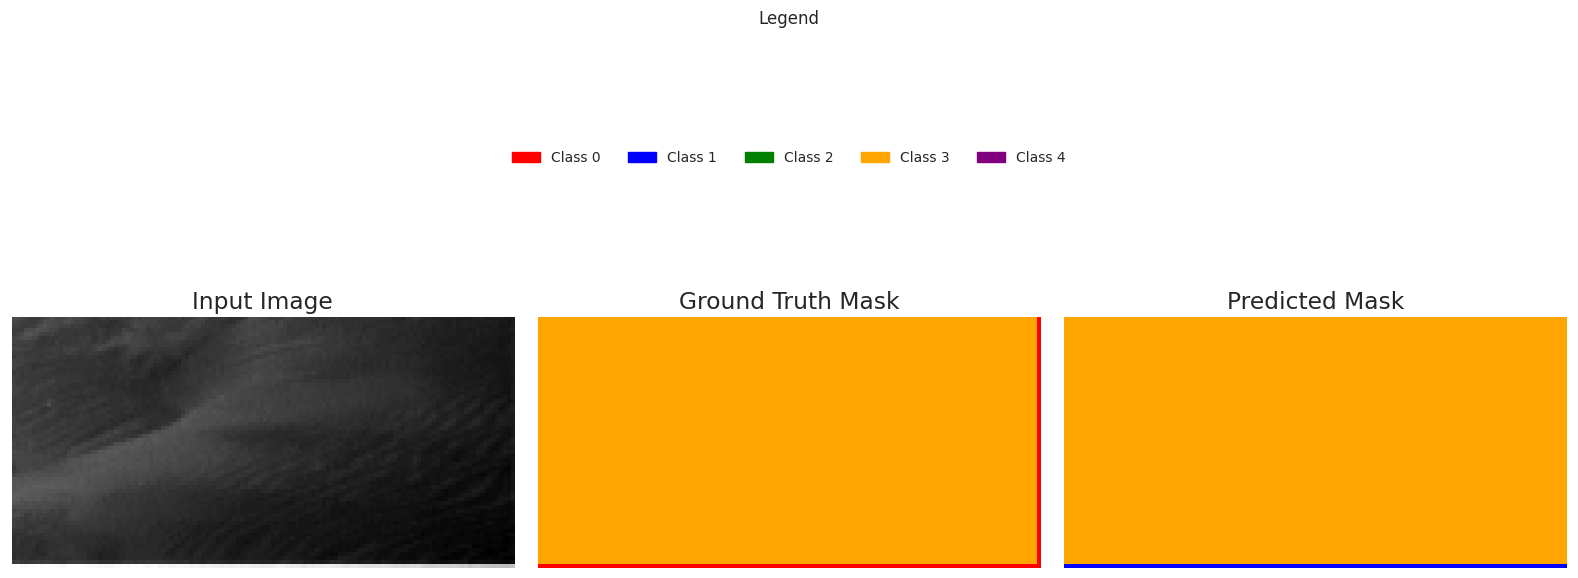

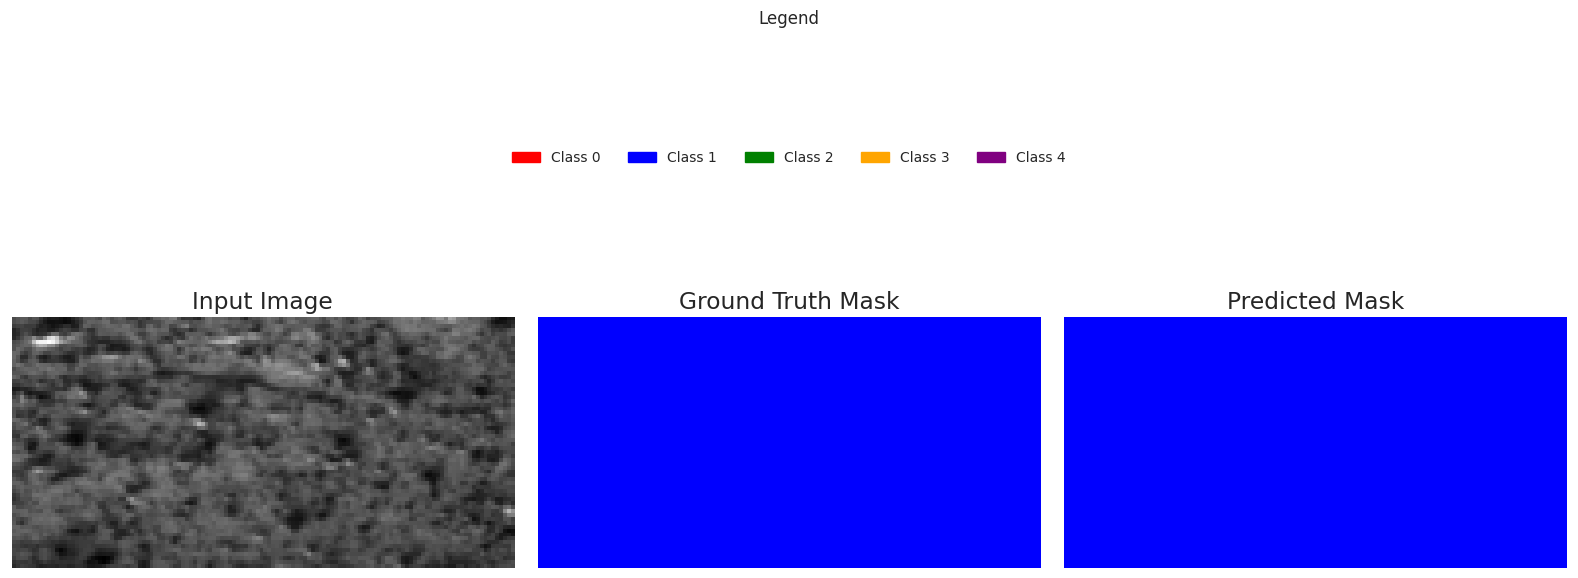

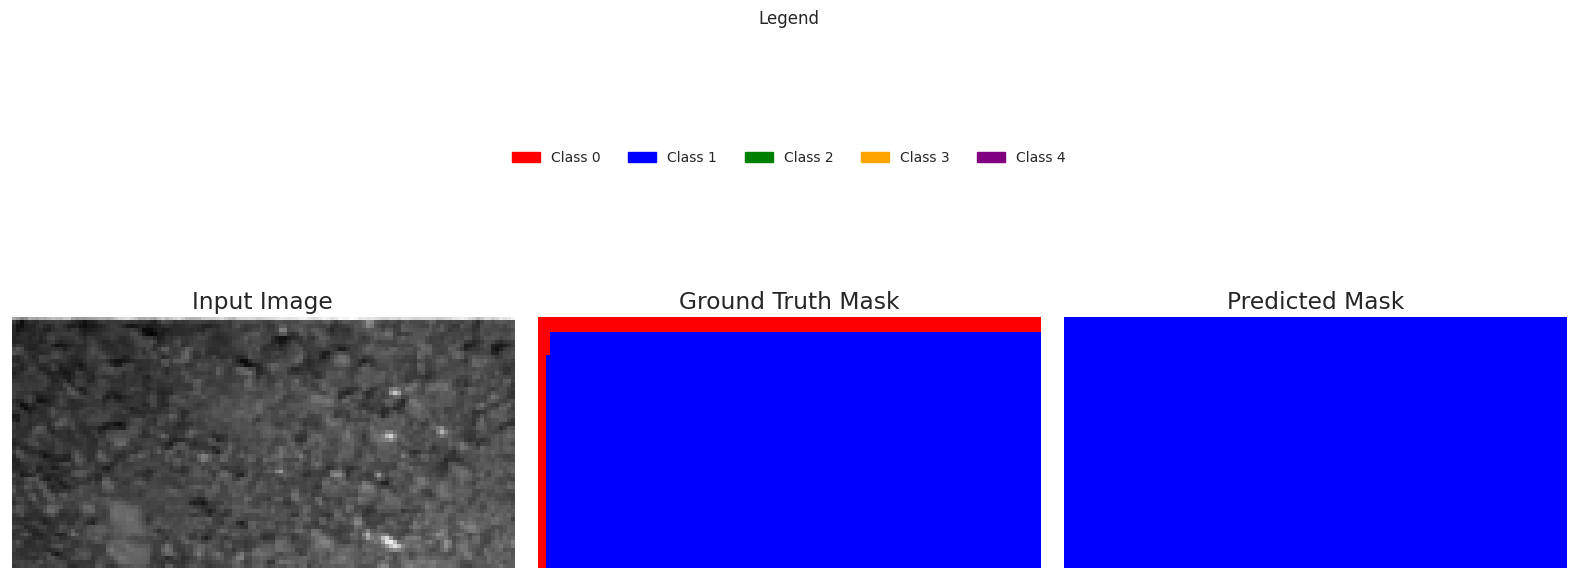

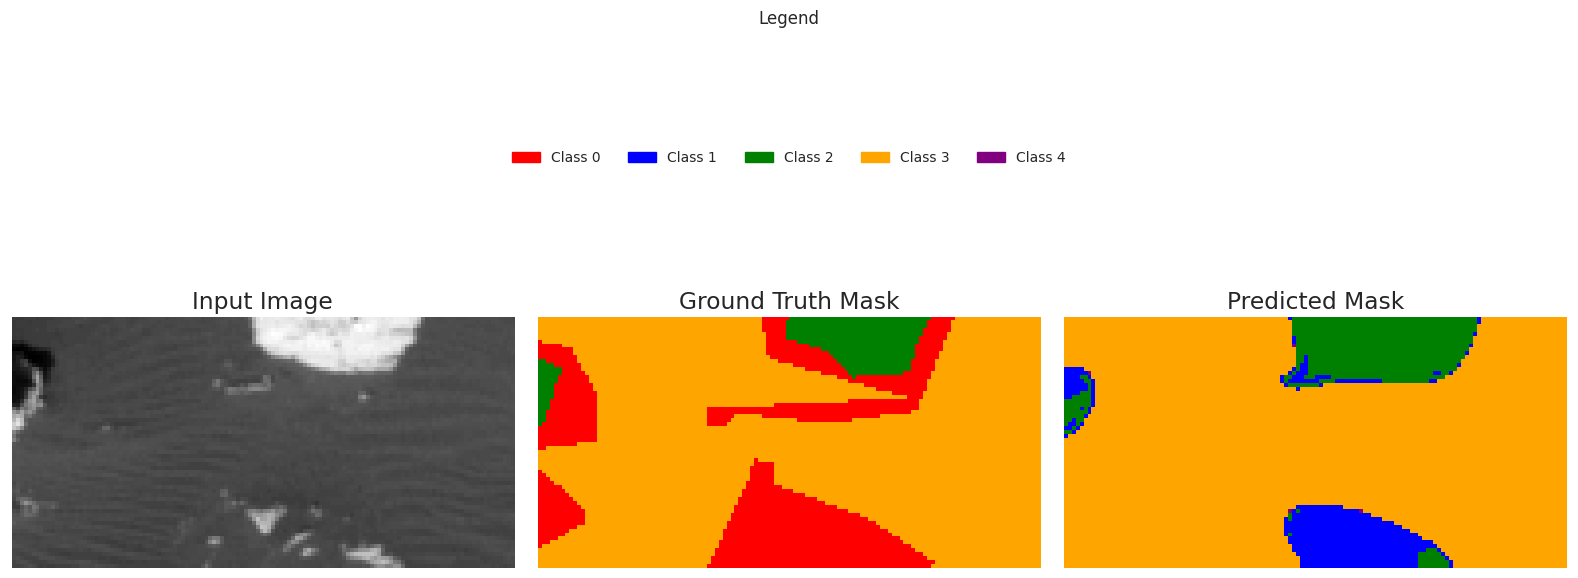

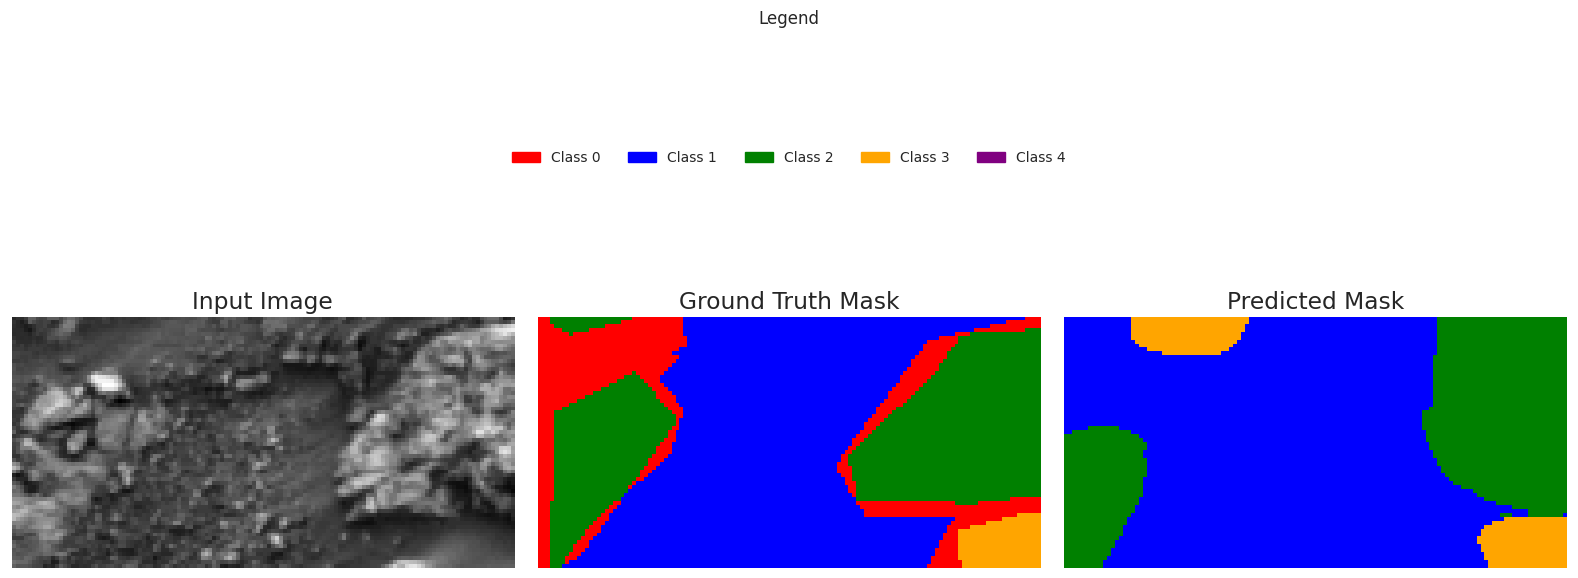

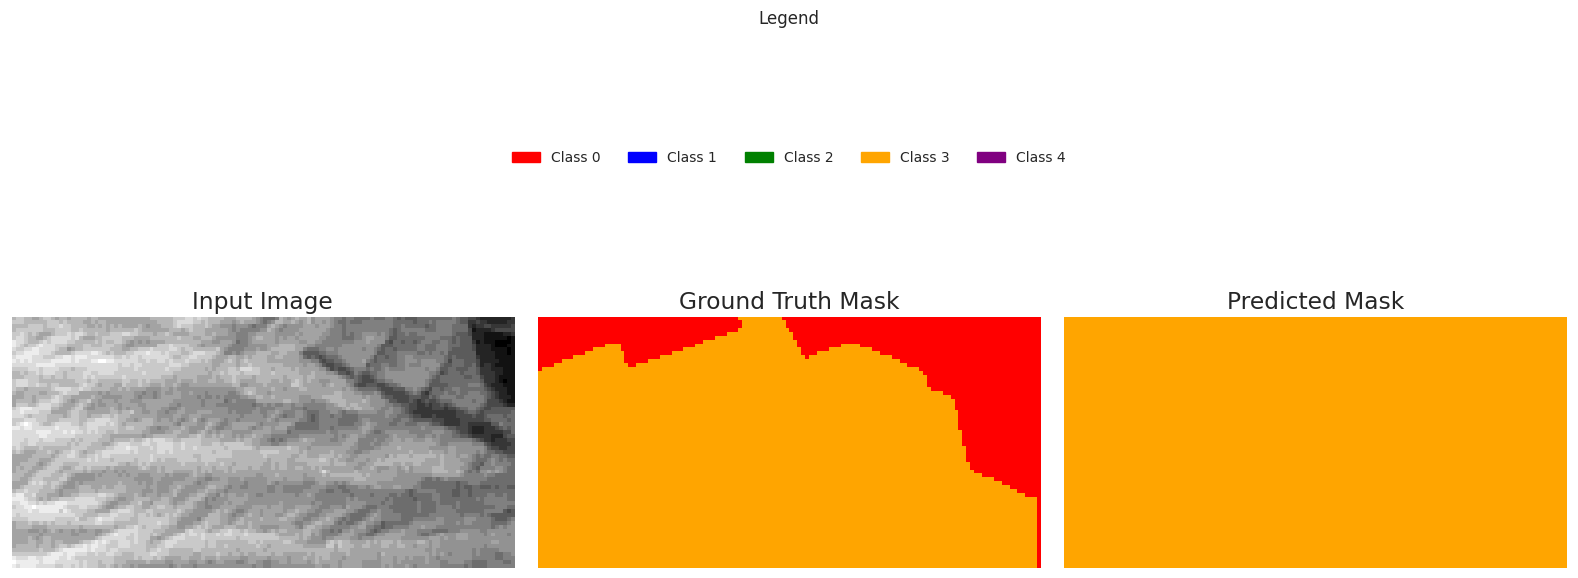

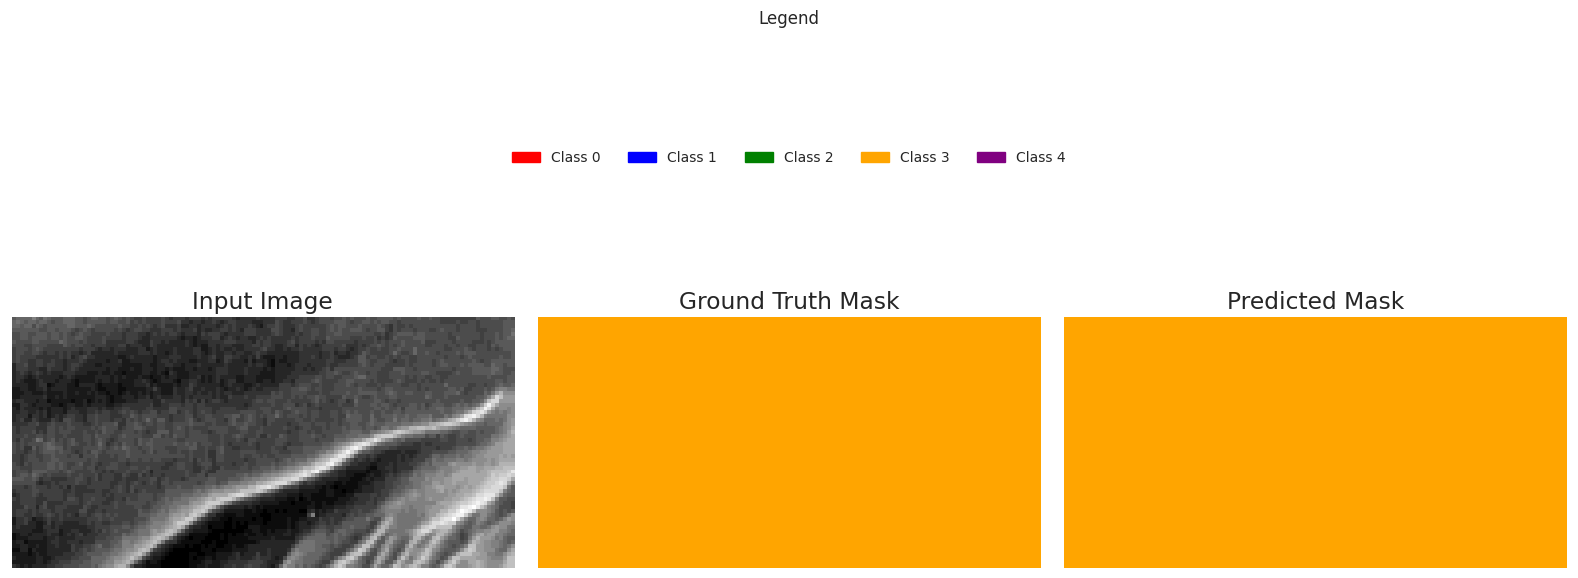

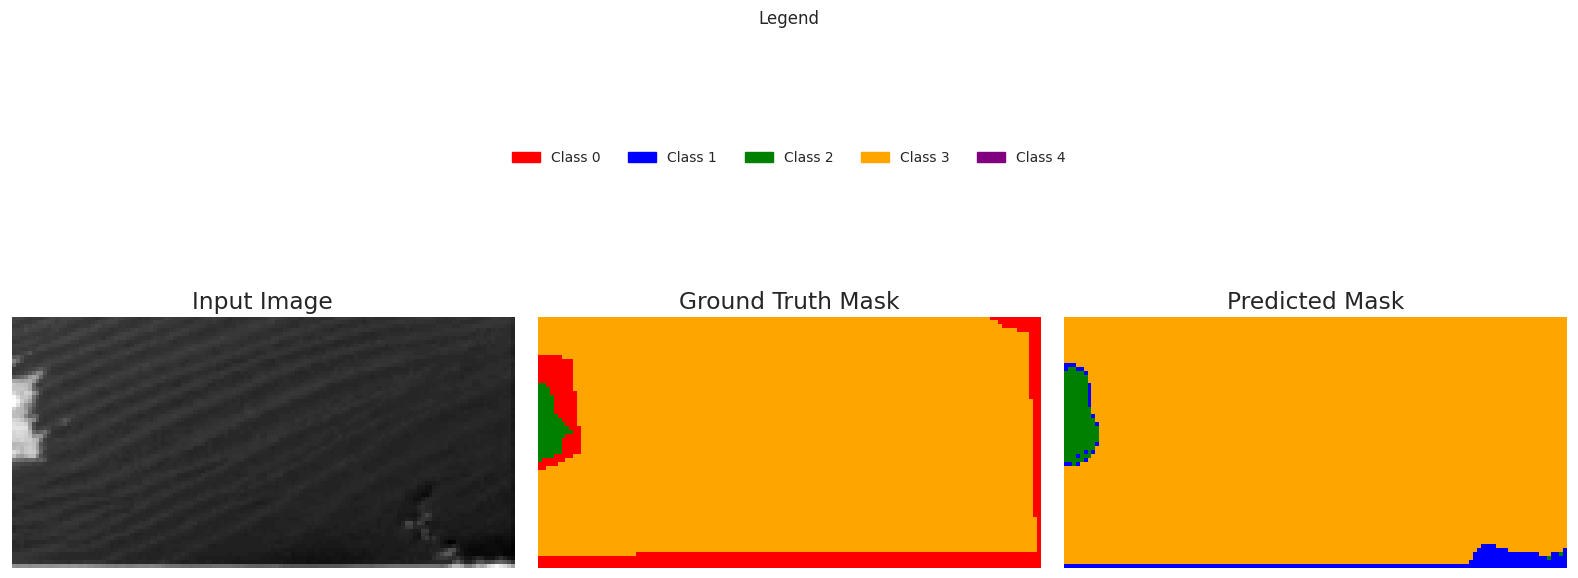

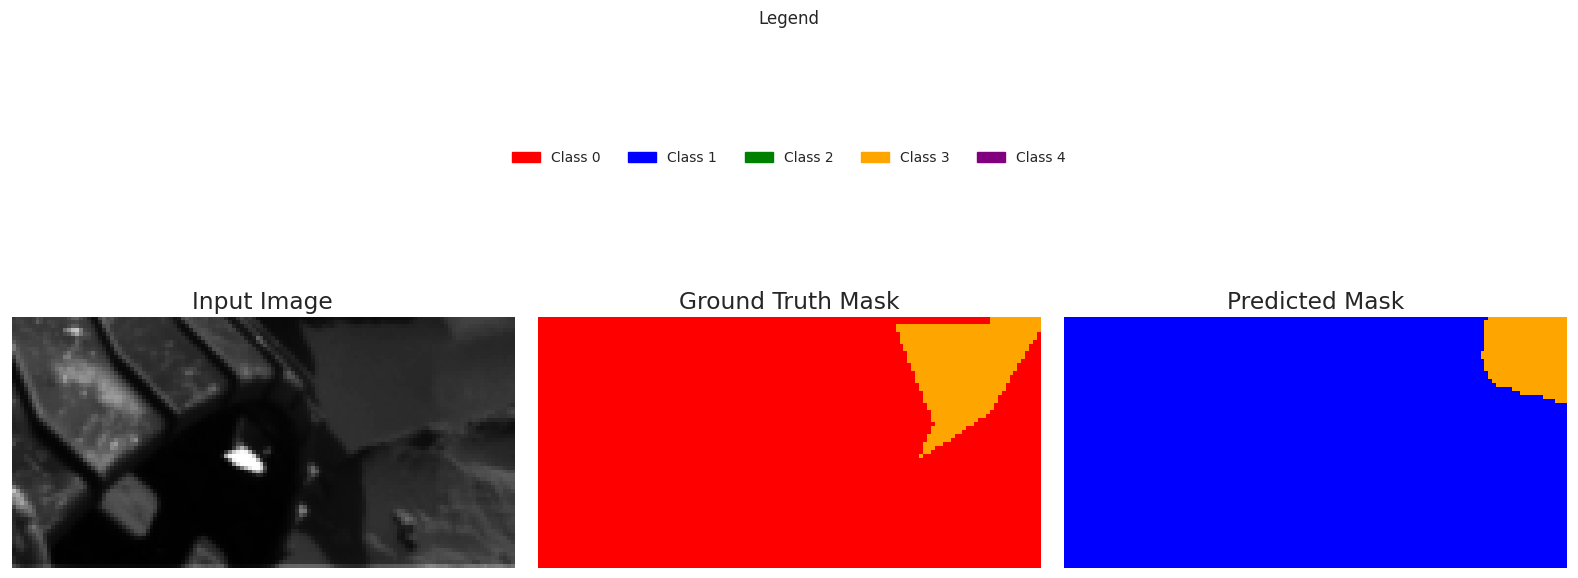

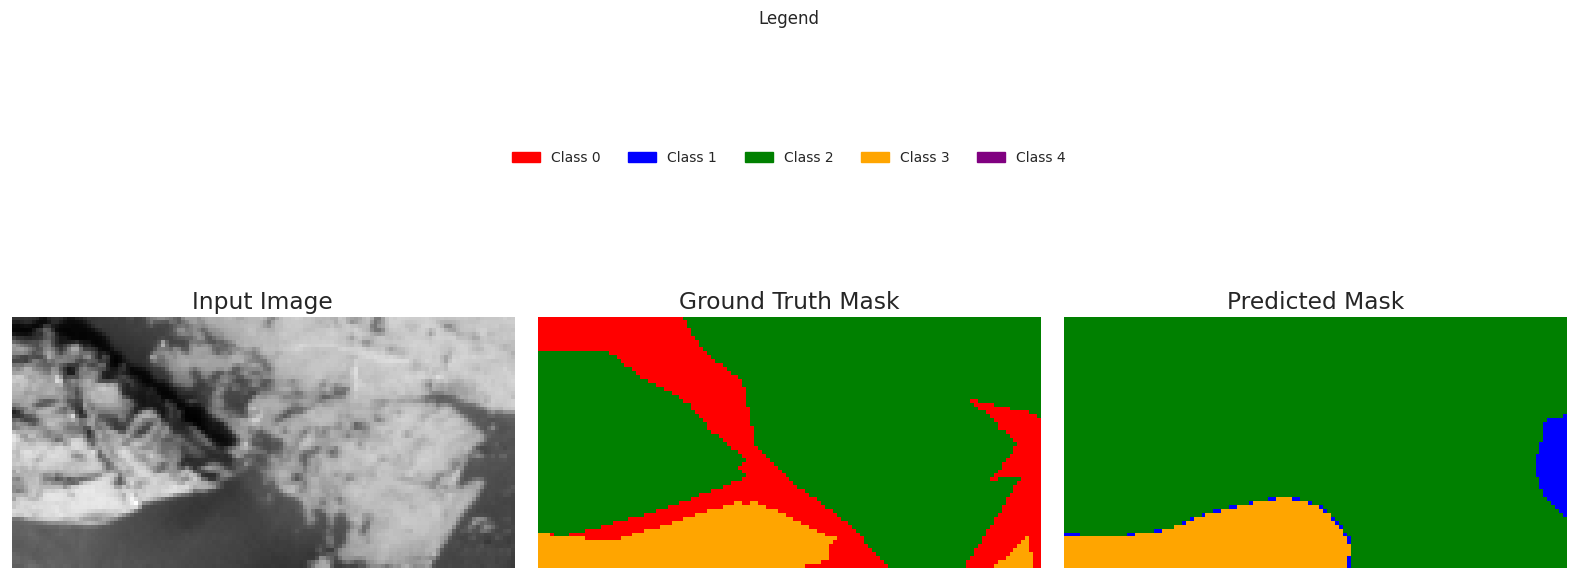

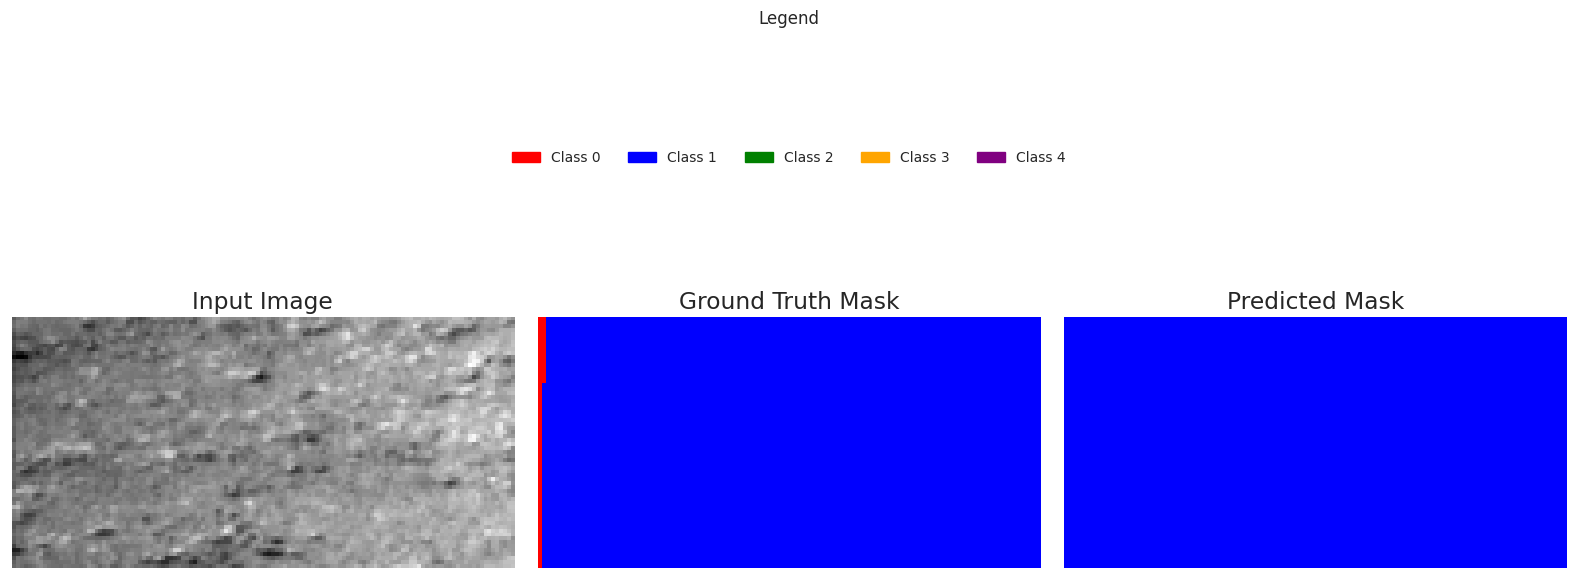

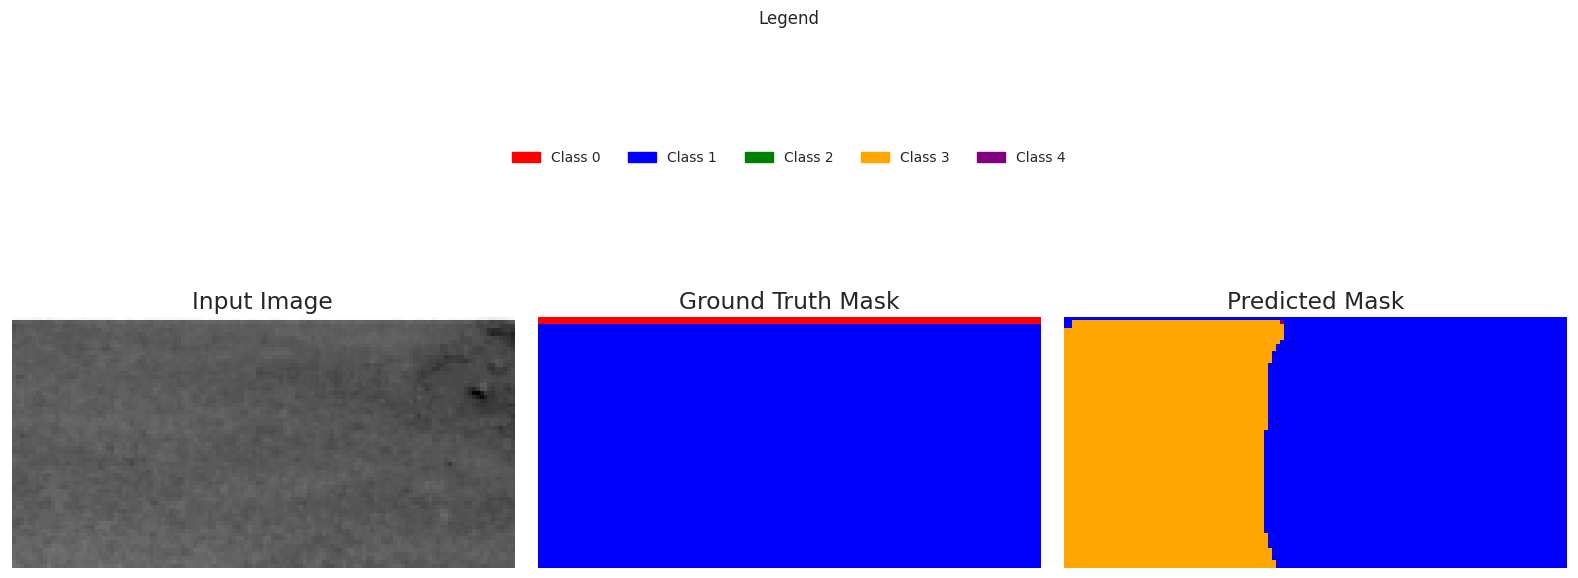

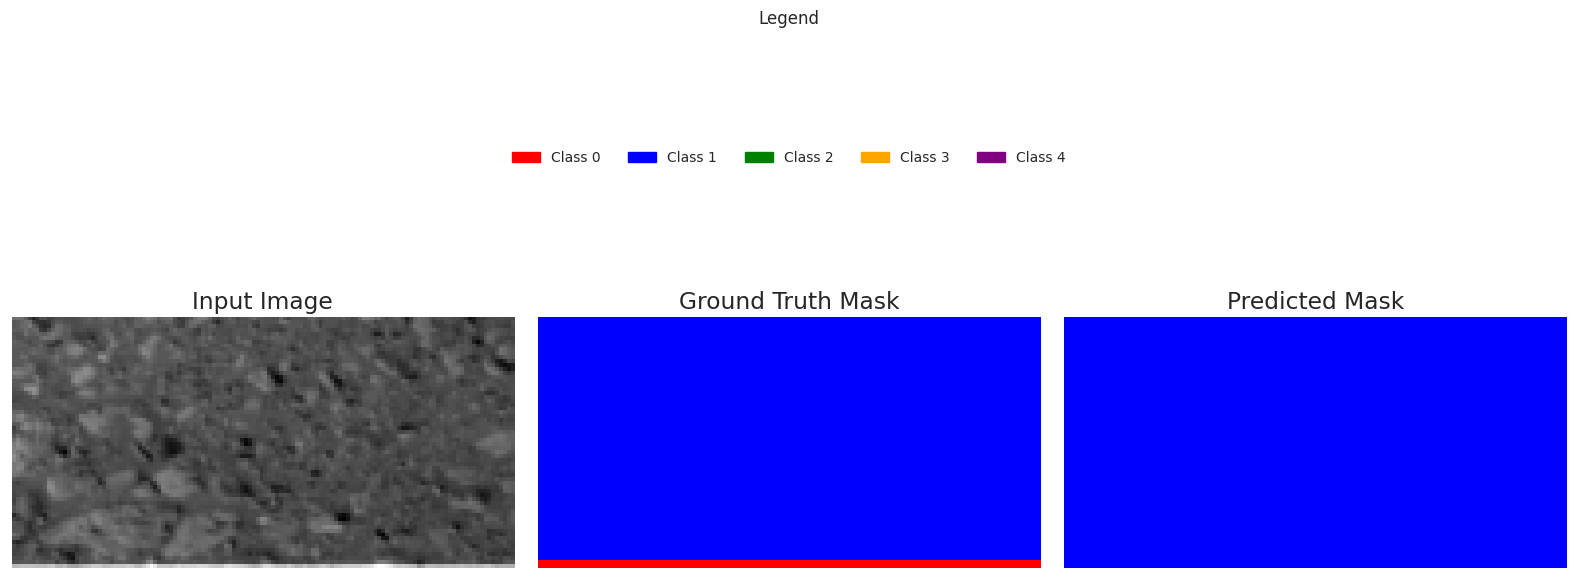

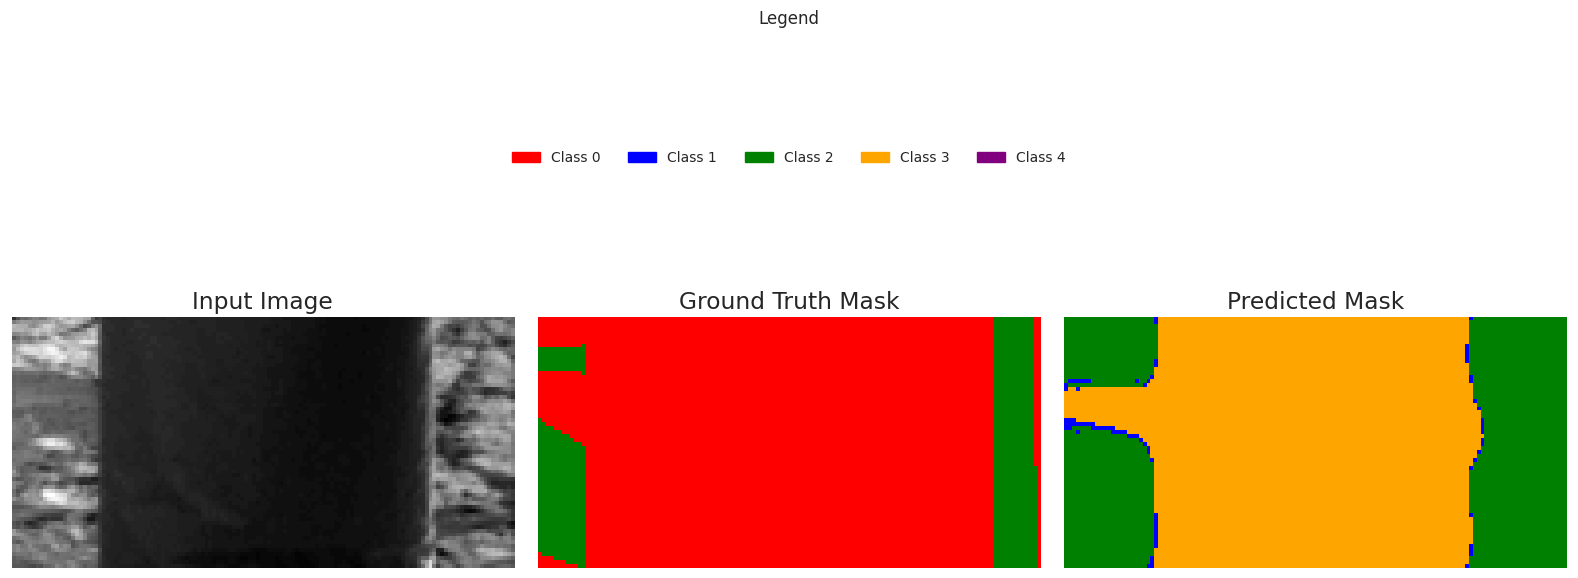

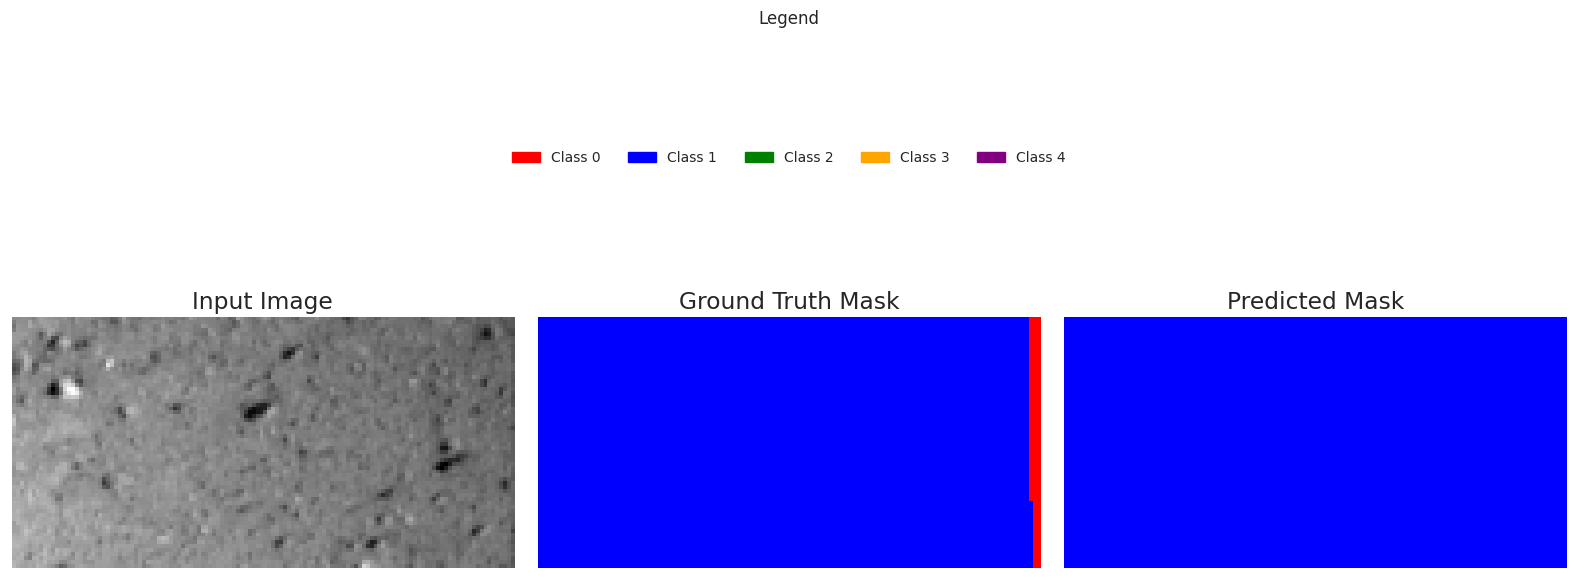

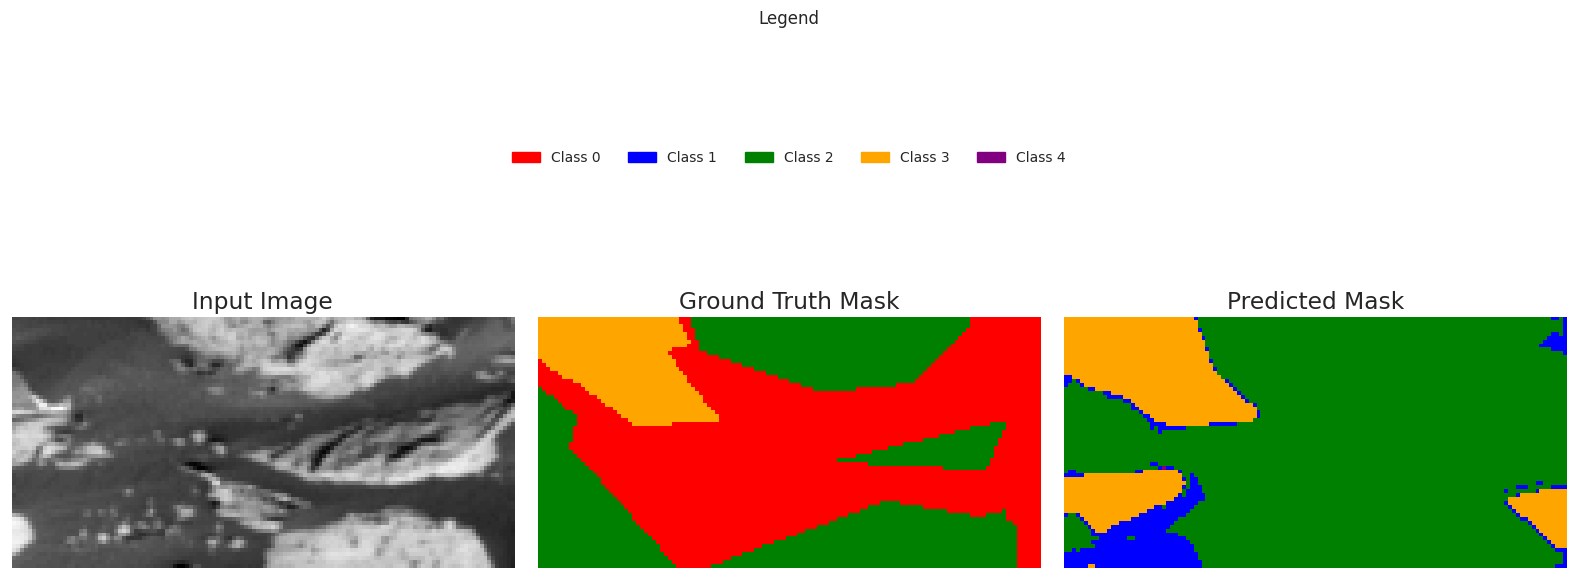

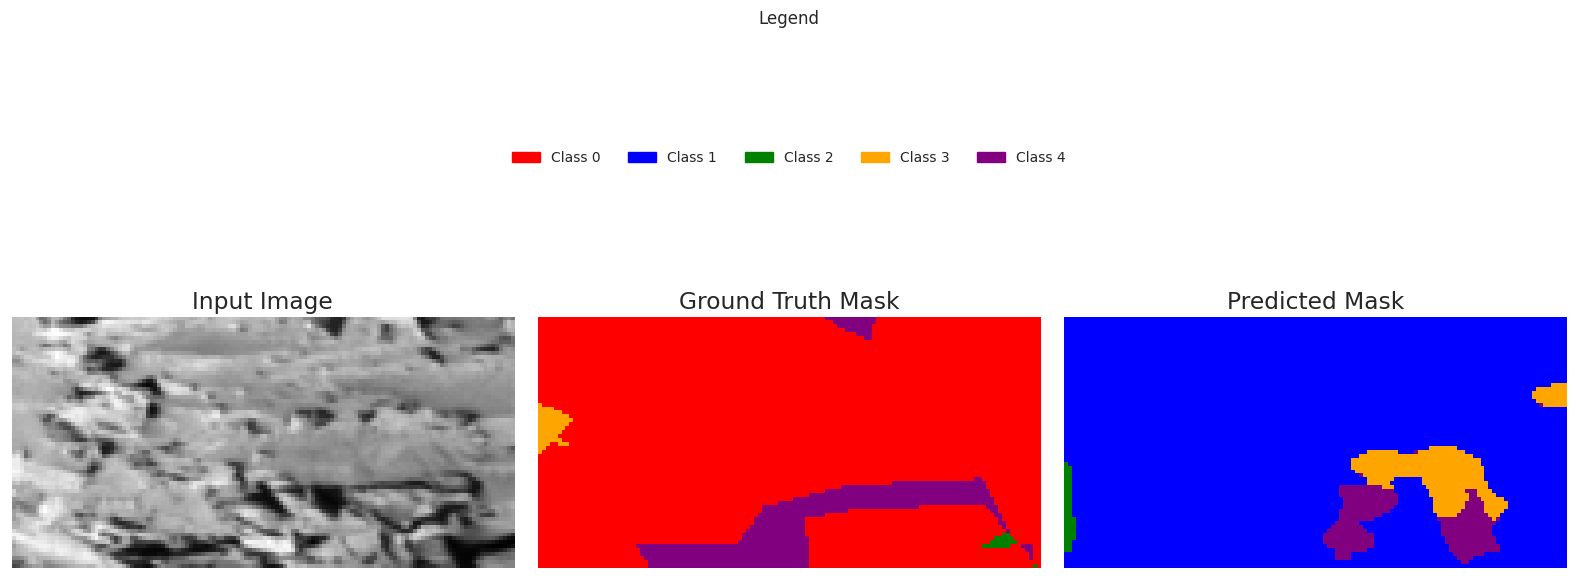

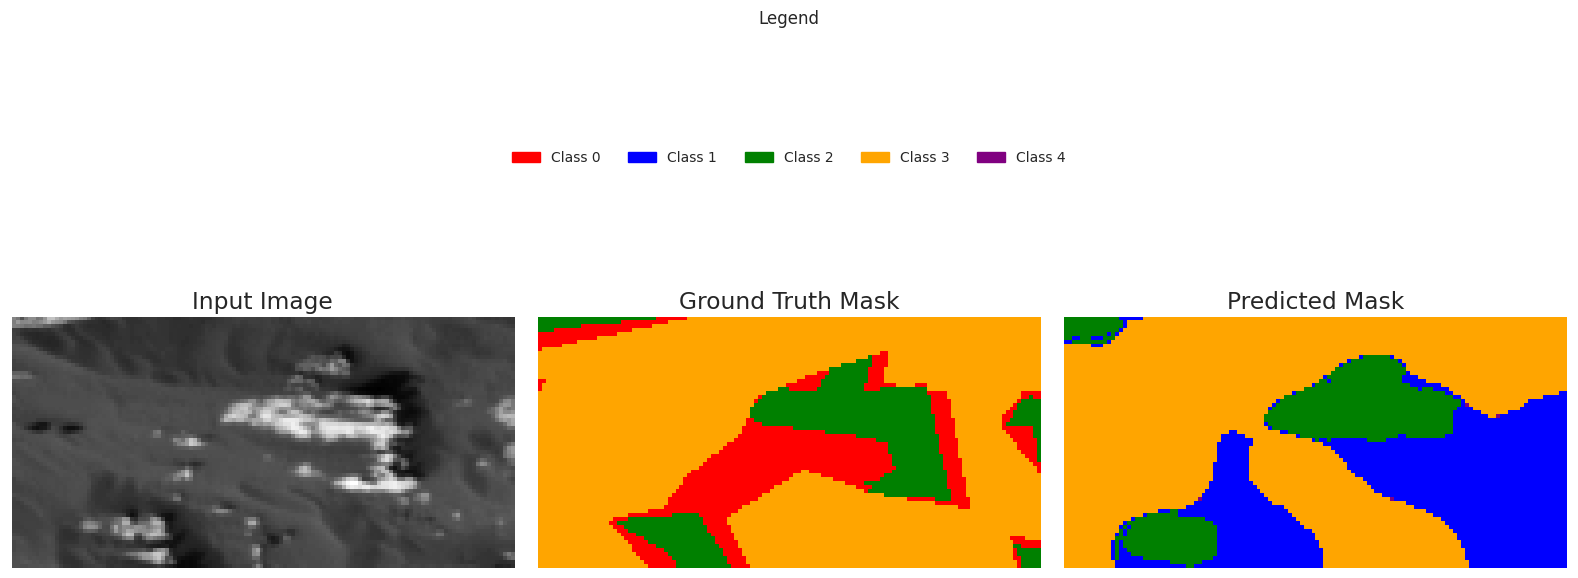

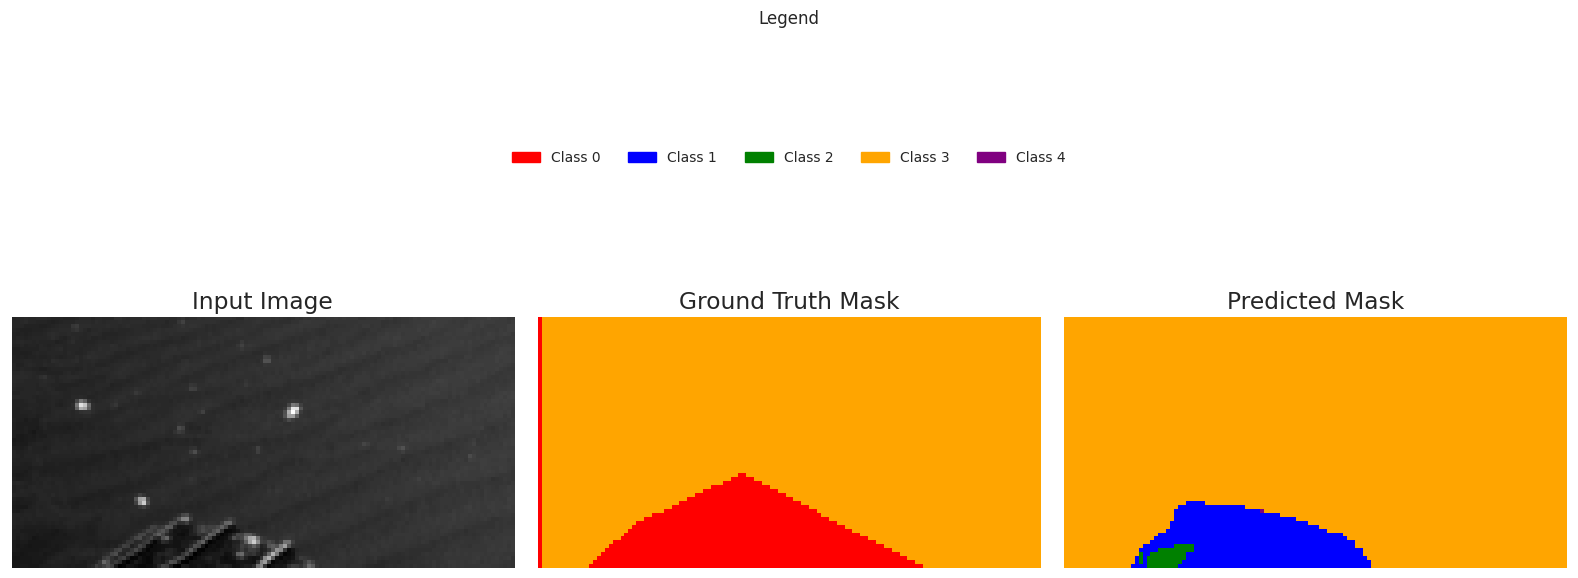

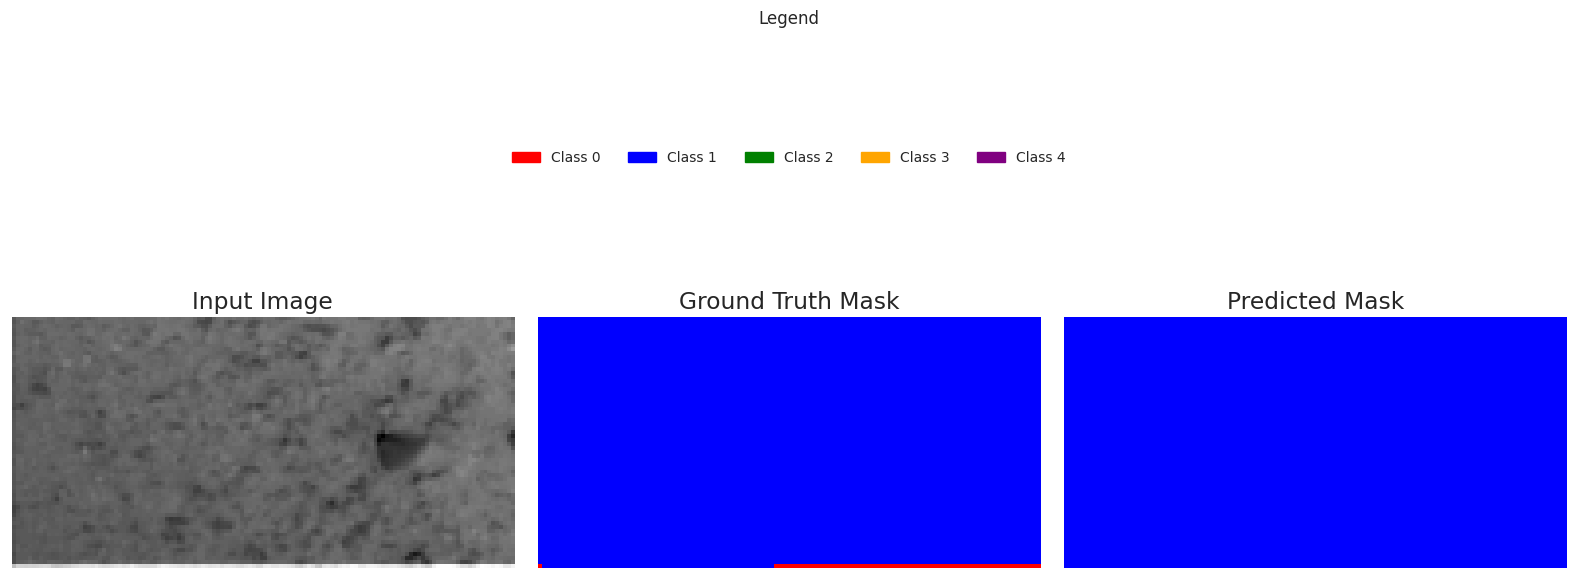

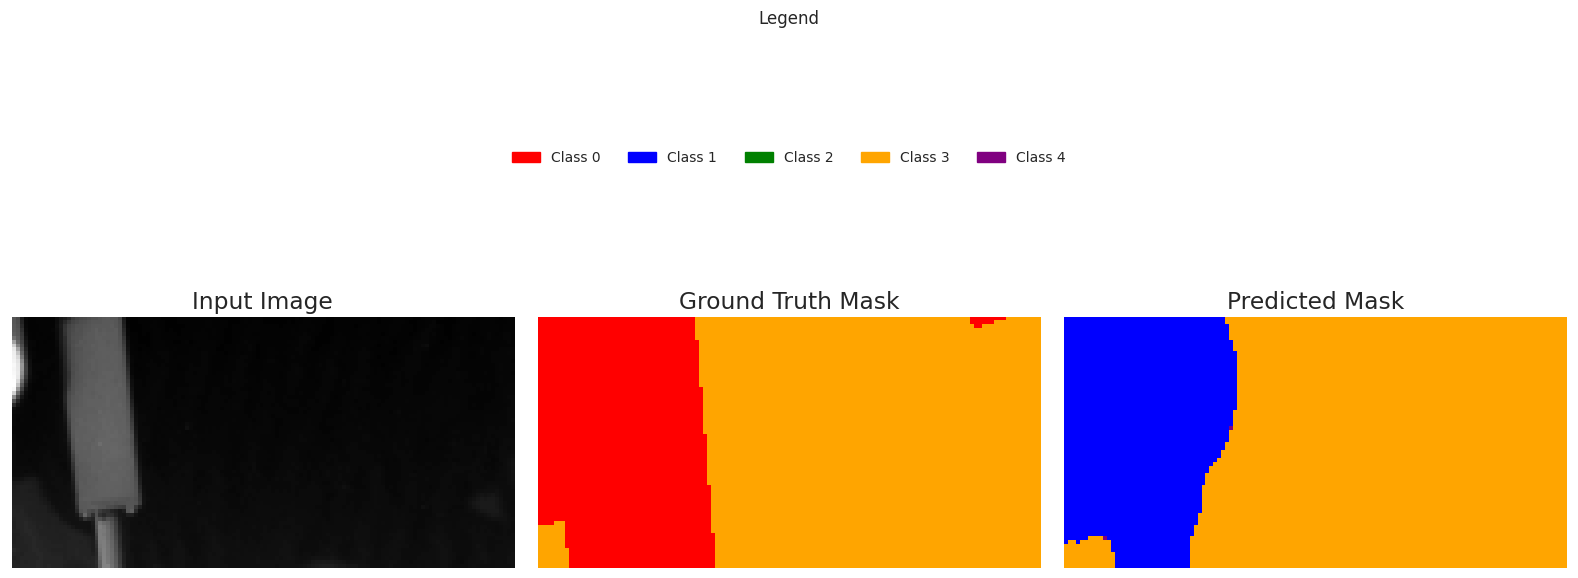

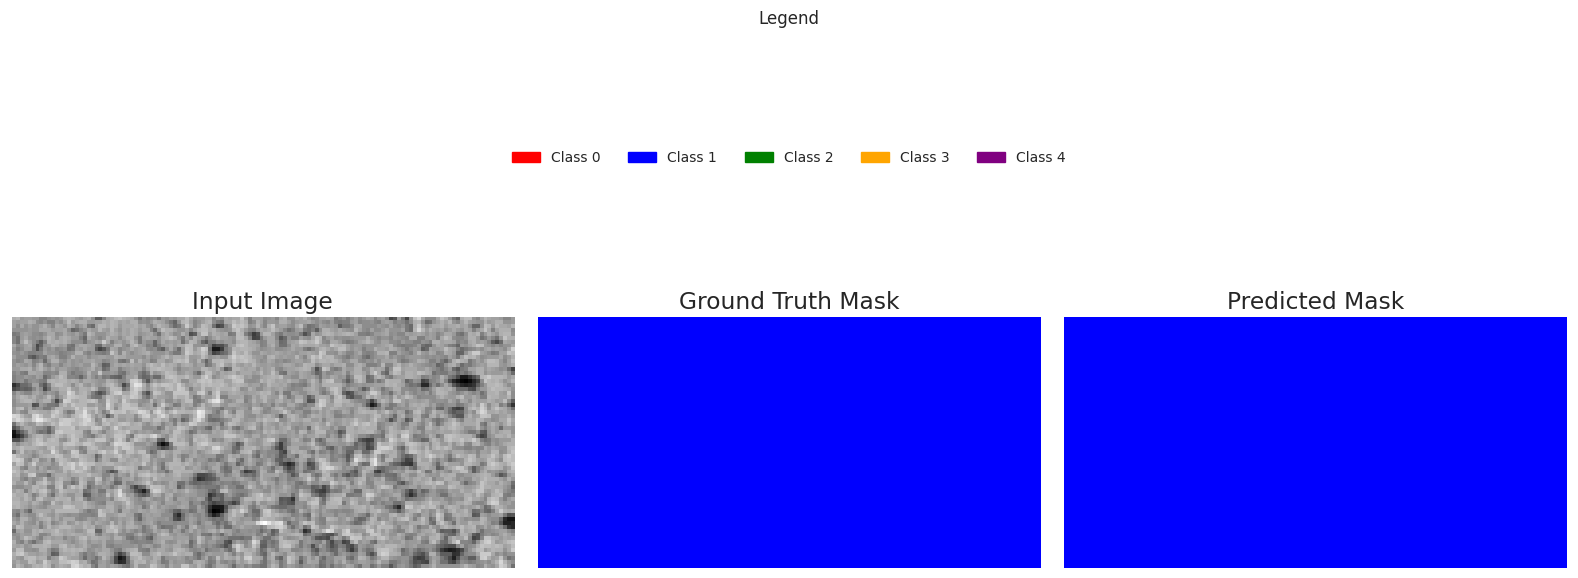

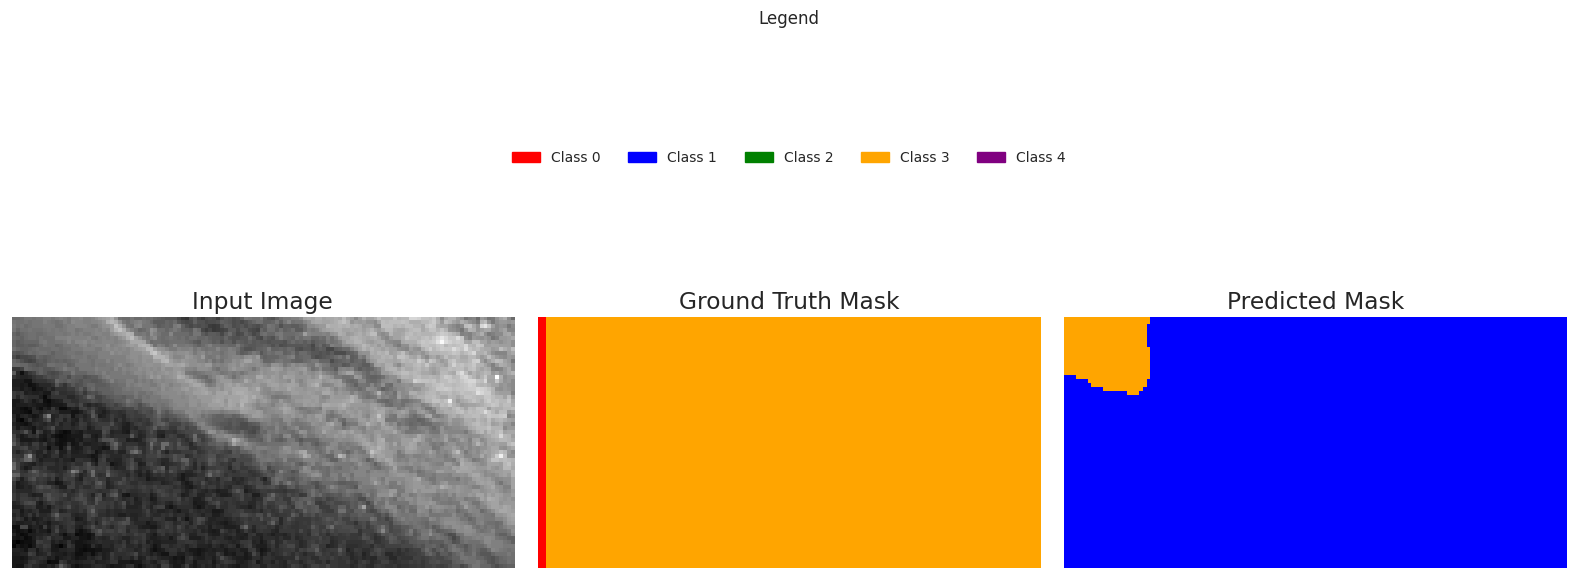

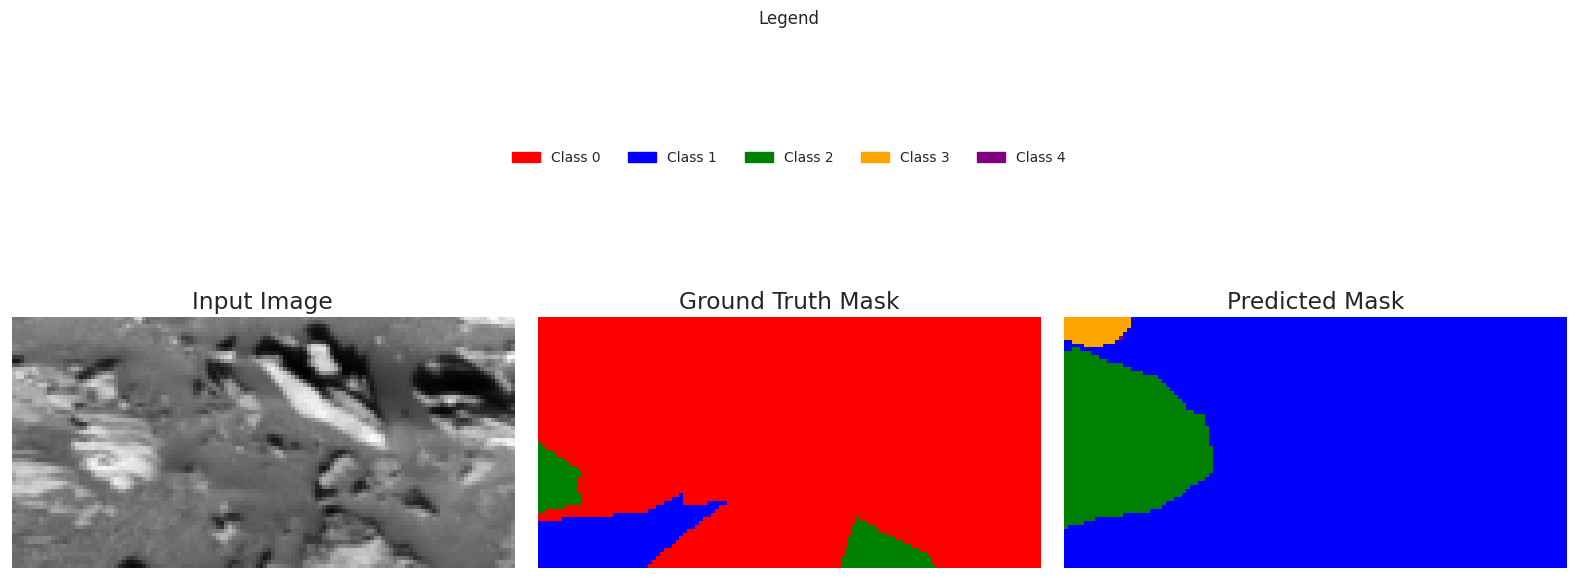

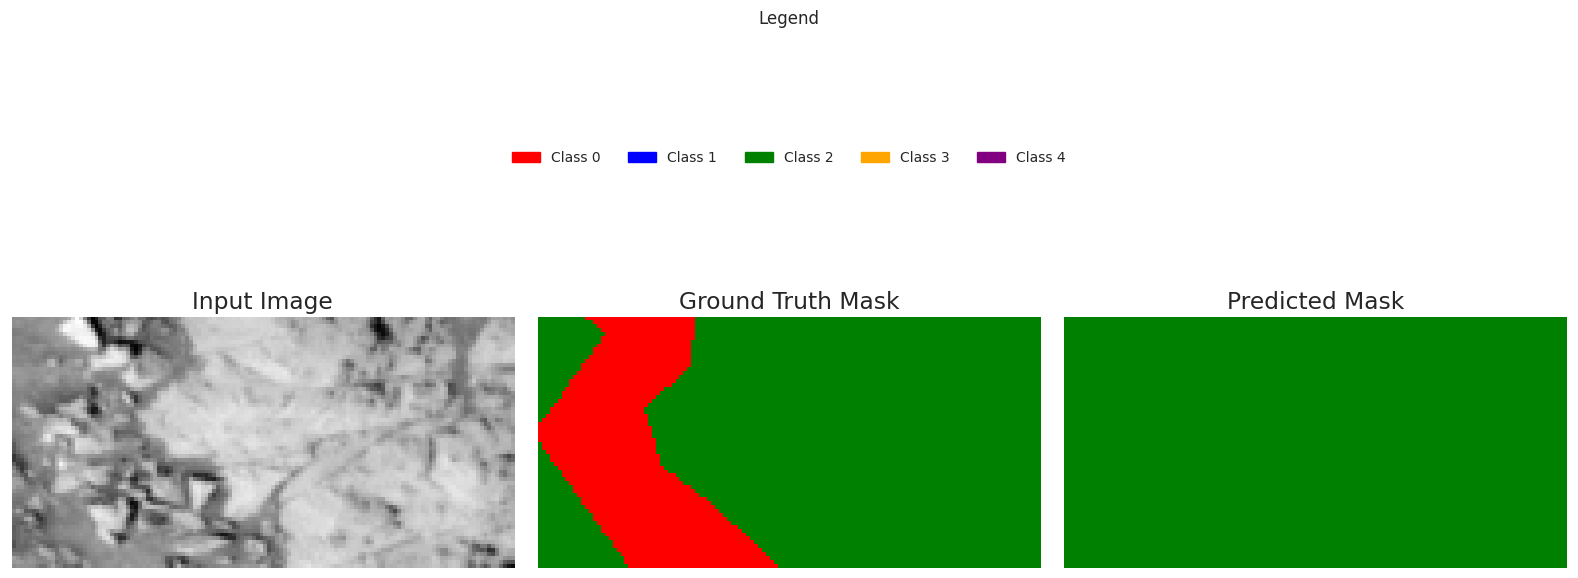

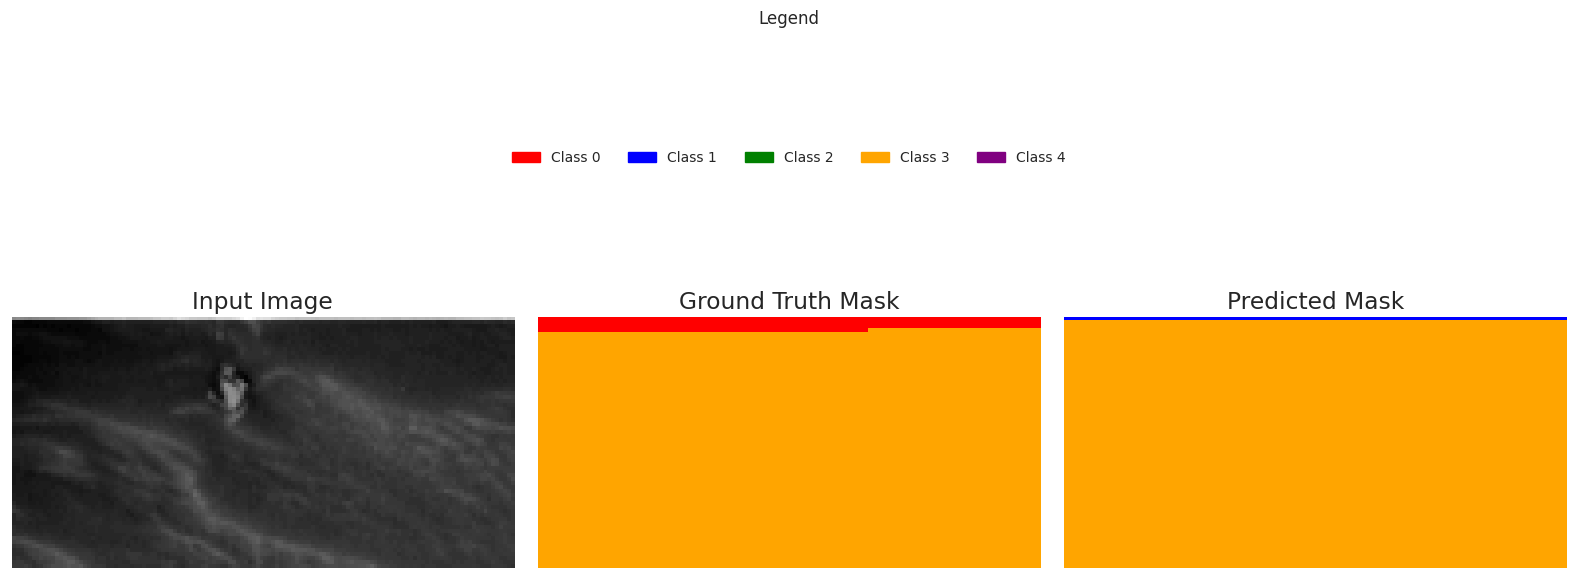

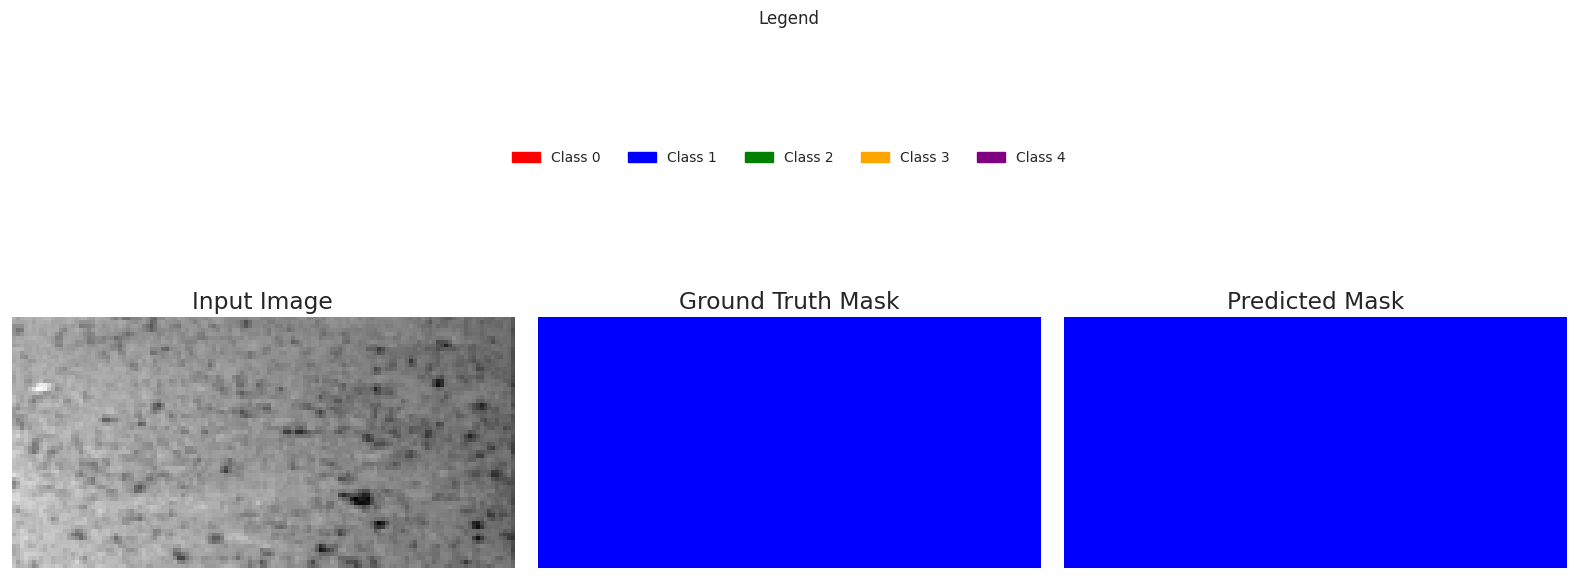

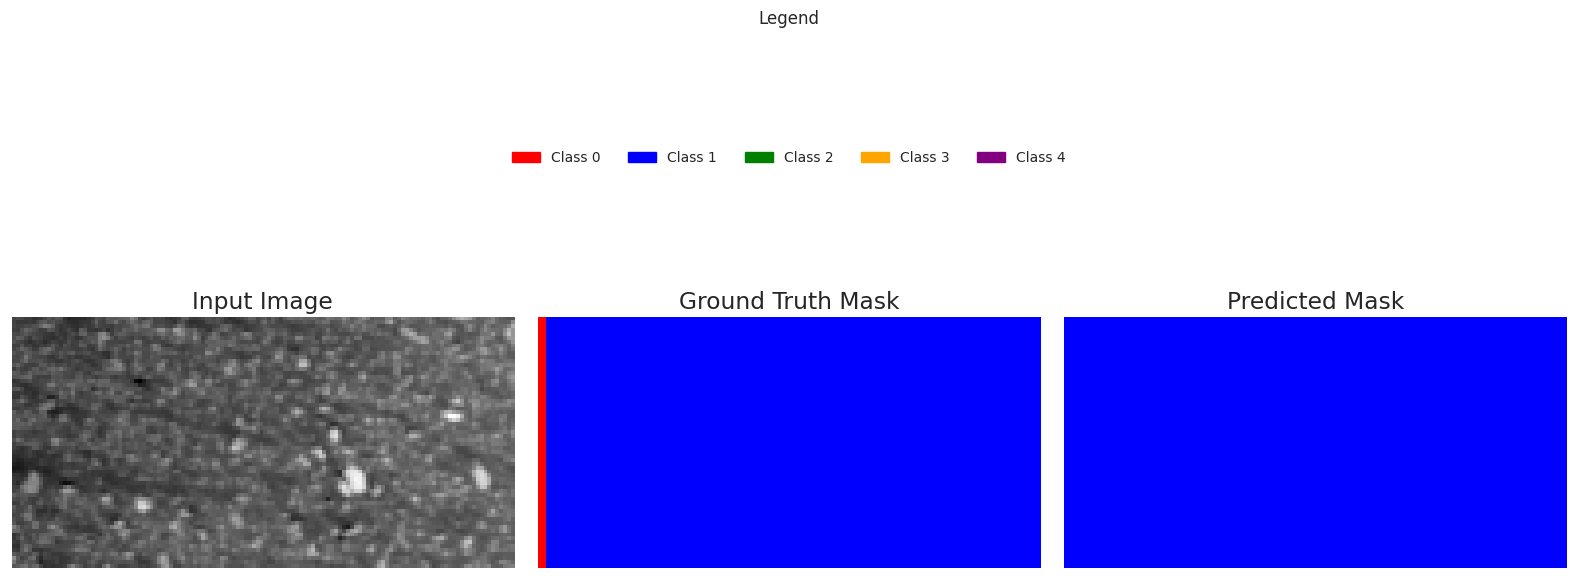

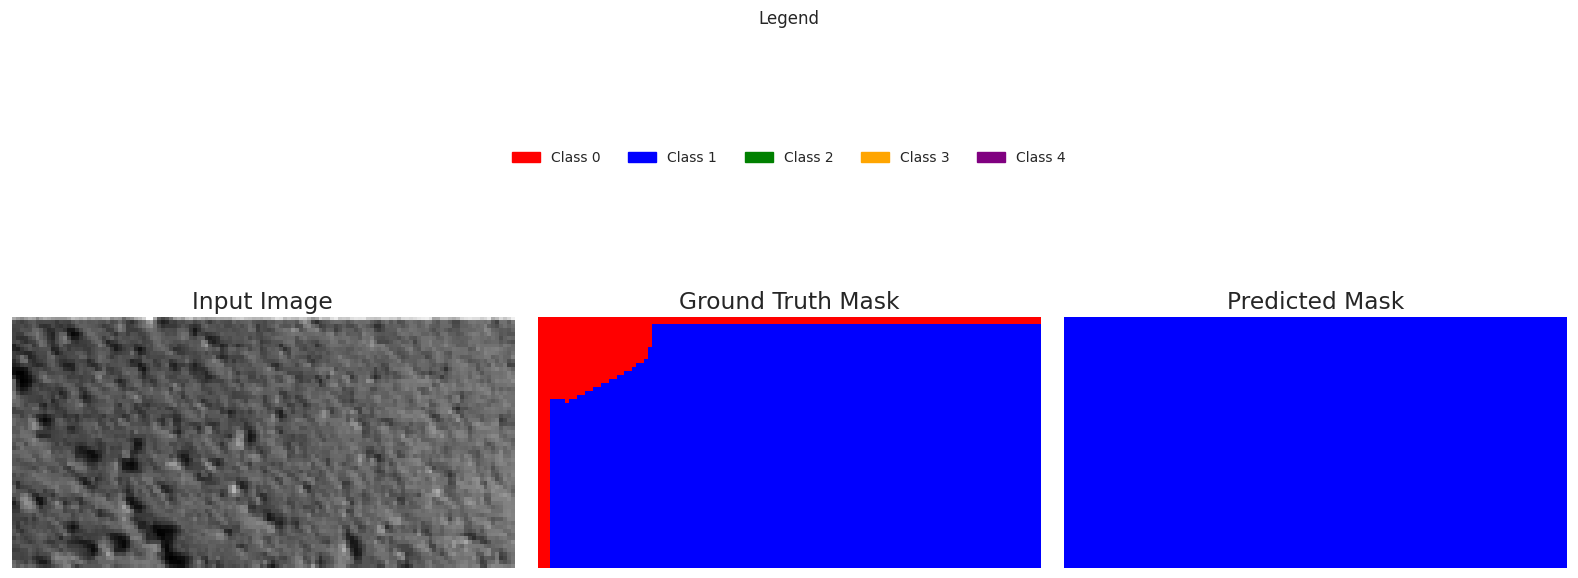

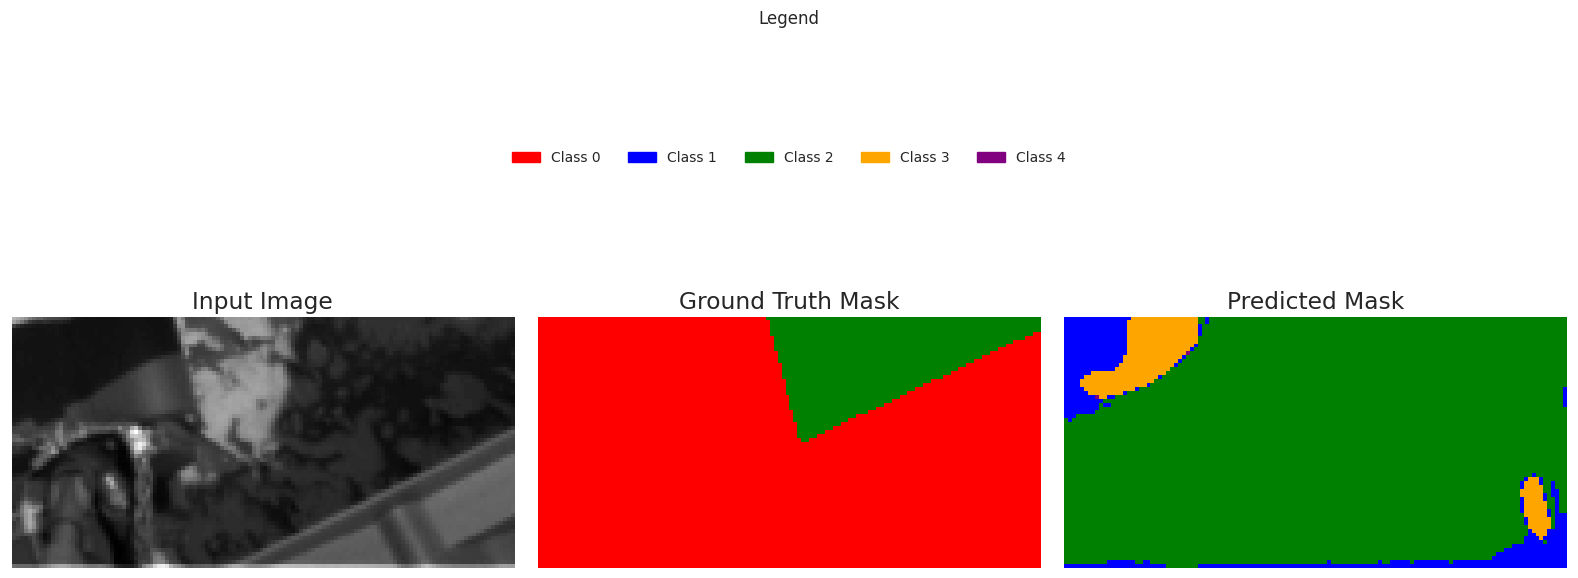

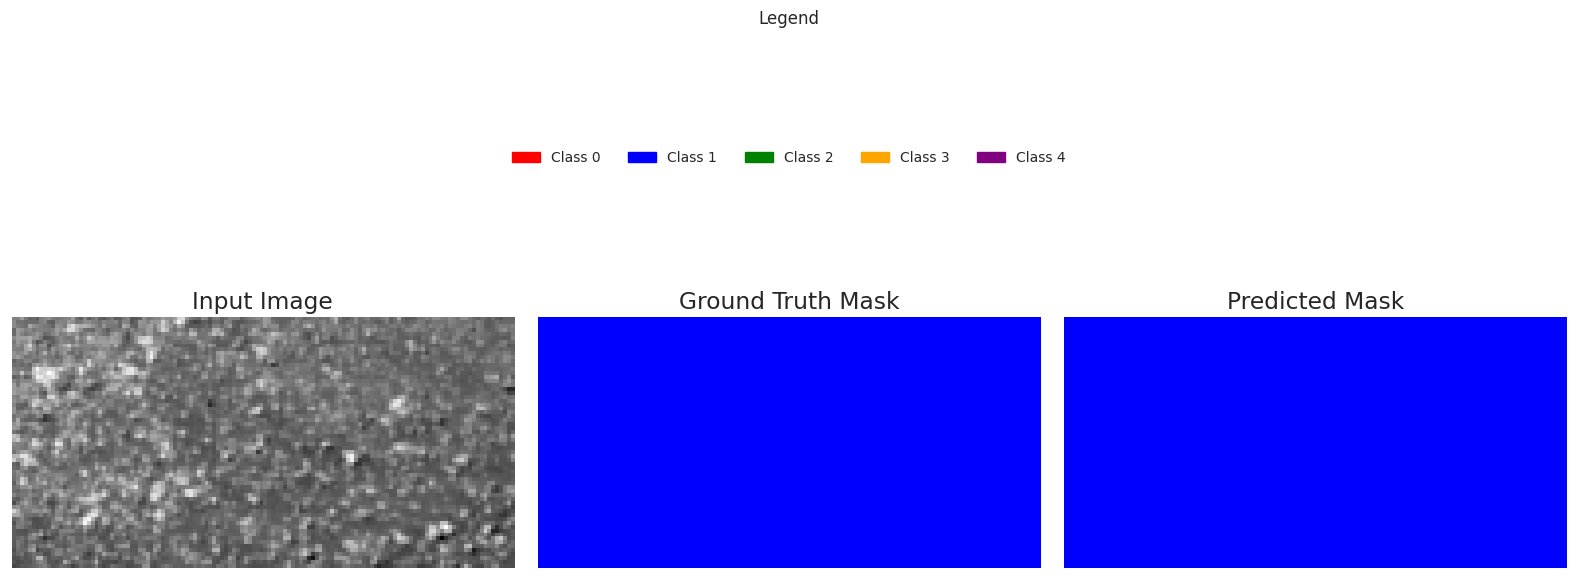

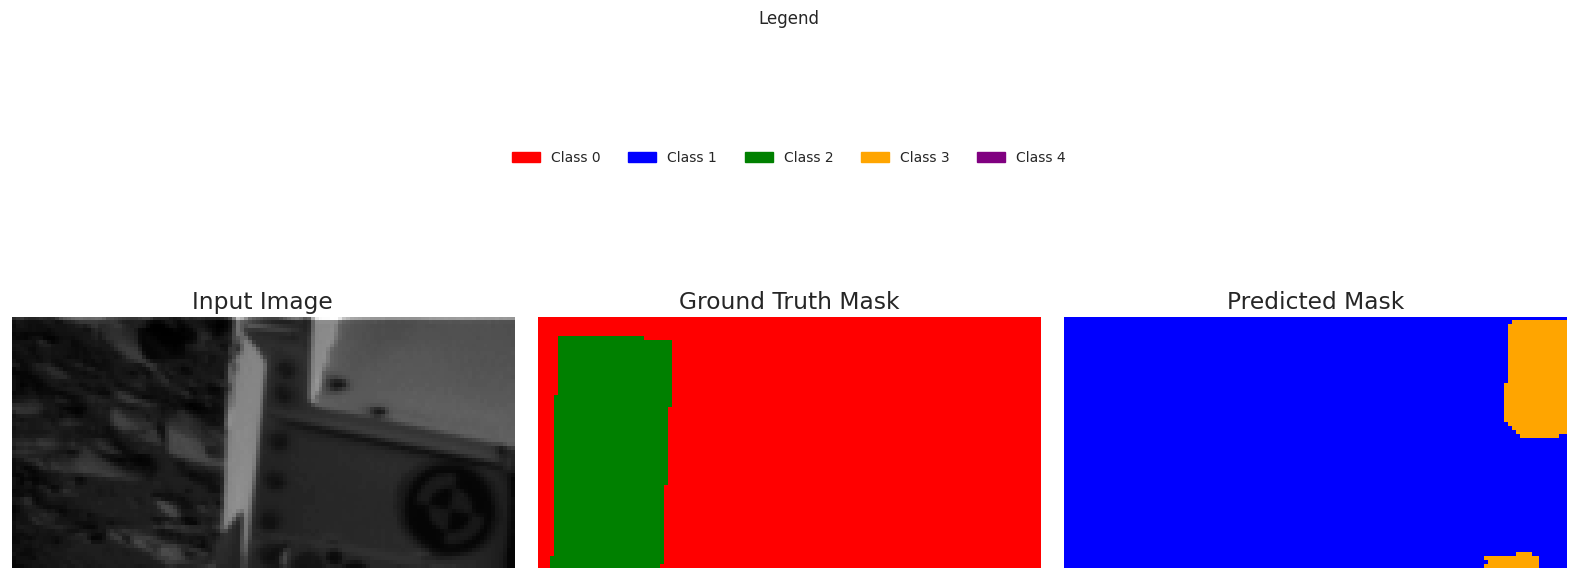

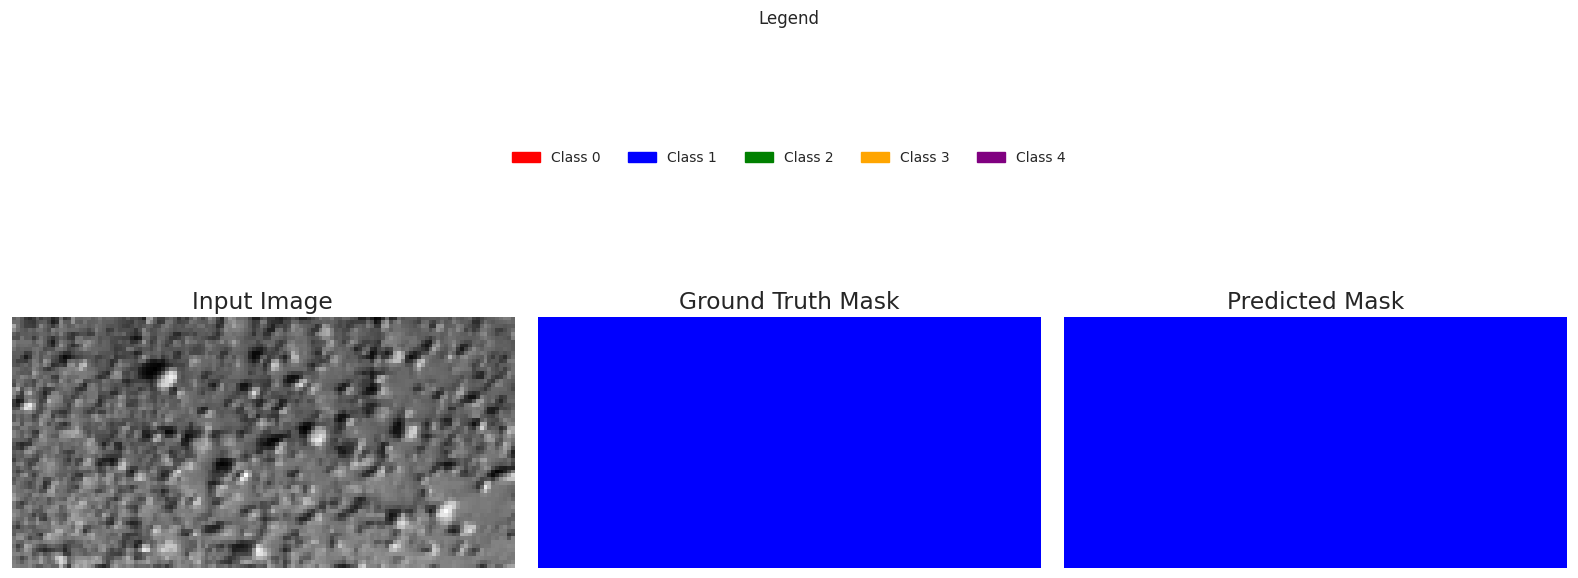

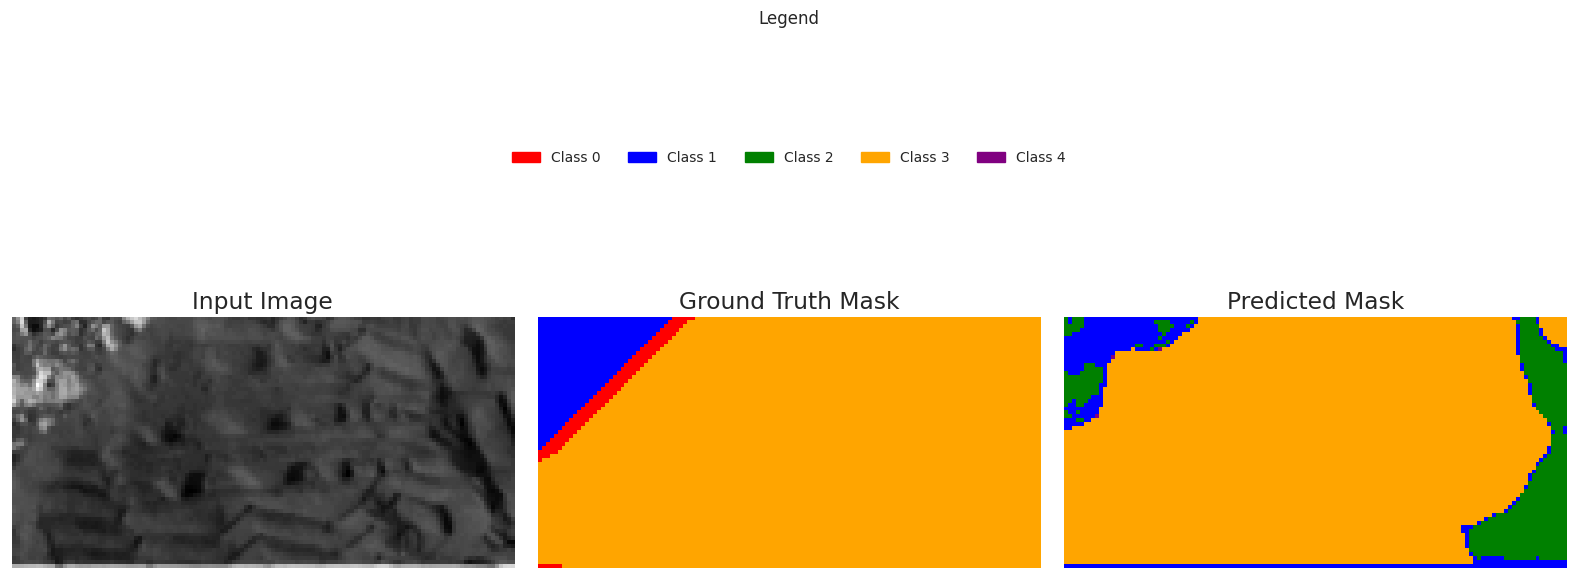

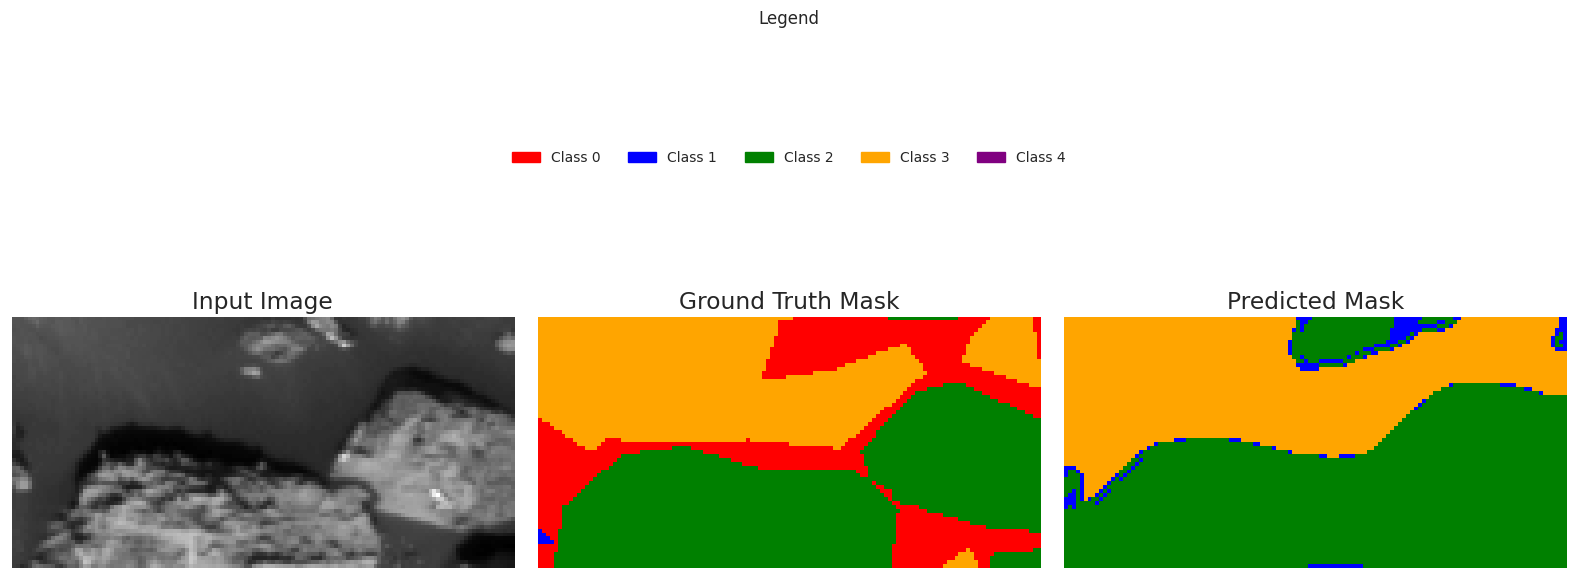

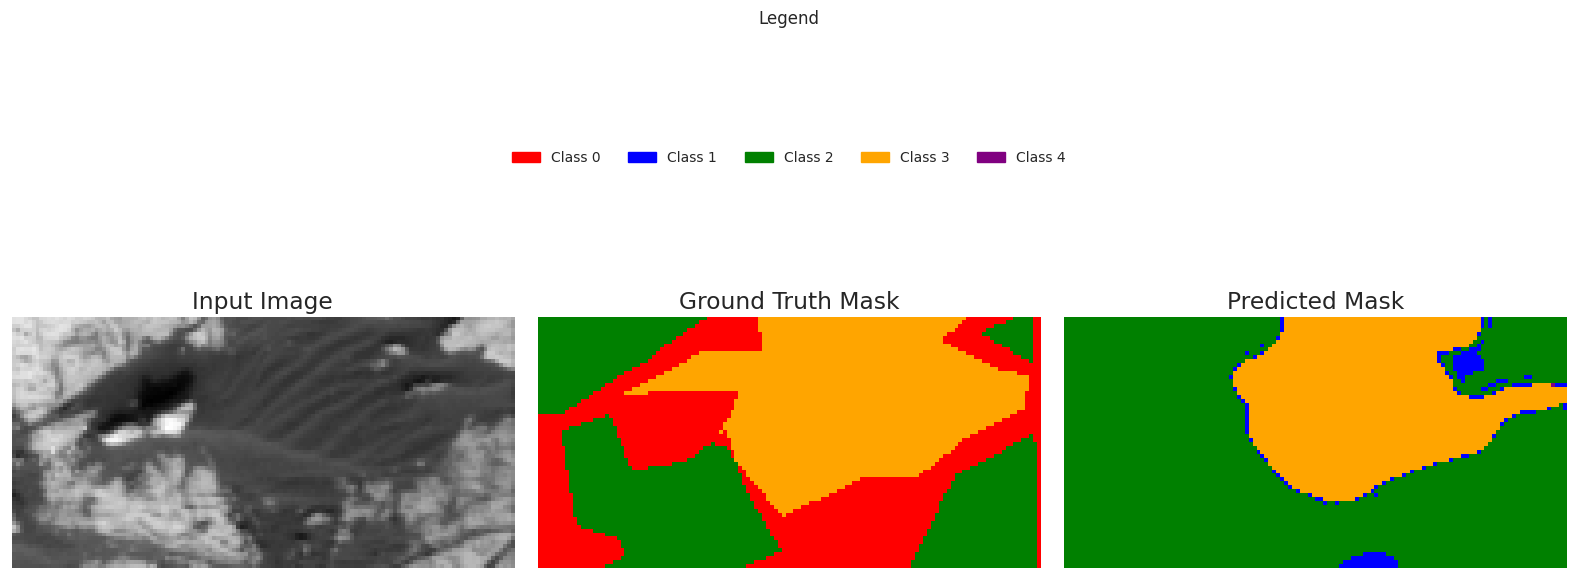

In [32]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Define the values and corresponding colors
values = [0, 1, 2, 3, 4]
colors = ['red', 'blue', 'green', 'orange', 'purple']
labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']

# Create colormap and normalization
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(values + [5], cmap.N)  # Add a boundary for the last value

# Create legend handles
legend_handles = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)]

for i in range(100):
    # Create a new figure
    plt.figure(figsize=(16, 6))

    # Add the legend at the top
    plt.subplot(2, 1, 1)
    plt.axis('off')  # Turn off the axes
    plt.legend(handles=legend_handles, loc='center', ncol=len(values), fontsize=10, frameon=False)
    plt.title("Legend", fontsize=12)

    # Plot the images
    # Input image
    plt.subplot(2, 3, 4)
    plt.imshow(val_img[i], cmap='gray')
    plt.title("Input Image")
    plt.axis('off')

    # Ground truth
    plt.subplot(2, 3, 5)
    plt.imshow(val_lbl[i], cmap=cmap, norm=norm)
    plt.title("Ground Truth Mask")
    plt.axis('off')

    # Prediction
    plt.subplot(2, 3, 6)
    plt.imshow(np.argmax(val_lbl_pred[i], axis=-1), cmap=cmap, norm=norm)
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

## 📊 Prepare Your Submission

In [33]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [34]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step
Predictions shape: (10022, 64, 128)


In [35]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [36]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

%cd /kaggle/working
from IPython.display import FileLink
FileLink(submission_filename)

/kaggle/working


/kaggle/working/submission_241214_125246.csv